In [3]:
%config Completer.use_jedi = False
import requests
import pandas as pd
import numpy as np
import datetime
from datetime import date
import glob
import matplotlib as mpl
import json
import os
import xarray as xr
import cmaps
import xesmf as xe
import seaborn as sns

import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


import regionmask
# mask out land region
land = regionmask.defined_regions.natural_earth.land_110
import rum

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22)
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22

In [4]:

def sel_summer(da):
    da_summer = da[ (da.time.dt.month>=5) & (da.time.dt.month<=8) ]
    return da_summer

def sel_July(da):
    da_summer = da[ (da.time.dt.month==7) ]
    return da_summer

def sel_land(da):
    da_land = da.where(land.mask_3D(da)).squeeze()
    return da_land

def sel_yearlist(da, yearlist):
    da_container = []
    for iyear in yearlist:
        da_container.append( da[da.time.dt.year==iyear] )
    da_selyear = xr.concat(da_container, dim='time')
    return da_selyear

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


# select a circle location from PurpleAir 
def sel_pa_AK_list_available_domain(PurpleAir_data_AK_YY_A_available_df, pa_AK_list_A_available, c_latlon):
    
    c_lat = c_latlon[0]
    c_lon = c_latlon[1]
    
    pa_AK_list_available_domain = pa_AK_list_A_available[
    list( map( lambda a,b: rum.utilities.haversine(c_lat, c_lon, a,b) <= 27.5,\
    pa_AK_list_A_available["latitude"], pa_AK_list_A_available["longitude"]) ) 
    ]

    tmp = pa_AK_list_available_domain["column_name"].tolist()
    PurpleAir_data_AK_YY_A_DEC = PurpleAir_data_AK_YY_A_available_df[ tmp ]
    PurpleAir_data_AK_YY_A_DEC_da = PurpleAir_data_AK_YY_A_DEC.mean(axis=1).to_xarray()
    
    return PurpleAir_data_AK_YY_A_DEC_da



def calculate_sma_regression(aod, pm25, period):
    # Ensure AOD and PM2.5 have the same time coordinate
    assert np.all(aod.time == pm25.time)

    # Convert DataArray to DataFrame
    aod_df = aod.to_dataframe(name='aod')
    pm25_df = pm25.to_dataframe(name='pm25')

    # Merge two dataframes
    df = pd.merge(aod_df, pm25_df, left_index=True, right_index=True)

    # Convert to periods of T days
#     df['period'] = (df.index - df.index[0]).days // T

    # Initialize lists to store results
    slopes = []
    avg_aods = []

    # For each period...
#     for _, period_df in df.groupby('period'):
    for _, period_df in df.resample(period):
        
#         print(period_df)

        # ...drop NaN values
        period_df = period_df.dropna()

        # ...calculate the linear regression through the origin
        if len(period_df) >= 1:
#             s = np.polyfit(period_df['aod'], period_df['pm25'], 1)[0]
#             s = np.polyfit(period_df['aod'], period_df['pm25'], deg=1, full=False)[0]
            s = period_df['pm25'].mean() / period_df['aod'].mean()
            if s<=0:
                s=np.nan
        else:
            s = np.nan

        # ...and the average AOD
        avg_aod = period_df['aod'].mean()
        
#         # remove negative s
#         if s <= 0:
#             s = np.nan
#             avg_aod = np.nan

        # Store the results
        slopes.append(s)
        avg_aods.append(avg_aod)

    return avg_aods, slopes



# calculate GEOS-Chem slope

def slope_GC_periods(PM25daily, AODdaily, daynum_bounds):

    import warnings
    warnings.filterwarnings('ignore')

    # monthly slope pattern
    slopes_GC_18_monthly_list = []
    
    if daynum_bounds == "monthly":
        for imon in range(5,9):
            PM25_GC_18_surf_daily_mon = PM25daily[PM25daily.time.dt.month==imon]
            AOD_GC_18_noon_total_daily_mon = AODdaily[AODdaily.time.dt.month==imon]
            if len(PM25_GC_18_surf_daily_mon.values)==0:
                continue
            slopes_GC = rum.utilities.array_LR_InterceptZero( AOD_GC_18_noon_total_daily_mon, PM25_GC_18_surf_daily_mon)
#             slopes_GC = PM25_GC_18_surf_daily_mon.mean(dim='time').values / AOD_GC_18_noon_total_daily_mon.mean(dim='time').values

            slopes_GC_18_monthly_list.append(slopes_GC)
            
    elif daynum_bounds == "weekly":
        
        time_wk_list = []

        for iwk in range(17,36):
            PM25_GC_18_surf_daily_wk = PM25daily[PM25daily.time.dt.week==iwk]
            AOD_GC_18_noon_total_daily_wk = AODdaily[AODdaily.time.dt.week==iwk]
            if len(AOD_GC_18_noon_total_daily_wk.time)<5:
                continue
            
            slopes_GC = rum.utilities.array_LR_InterceptZero( AOD_GC_18_noon_total_daily_wk, PM25_GC_18_surf_daily_wk)
#             slopes_GC = PM25_GC_18_surf_daily_wk.mean(dim='time').values / AOD_GC_18_noon_total_daily_wk.mean(dim='time').values
            slopes_GC_18_monthly_list.append(slopes_GC)
            time_wk_list.append(AOD_GC_18_noon_total_daily_wk.resample(time='1W').mean(dim='time').time )

    else:
        for ibound in range(0,len(daynum_bounds)-1):
            PM25_GC_18_surf_daily_mon = PM25daily[daynum_bounds[ibound]:daynum_bounds[ibound+1],:,:]
            AOD_GC_18_noon_total_daily_mon = AODdaily[daynum_bounds[ibound]:daynum_bounds[ibound+1],:,:]
            slopes_GC = rum.utilities.array_LR_InterceptZero( AOD_GC_18_noon_total_daily_mon, PM25_GC_18_surf_daily_mon)
            slopes_GC_18_monthly_list.append(slopes_GC)


    # concat monthly GC slope
    slopes_GC_18_monthly = np.stack(slopes_GC_18_monthly_list, axis=0)
    if daynum_bounds == "weekly": 
        time_wk = xr.concat(time_wk_list, dim='time')
    
#     print(slopes_GC_18_monthly.shape)
#     print("/")
#     print(AODdaily.resample(time='1MS').mean(dim='time').time)
    
    # put in xarray
    if daynum_bounds == "monthly":
        slopes_GC_18_monthly_da = xr.DataArray(slopes_GC_18_monthly, coords=[  AODdaily.resample(time='1MS').mean(dim='time').time, \
                                                                               AODdaily.lat, \
                                                                               AODdaily.lon
                                                                            ], dims=['time', 'lat','lon'])
    elif daynum_bounds == "weekly":
        slopes_GC_18_monthly_da = xr.DataArray(slopes_GC_18_monthly, coords=[  time_wk.time, \
                                                                               AODdaily.lat, \
                                                                               AODdaily.lon
                                                                            ], dims=['time', 'lat','lon'])
    else:
        slopes_GC_18_monthly_da = xr.DataArray(slopes_GC_18_monthly, coords=[  AODdaily[daynum_bounds[0:-1]].time, \
                                                                               AODdaily.lat, \
                                                                               AODdaily.lon
                                                                            ], dims=['time', 'lat','lon'])

    return slopes_GC_18_monthly_da


def proplot_mjja(var,tmp_title,vminmax,unitname,cmapname,cbposition,plotID):

    ############################    show   GC   restults    ################################
    import numpy as np
    import Ngl,Nio
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib as mpl

    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import matplotlib.cm as cm
    
    str_ipanelindex = ["a","b","c",'d','e','f','g','h','i','j','k','l']
    
    varnum = len(var)
    nrow = varnum
    
    if plotID == "1W":
        ncol = 4
        panelwidth = 3.5
        monname = ["Week 1","Week 2","Week 3","Week 4"]
    elif plotID == "1MS":
        ncol = 4
        panelwidth = 3.5
        monname = ["May","June","July","August"]

    figsize = (panelwidth*ncol , panelwidth*nrow)
    fig = plt.figure(figsize=figsize)

    ipanel = 0
    ipanelindex = np.arange(1,1+nrow*ncol,1)
    
    
    for ivar in range(0,varnum):

        # monthly mean variable
        if plotID == "1W":
            mm_HCHOVCD = var[ivar][9:13]
            range_bound = 9
        elif plotID == "1MS":
            mm_HCHOVCD = var[ivar].resample(time='1MS').mean(dim='time')
            range_bound = 9
            
            
        iseason = 0
        
        for imon in range(5,range_bound): 

            vmin=vminmax[ivar][0]
            vmax=vminmax[ivar][1]
            cmap = cmapname[ivar]
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

            #####################################################################################
            ###################  GEOSCHEM HCHO VCD regridded noon (time mean)
            #####################################################################################

            ax = fig.add_subplot(nrow,ncol,ipanelindex[ipanel], projection=ccrs.PlateCarree(), aspect='auto')

            # Select some data to plot
            im = ax.pcolormesh(mm_HCHOVCD.lon, mm_HCHOVCD.lat, mm_HCHOVCD[imon-5,:,:] ,cmap=cmap,norm=norm)

            # add colorbar
            mappable = cm.ScalarMappable(cmap=cmap)
            mappable.set_array([])
            mappable.set_clim(vmin=vmin, vmax=vmax)
                    
            # add lat lon label
            if ipanelindex[ipanel] in [9,10,11,12]:
                ax.set_xticks([-160,-140], crs=ccrs.PlateCarree())
            if ipanelindex[ipanel] in [1,5,9]:
                ax.set_yticks([50,60,70], crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)


#             ax.annotate( str_ipanelindex[ipanel], xy=(0.07, 0.08), xycoords="axes fraction", fontweight='bold', fontsize = 30 )
            if ivar==0:
                plt.title(monname[imon-5], fontsize=25)
#             else:
#                 ax.figtext(0.1,0.9,tmp_title[ivar])
            if iseason==3:  
                ax.annotate(tmp_title[ivar], xy=(0.03-3, 0.9), xycoords="axes fraction",fontsize=20, fontweight='bold')

#             plt.title(monname[imon-5]+" "+tmp_title[ivar])    
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)        
            land_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '110m',
                                                    edgecolor='k',
                                                    facecolor='none')
            ax.add_feature(land_50m)
            
            ipanel+=1
            iseason+=1

        if cbposition == "none":
            continue
        else:
            import matplotlib.ticker                         # here's where the formatter is
            cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
            cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.
    #         position=fig.add_axes([0.91, 0.65, 0.005, 0.23])  # original good scale
            position=fig.add_axes( cbposition )
            cb = fig.colorbar(im,cax=position,orientation='vertical',format=cbformat)
            cb.set_label(unitname[ivar], fontsize=20)
            
            # Specify the custom tick locations for the colorbar
            ticks = np.linspace(vmin,vmax,5)
            # Format the tick labels with the desired number of significant figures
            tick_labels = ['{:}'.format(tick) for tick in ticks]
            cb.set_ticks( ticks )
            cb.set_ticklabels( tick_labels )
            
            


        fig.tight_layout()#调整整体空白 
        plt.subplots_adjust(wspace =0.01, hspace =0.01)#调整子图间距

        

        
#### ------------------------------------------------------------------------------------        

def proplot_vars(var,tmp_title,vminmax,unitname,cmapname,cbposition):

    ############################    show   GC   restults    ################################
    import numpy as np
    import Ngl,Nio
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import matplotlib as mpl

    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import matplotlib.cm as cm
    
    str_ipanelindex = ["","","","","","a","b","c",'d','e','f','g','h','i','j','k','l']
    
    varnum = len(var)
    nrow = 1
    ncol = varnum
    panelwidth = 3.5

    figsize = (panelwidth*ncol , panelwidth*nrow)
    fig = plt.figure(figsize=figsize)

    ipanel = 0
    ipanelindex = np.arange(1,1+nrow*ncol,1)
    
    
    for ivar in range(0,len(var)):

        vmin=vminmax[ivar][0]
        vmax=vminmax[ivar][1]
        cmap = cmapname[ivar]
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        #####################################################################################
        ###################  GEOSCHEM HCHO VCD regridded noon (time mean)
        #####################################################################################

        ax = fig.add_subplot(nrow,ncol,ipanelindex[ivar], projection=ccrs.PlateCarree(), aspect='auto')

        # Select some data to plot
        im = ax.pcolormesh(var[ivar].lon, var[ivar].lat, var[ivar] ,cmap=cmap,norm=norm)

        # add colorbar
        mappable = cm.ScalarMappable(cmap=cmap)
        mappable.set_array([])
        mappable.set_clim(vmin=vmin, vmax=vmax)

        ax.annotate( str_ipanelindex[ipanel], xy=(0.07, 0.82), xycoords="axes fraction", fontweight='bold', fontsize = 30 )
        plt.title(tmp_title[ivar], fontsize=16)


#             plt.title(monname[imon-5]+" "+tmp_title[ivar])    
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS)        
        land_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '110m',
                                                edgecolor='k',
                                                facecolor='none')
        ax.add_feature(land_50m)

        ipanel+=1

        if cbposition == "none":
            continue
        else:
            import matplotlib.ticker                         # here's where the formatter is
            cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
            cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.
    #         position=fig.add_axes([0.91, 0.65, 0.005, 0.23])  # original good scale
            position=fig.add_axes( cbposition )
            cb = fig.colorbar(im,cax=position,orientation='vertical',format=cbformat)
            cb.set_label(unitname[ivar], fontsize=20)


    fig.tight_layout()#调整整体空白 
    plt.subplots_adjust(wspace =0.06, hspace =0.01)  #调整子图间距
    
    

    

def MODIS_PM25(AOD_PM_pairs_sitelist, year_list, AOD_lims,PM25_lims, bin_num, titles, xy_dummy):
    from scipy.stats import gaussian_kde
    import numpy.ma as ma
    
    ncol = 2  # how many pairs (4 = 3 MODIS + 1 GC)
    nraw = 1    # how many sites    
    
    fig = plt.figure(figsize=(4.5*ncol,5*nraw))
    
    tmp_x = np.arange(0,300,0.2)
    tmp_fw = 0.43
    svalue=40

    
    ipanel = 1
    ivar = 0
 
    for var_pair in AOD_PM_pairs_sitelist:
            
        # generate plot
        ax = fig.add_subplot( nraw, ncol, ipanel, aspect='auto' )  ###########<<<< <<<<<< <<<< <<<<<<

            # first plot strong fire years:
        tmpAOD, tmpPM25 = var_pair[0], var_pair[1]

        tmp_binscatter = binscatter(tmpAOD, tmpPM25, bin_num)

        im111 = ax.scatter(tmpAOD, tmpPM25, color='r', marker='o', s=svalue);   

        

#         # SMA
#         s,i = LR_SMA( tmp_binscatter["X"]["mean"],  tmp_binscatter["Y"]["mean"]); im = ax.plot(tmp_x, tmp_x*s+i, '--', color = 'k');
        # ZeroIntercept
        x_bin = tmp_binscatter["X"]["mean"];
        y_bin = tmp_binscatter["Y"]["mean"];
        # remove nan
        missing = np.isnan(x_bin)|np.isnan(y_bin)
        x_bin = x_bin[~missing]
        y_bin = y_bin[~missing]
     
        # x needs to be a column vector instead of a 1D vector for this, however.
        x_bin = (x_bin)[:,np.newaxis]
        y_bin = (y_bin)[:,np.newaxis]

        
        s, _, _, _ = np.linalg.lstsq(x_bin, y_bin);
        s = s.squeeze()
        i = np.zeros((s.shape))
        im = ax.plot(tmp_x, tmp_x*s+i, '--', color = 'k');
        
        
        
        #   Y = s X + i
        plt.figtext(0.122+tmp_fw*ivar,0.85+0.06,xy_dummy[1]+' = '+format(s,'.2f')+' * '+xy_dummy[0],fontsize=15)
        #   N = xxxxx
        try:
            Count = (~np.isnan( tmpAOD )*1).sum().values
        except:
            Count = (~np.isnan( tmpAOD )*1).sum()
            
        print(Count)
        plt.figtext(0.122+tmp_fw*ivar,0.8+0.06,'N = '+format( Count ,'.2f'),fontsize=15)   
        #   R^2 = ??
        R2 = ma.corrcoef(ma.masked_invalid(tmpAOD), ma.masked_invalid(tmpPM25))[0,1]**2
        plt.figtext(0.122+tmp_fw*ivar,0.75+0.06,'R$\mathregular{^2}$ = '+format(R2,'.2f'),fontsize=15)
        # RMSE
        plt.figtext(0.122+tmp_fw*ivar,0.7+0.06,'RMSE = '+\
                    format( rum.utilities.rmse( np.nan_to_num(tmpPM25), np.nan_to_num(tmpAOD*s+i) ) ,'.2f'),fontsize=15)            

        plt.xlabel(xy_dummy[0])
        if ipanel == 1:        
#                 plt.legend(handles=[im1,im2],labels=["Strong wildfire", "Weak wildfire"],fontsize=18)
            plt.ylabel(xy_dummy[1])
        else:
            plt.yticks([])


#             plt.xlabel('AOD')
        plt.xlim(AOD_lims)
        plt.ylim(PM25_lims)
        
        plt.title(titles[ivar],fontsize=18)
#             plt.figtext(0.09,0.86,'MODIS vs DEC, 2013-2019',fontsize=20)
#             plt.figtext(0.09,0.80,'(Deep Blue Land Best)',fontsize=20)


        ipanel += 1
        ivar+=1
            
    fig.tight_layout()#调整整体空白
    plt.subplots_adjust(wspace =0.00, hspace =0.00)#调整子图间距

    
    
def binscatter(x,y,bins):
    df = pd.DataFrame({'X':x, 'Y':y})
    my_bins = pd.cut(x, bins=bins)
    data = df[['X', 'Y']].groupby(my_bins).agg(['mean', 'size','std'])
#     data.plot.scatter(x=('x', 'mean'), y=('y', 'mean'))
    return data


from pylib.smafit import smafit
import statsmodels.formula.api as smf
def LR_SMA(x,y):
#     x_align, y_align = xr.align( x, y, join="inner")
    x_align, y_align = x,y
    # SMA fit, use robust methods to minimize effect of outliers
    s,i,stds,stdi,cis,cii = smafit( x_align, y_align, cl=0.95,robust=True)
    return s,i





In [5]:
# directory

jndir_AOD = "/import/GREENING/tzhao/jndata/AOD_PM/"
jndirGC = "/import/GREENING/tzhao/jndata/GEOS-Chem/"
jndirGC_WF = jndirGC+"MEGANon_PFTol_WF/"
dir_CALIPSO = "/import/GREENING/tzhao/AOD_PM/CALIPSO/"
jndirGC_WF_IH = jndirGC+"WF_IH/"
jndir_paper2 = "/import/GREENING/tzhao/jndata/paper2_data/"

# vertical coordinate
H_b_gc = xr.open_dataarray(jndirGC+"H_b_gc.nc", engine="netcdf4")
ap_gc = xr.open_dataarray(jndirGC+"ap_gc.nc", engine="netcdf4")
b_gc = xr.open_dataarray(jndirGC+"b_gc.nc", engine="netcdf4")

In [6]:
def align_and_concat_timeseries(a, b, alignment='array'):
    # Make sure that the input lists have the same length
    if len(a) != len(b):
        raise ValueError("The input lists 'a' and 'b' must have the same length.")

    # Align and concatenate time series in 'a'
    a_concatenated = []
    a_list = []
    b_list = []
    for timeseries_a, timeseries_b in zip(a, b):
        # Align the time series in 'a' and 'b' based on the union of their time coordinates
        aligned_a = timeseries_a.reindex_like(timeseries_b)
        # Fill any missing values in 'a' with NaN
        aligned_a = aligned_a.fillna(np.nan)
        a_concatenated.append(aligned_a)
        
        if alignment=='GChourly':
            tmp_a, tmp_b = xr.align(timeseries_a,timeseries_b, join='inner')
            tmp_a = tmp_a.resample(time='1D').mean(dim='time')
            tmp_b = tmp_b.resample(time='1D').mean(dim='time')
            a_list.append(tmp_a)
            b_list.append(tmp_b)

    # Concatenate all time series in 'a' into a NumPy array
    a_concatenated = np.stack(a_concatenated)
    # Concatenate all time series in 'b' into a NumPy array
    b_concatenated = np.stack(b)
    
    if alignment=='GChourly':
        a_list_da = xr.concat(a_list, dim='time')
        b_list_da = xr.concat(b_list, dim='time')
        return a_list_da.values, b_list_da.values

    return a_concatenated, b_concatenated


In [7]:
#----------------------------------------------------------------
#
#---------------         PurpleAir        -----------------------
#
#----------------------------------------------------------------

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

# select a circle location from PurpleAir 
def sel_pa_AK_list_available_domain(PurpleAir_data_AK_YY_A_available_df, pa_AK_list_A_available, c_latlon):
    
    c_lat = c_latlon[0]
    c_lon = c_latlon[1]
    
    pa_AK_list_available_domain = pa_AK_list_A_available[
    list( map( lambda a,b: rum.utilities.haversine(c_lat, c_lon, a,b) <= 27.5,\
    pa_AK_list_A_available["latitude"], pa_AK_list_A_available["longitude"]) )
    ]
    tmp = pa_AK_list_available_domain["sensor_index"].tolist()
    tmp = list(map(str, tmp))

    PurpleAir_data_AK_YY_A_DEC = PurpleAir_data_AK_YY_A_available_df[ tmp ]
    PurpleAir_data_AK_YY_A_DEC_da = PurpleAir_data_AK_YY_A_DEC.mean(axis=1).to_xarray()
    
    return PurpleAir_data_AK_YY_A_DEC_da


# load netcdf PurpleAir data
pm_dataset_2019 = xr.load_dataset('/import/GREENING/tzhao/AOD_PM/PurpleAir/PPA_data_newdownload/PPAir_PM25_corrected_2019.nc',engine='netcdf4')
pm_dataset_2022 = xr.load_dataset('/import/GREENING/tzhao/AOD_PM/PurpleAir/PPA_data_newdownload/PPAir_PM25_corrected_2022.nc',engine='netcdf4')
pm_dataset_2021 = xr.load_dataset('/import/GREENING/tzhao/AOD_PM/PurpleAir/PPA_data_newdownload/PPAir_PM25_corrected_2021.nc',engine='netcdf4')

# load PurpleAir site metadata
PA_IDs_AK_22 = pd.read_csv(jndir_AOD+"PA_IDs_AK_2022.csv",sep=',')
PA_IDs_AK_19 = pd.read_csv(jndir_AOD+"PA_IDs_AK_2019.csv",sep=',')
PA_IDs_AK = pd.concat([PA_IDs_AK_19, PA_IDs_AK_22], axis=0).drop_duplicates(subset='column_name')

# transfer netcdf to DataFrame
PurpleAir_data_AK_19_A_available_corrected_df = pm_dataset_2019.to_dataframe()
PurpleAir_data_AK_21_A_available_corrected_df = pm_dataset_2021.to_dataframe()
PurpleAir_data_AK_22_A_available_corrected_df = pm_dataset_2022.to_dataframe()

#  merge 19,21,22 to one DataFrame
df_list = [PurpleAir_data_AK_19_A_available_corrected_df,\
           PurpleAir_data_AK_21_A_available_corrected_df,\
          PurpleAir_data_AK_22_A_available_corrected_df]
PurpleAir_data_AK_A_available_corrected_df = pd.concat(df_list, axis=0)


# --------------------------------------------------------------------------

# find the available sites from the PA_ID_list
tmp1 = PurpleAir_data_AK_A_available_corrected_df.columns.tolist()
tmp1 = list(map(int, tmp1))
tmp2 = PA_IDs_AK["sensor_index"].to_list()
tmp3 = intersection(tmp1,tmp2)
PA_IDs_AK_avail = PA_IDs_AK.loc[PA_IDs_AK['sensor_index'].isin(tmp3)].drop_duplicates()

# find the available sites from the PA_ID_list
tmp1 = PurpleAir_data_AK_19_A_available_corrected_df.columns.tolist()
tmp1 = list(map(int, tmp1))
tmp2 = PA_IDs_AK["sensor_index"].to_list()
tmp3 = intersection(tmp1,tmp2)
PA_IDs_AK_avail_19 = PA_IDs_AK.loc[PA_IDs_AK['sensor_index'].isin(tmp3)].drop_duplicates()

# find the available sites from the PA_ID_list
tmp1 = PurpleAir_data_AK_21_A_available_corrected_df.columns.tolist()
tmp1 = list(map(int, tmp1))
tmp2 = PA_IDs_AK["sensor_index"].to_list()
tmp3 = intersection(tmp1,tmp2)
PA_IDs_AK_avail_21 = PA_IDs_AK.loc[PA_IDs_AK['sensor_index'].isin(tmp3)].drop_duplicates()

# find the available sites from the PA_ID_list
tmp1 = PurpleAir_data_AK_22_A_available_corrected_df.columns.tolist()
tmp1 = list(map(int, tmp1))
tmp2 = PA_IDs_AK["sensor_index"].to_list()
tmp3 = intersection(tmp1,tmp2)
PA_IDs_AK_avail_22 = PA_IDs_AK.loc[PA_IDs_AK['sensor_index'].isin(tmp3)].drop_duplicates()

# --------------------------------------------------------------------------

#  Get PurpleAir averaged at DEC sites
c_latlon_NCORE = [64.846, -147.727]
PurpleAir_data_AK_A_NCORE_da = sel_pa_AK_list_available_domain(  PurpleAir_data_AK_A_available_corrected_df, PA_IDs_AK_avail, c_latlon_NCORE)

c_latlon_Garden = [61.206, -149.824]
PurpleAir_data_AK_A_Garden_da = sel_pa_AK_list_available_domain(  PurpleAir_data_AK_A_available_corrected_df, PA_IDs_AK_avail, c_latlon_Garden)

#  Get PurpleAir averaged at DEC sites
c_latlon_Butte = [ 61.534163, -149.031655 ]
PurpleAir_data_AK_A_Butte_da = sel_pa_AK_list_available_domain(  PurpleAir_data_AK_A_available_corrected_df, PA_IDs_AK_avail, c_latlon_Butte)

c_latlon_FloydDrydenMiddleSchool = [ 58.388497, -134.567237 ]
PurpleAir_data_AK_A_FloydDrydenMiddleSchool_da = sel_pa_AK_list_available_domain(  PurpleAir_data_AK_A_available_corrected_df, PA_IDs_AK_avail, c_latlon_FloydDrydenMiddleSchool)

c_latlon_HurstRoad = [ 64.762641, -147.310279 ]
PurpleAir_data_AK_A_HurstRoad_da = sel_pa_AK_list_available_domain(  PurpleAir_data_AK_A_available_corrected_df, PA_IDs_AK_avail, c_latlon_HurstRoad)


In [8]:
#----------------------------------------------------------------
#
#                  CALIOP Extinction coefficient 
#                  at 532nm, over Alaska, 2006-2019
#
#----------------------------------------------------------------

# extinction coefficient original grid
CALIPSO_ext_532_AK = xr.open_dataset(jndir_AOD+"CALIPSO_ext_532_AK_fullrange_AllVariables.nc", engine="netcdf4")
CALIPSO_AOD_532_AK = CALIPSO_ext_532_AK["aod"]
CALIPSO_AOD_532_AK = CALIPSO_AOD_532_AK.where(CALIPSO_AOD_532_AK>0)

# extinction coefficient regridded
CALIPSO_ext_532_AK_2x5 = xr.open_dataset(jndir_AOD+"CALIPSO_ext_532_AK_2x5_fullrange_AllVariables.nc", engine="netcdf4")
CALIPSO_AOD_532_AK_2x5 = CALIPSO_ext_532_AK_2x5["aod"]
CALIPSO_AOD_532_AK_2x5 = CALIPSO_AOD_532_AK_2x5.where(CALIPSO_AOD_532_AK_2x5>0)


# --------------------------------------------------------------------
# Bonanza Creek
mask_BonanzaCreek = rum.utilities.calcircle( 64.743,-148.316, 27.5, CALIPSO_AOD_532_AK.lat, CALIPSO_AOD_532_AK.lon )
CALIPSO_AOD_532_AK_BonanzaCreek = rum.utilities.selcircle( CALIPSO_AOD_532_AK, mask_BonanzaCreek)
CALIPSO_ext_532_AK_BonanzaCreek = rum.utilities.selcircle( CALIPSO_ext_532_AK, mask_BonanzaCreek)

# NCORE
mask_NCORE = rum.utilities.calcircle( 64.846, -147.727, 27.5, CALIPSO_AOD_532_AK.lat, CALIPSO_AOD_532_AK.lon )
CALIPSO_AOD_532_AK_NCORE = rum.utilities.selcircle( CALIPSO_AOD_532_AK, mask_NCORE)
CALIPSO_ext_532_AK_NCORE = rum.utilities.selcircle( CALIPSO_ext_532_AK, mask_NCORE)

# mask_Garden
mask_Garden = rum.utilities.calcircle( 61.206, -149.824, 27.5, CALIPSO_AOD_532_AK.lat, CALIPSO_AOD_532_AK.lon )
CALIPSO_AOD_532_AK_Garden = rum.utilities.selcircle( CALIPSO_AOD_532_AK, mask_Garden)
CALIPSO_ext_532_AK_Garden = rum.utilities.selcircle( CALIPSO_ext_532_AK, mask_Garden)


In [9]:
#----------------------------------------------------------------
#
#                  AERONET AOD 
#                  2005-2019 summers, in Alaska
#
#----------------------------------------------------------------



#########################################################################
#                 AERONET AOD timeseries, 
#                    2005-2019 summers, Bonanza Creek
#########################################################################

# load data
AERONET_Bonanza_Creek_HiR = xr.open_dataset(jndir_AOD+'AERONET_Bonanza_Creek_HiR.nc',engine='netcdf4')
# interpolate to 550nm
AERONET_Bonanza_Creek_HiR_AOD550nm = AERONET_Bonanza_Creek_HiR["AOD_440nm"] * ( (440./550.) ** AERONET_Bonanza_Creek_HiR["440-675_Angstrom_Exponent"] )
AERONET_Bonanza_Creek_HiR_AOD550nm = AERONET_Bonanza_Creek_HiR_AOD550nm.loc["2005-05-01T00:00:00":"2019-08-31T23:59:59"].dropna(dim='time')
AERONET_Bonanza_Creek_HiR_AOD550nm = AERONET_Bonanza_Creek_HiR_AOD550nm[(AERONET_Bonanza_Creek_HiR_AOD550nm.time.dt.month>=5)&(AERONET_Bonanza_Creek_HiR_AOD550nm.time.dt.month<=8)]
# hourly mean
AERONET_Bonanza_Creek_HiR_AOD550nm_hourly = AERONET_Bonanza_Creek_HiR_AOD550nm.resample(time='1H').mean(dim='time').dropna(dim='time')

# Noon daily average
tmp = AERONET_Bonanza_Creek_HiR_AOD550nm_hourly[(AERONET_Bonanza_Creek_HiR_AOD550nm_hourly.time.dt.hour>=20) & (AERONET_Bonanza_Creek_HiR_AOD550nm_hourly.time.dt.hour<=23)]
AERONET_Bonanza_Creek_HiR_AOD550nm_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')



#########################################################################
#                 AERONET AOD timeseries, 
#                    2005-2019 summers, other sites
#########################################################################

AERONET_ARM_Oliktok_AK_HiR = xr.open_dataset(jndir_AOD+'AERONET_ARM_Oliktok_AK_HiR.nc',engine='netcdf4')
AERONET_Barrow_HiR = xr.open_dataset(jndir_AOD+'AERONET_Barrow_HiR.nc',engine='netcdf4')
AERONET_Kluane_Lake_HiR = xr.open_dataset(jndir_AOD+'AERONET_Kluane_Lake_HiR.nc',engine='netcdf4')
AERONET_NEON_BONA_HiR = xr.open_dataset(jndir_AOD+'AERONET_NEON_BONA_HiR.nc',engine='netcdf4')
AERONET_NEON_DEJU_HiR = xr.open_dataset(jndir_AOD+'AERONET_NEON_DEJU_HiR.nc',engine='netcdf4')
AERONET_NEON_HEAL_HiR = xr.open_dataset(jndir_AOD+'AERONET_NEON_HEAL_HiR.nc',engine='netcdf4')
AERONET_NEON_TOOL_HiR = xr.open_dataset(jndir_AOD+'AERONET_NEON_TOOL_HiR.nc',engine='netcdf4')

AERONET_ARM_Oliktok_AK_HiR_AOD550nm = AERONET_ARM_Oliktok_AK_HiR["AOD_550nm"].loc["2005-05-01T00:00:00":"2019-08-31T23:59:59"].dropna(dim='time')
AERONET_Barrow_HiR_AOD550nm = AERONET_Barrow_HiR["AOD_550nm"].loc["2005-05-01T00:00:00":"2019-08-31T23:59:59"].dropna(dim='time')
AERONET_Kluane_Lake_HiR_AOD550nm = AERONET_Kluane_Lake_HiR["AOD_550nm"].loc["2005-05-01T00:00:00":"2019-08-31T23:59:59"].dropna(dim='time')
AERONET_NEON_BONA_HiR_AOD550nm = AERONET_NEON_BONA_HiR["AOD_550nm"].loc["2005-05-01T00:00:00":"2019-08-31T23:59:59"].dropna(dim='time')
AERONET_NEON_DEJU_HiR_AOD550nm = AERONET_NEON_DEJU_HiR["AOD_550nm"].loc["2005-05-01T00:00:00":"2019-08-31T23:59:59"].dropna(dim='time')
AERONET_NEON_HEAL_HiR_AOD550nm = AERONET_NEON_HEAL_HiR["AOD_550nm"].loc["2005-05-01T00:00:00":"2019-08-31T23:59:59"].dropna(dim='time')
AERONET_NEON_TOOL_HiR_AOD550nm = AERONET_NEON_TOOL_HiR["AOD_550nm"].loc["2005-05-01T00:00:00":"2019-08-31T23:59:59"].dropna(dim='time')

AERONET_ARM_Oliktok_AK_HiR_AOD550nm = AERONET_ARM_Oliktok_AK_HiR_AOD550nm[(AERONET_ARM_Oliktok_AK_HiR_AOD550nm.time.dt.month>=5)&(AERONET_ARM_Oliktok_AK_HiR_AOD550nm.time.dt.month<=8)]
AERONET_Barrow_HiR_AOD550nm = AERONET_Barrow_HiR_AOD550nm[(AERONET_Barrow_HiR_AOD550nm.time.dt.month>=5)&(AERONET_Barrow_HiR_AOD550nm.time.dt.month<=8)]
AERONET_Kluane_Lake_HiR_AOD550nm = AERONET_Kluane_Lake_HiR_AOD550nm[(AERONET_Kluane_Lake_HiR_AOD550nm.time.dt.month>=5)&(AERONET_Kluane_Lake_HiR_AOD550nm.time.dt.month<=8)]
AERONET_NEON_BONA_HiR_AOD550nm = AERONET_NEON_BONA_HiR_AOD550nm[(AERONET_NEON_BONA_HiR_AOD550nm.time.dt.month>=5)&(AERONET_NEON_BONA_HiR_AOD550nm.time.dt.month<=8)]
AERONET_NEON_DEJU_HiR_AOD550nm = AERONET_NEON_DEJU_HiR_AOD550nm[(AERONET_NEON_DEJU_HiR_AOD550nm.time.dt.month>=5)&(AERONET_NEON_DEJU_HiR_AOD550nm.time.dt.month<=8)]
AERONET_NEON_HEAL_HiR_AOD550nm = AERONET_NEON_HEAL_HiR_AOD550nm[(AERONET_NEON_HEAL_HiR_AOD550nm.time.dt.month>=5)&(AERONET_NEON_HEAL_HiR_AOD550nm.time.dt.month<=8)]
AERONET_NEON_TOOL_HiR_AOD550nm = AERONET_NEON_TOOL_HiR_AOD550nm[(AERONET_NEON_TOOL_HiR_AOD550nm.time.dt.month>=5)&(AERONET_NEON_TOOL_HiR_AOD550nm.time.dt.month<=8)]


AERONET_ARM_Oliktok_AK_HiR_AOD550nm_hourly = AERONET_ARM_Oliktok_AK_HiR_AOD550nm.resample(time='1H').mean(dim='time').dropna(dim='time')
AERONET_Barrow_HiR_AOD550nm_hourly = AERONET_Barrow_HiR_AOD550nm.resample(time='1H').mean(dim='time').dropna(dim='time')
AERONET_Kluane_Lake_HiR_AOD550nm_hourly = AERONET_Kluane_Lake_HiR_AOD550nm.resample(time='1H').mean(dim='time').dropna(dim='time')
AERONET_NEON_BONA_HiR_AOD550nm_hourly = AERONET_NEON_BONA_HiR_AOD550nm.resample(time='1H').mean(dim='time').dropna(dim='time')
AERONET_NEON_DEJU_HiR_AOD550nm_hourly = AERONET_NEON_DEJU_HiR_AOD550nm.resample(time='1H').mean(dim='time').dropna(dim='time')
AERONET_NEON_HEAL_HiR_AOD550nm_hourly = AERONET_NEON_HEAL_HiR_AOD550nm.resample(time='1H').mean(dim='time').dropna(dim='time')
AERONET_NEON_TOOL_HiR_AOD550nm_hourly = AERONET_NEON_TOOL_HiR_AOD550nm.resample(time='1H').mean(dim='time').dropna(dim='time')


tmp = AERONET_ARM_Oliktok_AK_HiR_AOD550nm_hourly[(AERONET_ARM_Oliktok_AK_HiR_AOD550nm_hourly.time.dt.hour>=20) & (AERONET_ARM_Oliktok_AK_HiR_AOD550nm_hourly.time.dt.hour<=23)]
AERONET_ARM_Oliktok_AK_HiR_AOD550nm_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
tmp = AERONET_Barrow_HiR_AOD550nm_hourly[(AERONET_Barrow_HiR_AOD550nm_hourly.time.dt.hour>=20) & (AERONET_Barrow_HiR_AOD550nm_hourly.time.dt.hour<=23)]
AERONET_Barrow_HiR_AOD550nm_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
tmp = AERONET_Kluane_Lake_HiR_AOD550nm_hourly[(AERONET_Kluane_Lake_HiR_AOD550nm_hourly.time.dt.hour>=20) & (AERONET_Kluane_Lake_HiR_AOD550nm_hourly.time.dt.hour<=23)]
AERONET_Kluane_Lake_HiR_AOD550nm_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
tmp = AERONET_NEON_BONA_HiR_AOD550nm_hourly[(AERONET_NEON_BONA_HiR_AOD550nm_hourly.time.dt.hour>=20) & (AERONET_NEON_BONA_HiR_AOD550nm_hourly.time.dt.hour<=23)]
AERONET_NEON_BONA_HiR_AOD550nm_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
tmp = AERONET_NEON_DEJU_HiR_AOD550nm_hourly[(AERONET_NEON_DEJU_HiR_AOD550nm_hourly.time.dt.hour>=20) & (AERONET_NEON_DEJU_HiR_AOD550nm_hourly.time.dt.hour<=23)]
AERONET_NEON_DEJU_HiR_AOD550nm_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
tmp = AERONET_NEON_HEAL_HiR_AOD550nm_hourly[(AERONET_NEON_HEAL_HiR_AOD550nm_hourly.time.dt.hour>=20) & (AERONET_NEON_HEAL_HiR_AOD550nm_hourly.time.dt.hour<=23)]
AERONET_NEON_HEAL_HiR_AOD550nm_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
tmp = AERONET_NEON_TOOL_HiR_AOD550nm_hourly[(AERONET_NEON_TOOL_HiR_AOD550nm_hourly.time.dt.hour>=20) & (AERONET_NEON_TOOL_HiR_AOD550nm_hourly.time.dt.hour<=23)]
AERONET_NEON_TOOL_HiR_AOD550nm_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')

In [10]:
#----------------------------------------------------------------
#
#                  GEOS-Chem AOD 
#                  2005-2019 summers, in Alaska
#
#----------------------------------------------------------------

#################################################################
#                         hourly
#################################################################
AOD_GC_05to19 = xr.open_dataset(jndir_AOD+'AOD_05to19.nc',engine='netcdf4')["__xarray_dataarray_variable__"]

#################################################################
#                         noon daily
#################################################################
tmp = AOD_GC_05to19.loc[(AOD_GC_05to19.time.dt.hour>=20) & (AOD_GC_05to19.time.dt.hour<=23)]
AOD_GC_05to19_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
AOD_GC_05to19_noon_daily_monthly = AOD_GC_05to19_noon_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
AOD_GC_05to19_noon_daily_weekly = AOD_GC_05to19_noon_daily.resample(time='1W').mean(dim='time').dropna(dim='time')





# Bonanza Creek
mask_BonanzaCreek = rum.utilities.calcircle( 64.743,-148.316, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_BonanzaCreek = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_BonanzaCreek)
AOD_GC_05to19_BonanzaCreek = rum.utilities.selcircle( AOD_GC_05to19, mask_BonanzaCreek)

# NCORE
mask_NCORE = rum.utilities.calcircle( 64.846, -147.727, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_NCORE = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_NCORE)

# Garden
mask_Garden = rum.utilities.calcircle( 61.206, -149.824, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_Garden = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_Garden)

# Butte
mask_Butte = rum.utilities.calcircle( 61.534163,-149.031655, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_Butte = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_Butte)

# FloydDrydenMiddleSchool
mask_FloydDrydenMiddleSchool = rum.utilities.calcircle( 58.388497,-134.567237, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_FloydDrydenMiddleSchool = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_FloydDrydenMiddleSchool)

# HurstRoad
mask_HurstRoad = rum.utilities.calcircle( 64.762641,-147.310279, 28, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_HurstRoad = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_HurstRoad)


In [11]:
#----------------------------------------------------------------
#
#                  MODIS and VIIRS AOD
#                  in Alaska
#
#----------------------------------------------------------------

#============================================================
#                 MODIS Aqua AOD, 2005-2019
#============================================================

#      load data
MYD04_L3_AOD_550_AVG_AK_daily = xr.open_dataarray(jndir_AOD+"MYD04_L3_AOD_550_AVG_AK_daily_2005-2019.nc", engine='netcdf4')
MYD04_L3_AOD_550_AVG_AK_daily = MYD04_L3_AOD_550_AVG_AK_daily.rename({"Longitude":"lon","Latitude":"lat"})
# monthly mean
MYD04_L3_AOD_550_AVG_AK_monthly = MYD04_L3_AOD_550_AVG_AK_daily.resample(time='1MS').mean(dim='time')
MYD04_L3_AOD_550_AVG_AK_monthly = sel_summer( MYD04_L3_AOD_550_AVG_AK_monthly )

#      seperate year for convenience
MYD04_L3_AOD_550_AVG_AK_daily_18 = MYD04_L3_AOD_550_AVG_AK_daily.loc["2018-05-01T00:00:00":"2018-08-31T23:00:00"]
MYD04_L3_AOD_550_AVG_AK_daily_19 = MYD04_L3_AOD_550_AVG_AK_daily.loc["2019-05-01T00:00:00":"2019-08-31T23:00:00"]

# currently do not have 2021, 2022 data
# MYD04_L3_AOD_550_AVG_AK_daily_21 = MYD04_L3_AOD_550_AVG_AK_daily.loc["2021-05-01T00:00:00":"2021-08-31T23:00:00"]
# MYD04_L3_AOD_550_AVG_AK_daily_22 = MYD04_L3_AOD_550_AVG_AK_daily.loc["2022-05-01T00:00:00":"2022-08-31T23:00:00"]


#############################
#       Extract sites
#############################

#  BonanzaCreek
mask_BonanzaCreek_MYD04 = rum.utilities.calcircle( 64.743,-148.316, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_BonanzaCreek = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily,  mask_BonanzaCreek_MYD04 )

# NCORE
mask_NCORE_MYD04 = rum.utilities.calcircle( 64.846, -147.727, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_NCORE = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily, mask_NCORE_MYD04)

# Garden
mask_Garden_MYD04 = rum.utilities.calcircle( 61.206, -149.824, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_Garden = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily, mask_Garden_MYD04)

# Butte
mask_Butte_MYD04 = rum.utilities.calcircle( 61.534163,-149.031655, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_Butte = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily, mask_Butte_MYD04)

# FloydDrydenMiddleSchool
mask_FloydDrydenMiddleSchool_MYD04 = rum.utilities.calcircle( 58.388497,-134.567237, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_FloydDrydenMiddleSchool = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily, mask_FloydDrydenMiddleSchool_MYD04)

# HurstRoad
mask_HurstRoad_MYD04 = rum.utilities.calcircle( 64.762641,-147.310279, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_HurstRoad = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily, mask_HurstRoad_MYD04)








#============================================================
#         VIIRS DB AOD, 2012-2022
#============================================================

#      load data
VIIRS_DB_AOD_550_AVG_AK_daily = xr.open_dataarray(jndir_AOD+"VIIRS_DB_AOD_550_AVG_AK_daily_2012-2022.nc", engine='netcdf4')
VIIRS_DB_AOD_550_AVG_AK_daily = VIIRS_DB_AOD_550_AVG_AK_daily.rename({"Longitude":"lon","Latitude":"lat"})
#      use lat and lon from MODIS
VIIRS_DB_AOD_550_AVG_AK_daily = VIIRS_DB_AOD_550_AVG_AK_daily.assign_coords({'lat': MYD04_L3_AOD_550_AVG_AK_daily.lat,\
                                                                             'lon': MYD04_L3_AOD_550_AVG_AK_daily.lon})
#      monthly mean
VIIRS_DB_AOD_550_AVG_AK_monthly = VIIRS_DB_AOD_550_AVG_AK_daily.resample(time='1MS').mean(dim='time')
VIIRS_DB_AOD_550_AVG_AK_monthly = sel_summer( VIIRS_DB_AOD_550_AVG_AK_monthly )

#      seperate year for convenience
VIIRS_DB_AOD_550_AVG_AK_daily_18 = VIIRS_DB_AOD_550_AVG_AK_daily.loc["2018-05-01T00:00:00":"2018-08-31T23:00:00"]
VIIRS_DB_AOD_550_AVG_AK_daily_19 = VIIRS_DB_AOD_550_AVG_AK_daily.loc["2019-05-01T00:00:00":"2019-08-31T23:00:00"]
VIIRS_DB_AOD_550_AVG_AK_daily_21 = VIIRS_DB_AOD_550_AVG_AK_daily.loc["2021-05-01T00:00:00":"2021-08-31T23:00:00"]
VIIRS_DB_AOD_550_AVG_AK_daily_22 = VIIRS_DB_AOD_550_AVG_AK_daily.loc["2022-05-01T00:00:00":"2022-08-31T23:00:00"]




#############################
#       Extract sites
#############################

#  BonanzaCreek
mask_BonanzaCreek_VIIRS = rum.utilities.calcircle( 64.743,-148.316, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_BonanzaCreek = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily,  mask_BonanzaCreek_VIIRS )

# NCORE
mask_NCORE_VIIRS = rum.utilities.calcircle( 64.846, -147.727, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_NCORE = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily, mask_NCORE_VIIRS)

# Garden
mask_Garden_VIIRS = rum.utilities.calcircle( 61.206, -149.824, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_Garden = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily, mask_Garden_VIIRS)

# Butte
mask_Butte_VIIRS = rum.utilities.calcircle( 61.534163,-149.031655, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_Butte = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily, mask_Butte_VIIRS)

# FloydDrydenMiddleSchool
mask_FloydDrydenMiddleSchool_VIIRS = rum.utilities.calcircle( 58.388497,-134.567237, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_FloydDrydenMiddleSchool = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily, mask_FloydDrydenMiddleSchool_VIIRS)

# HurstRoad
mask_HurstRoad_VIIRS = rum.utilities.calcircle( 64.762641,-147.310279, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_HurstRoad = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily, mask_HurstRoad_VIIRS)


In [12]:
#============================================================
#               Satellite AOD at AERONET sites
#============================================================

mask_ARM_Oliktok_AK_VIIRS = rum.utilities.calcircle( 70.499, -149.880, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_ARM_Oliktok_AK = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily,  mask_ARM_Oliktok_AK_VIIRS )
mask_ARM_Oliktok_AK_MYD04 = rum.utilities.calcircle( 70.499, -149.880, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_ARM_Oliktok_AK = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily,  mask_ARM_Oliktok_AK_MYD04 )

mask_Barrow_VIIRS = rum.utilities.calcircle( 71.312, -156.665, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_Barrow = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily,  mask_Barrow_VIIRS )
mask_Barrow_MYD04 = rum.utilities.calcircle( 71.312, -156.665, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_Barrow = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily,  mask_Barrow_MYD04 )

mask_Kluane_Lake_VIIRS = rum.utilities.calcircle( 61.027, -138.410, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_Kluane_Lake = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily,  mask_Kluane_Lake_VIIRS )
mask_Kluane_Lake_MYD04 = rum.utilities.calcircle( 61.027, -138.410, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_Kluane_Lake = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily,  mask_Kluane_Lake_MYD04 )

mask_NEON_BONA_VIIRS = rum.utilities.calcircle( 65.154, -147.503, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_NEON_BONA = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily,  mask_NEON_BONA_VIIRS )
mask_NEON_BONA_MYD04 = rum.utilities.calcircle( 65.154, -147.503, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_NEON_BONA = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily,  mask_NEON_BONA_MYD04 )

mask_NEON_DEJU_VIIRS = rum.utilities.calcircle( 63.881, -145.751, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_NEON_DEJU = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily,  mask_NEON_DEJU_VIIRS )
mask_NEON_DEJU_MYD04 = rum.utilities.calcircle( 63.881, -145.751, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_NEON_DEJU = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily,  mask_NEON_DEJU_MYD04 )

mask_NEON_HEAL_VIIRS = rum.utilities.calcircle( 63.876, -149.213, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_NEON_HEAL = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily,  mask_NEON_HEAL_VIIRS )
mask_NEON_HEAL_MYD04 = rum.utilities.calcircle( 63.876, -149.213, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_NEON_HEAL = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily,  mask_NEON_HEAL_MYD04 )

mask_NEON_TOOL_VIIRS = rum.utilities.calcircle( 68.661, -149.370, 27.5, VIIRS_DB_AOD_550_AVG_AK_daily.lat, VIIRS_DB_AOD_550_AVG_AK_daily.lon )
VIIRS_DB_AOD_550_AVG_AK_daily_NEON_TOOL = rum.utilities.selcircle( VIIRS_DB_AOD_550_AVG_AK_daily,  mask_NEON_TOOL_VIIRS )
mask_NEON_TOOL_MYD04 = rum.utilities.calcircle( 68.661, -149.370, 27.5, MYD04_L3_AOD_550_AVG_AK_daily.lat, MYD04_L3_AOD_550_AVG_AK_daily.lon )
MYD04_L3_AOD_550_AVG_AK_daily_NEON_TOOL = rum.utilities.selcircle( MYD04_L3_AOD_550_AVG_AK_daily,  mask_NEON_TOOL_MYD04 )

# GC
mask_ARM_Oliktok_AK = rum.utilities.calcircle(  70.499, -149.880, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_ARM_Oliktok_AK = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_ARM_Oliktok_AK )
mask_Barrow = rum.utilities.calcircle(  71.312, -156.665, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_Barrow = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_Barrow )
mask_Kluane_Lake = rum.utilities.calcircle(  61.027, -138.410, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_Kluane_Lake = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_Kluane_Lake )
mask_NEON_BONA = rum.utilities.calcircle(  65.154, -147.503, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_NEON_BONA = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_NEON_BONA )
mask_NEON_DEJU = rum.utilities.calcircle(  63.881, -145.751, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_NEON_DEJU = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_NEON_DEJU )
mask_NEON_HEAL = rum.utilities.calcircle(  63.876, -149.213, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_NEON_HEAL = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_NEON_HEAL )
mask_NEON_TOOL = rum.utilities.calcircle(  68.661, -149.370, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_05to19_noon_daily_NEON_TOOL = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_NEON_TOOL )



AOD_GC_05to19_ARM_Oliktok_AK = rum.utilities.selcircle( AOD_GC_05to19, mask_ARM_Oliktok_AK )
AOD_GC_05to19_Barrow = rum.utilities.selcircle( AOD_GC_05to19, mask_Barrow )
AOD_GC_05to19_Kluane_Lake = rum.utilities.selcircle( AOD_GC_05to19, mask_Kluane_Lake )
AOD_GC_05to19_NEON_BONA = rum.utilities.selcircle( AOD_GC_05to19, mask_NEON_BONA )
AOD_GC_05to19_NEON_DEJU = rum.utilities.selcircle( AOD_GC_05to19, mask_NEON_DEJU )
AOD_GC_05to19_NEON_HEAL = rum.utilities.selcircle( AOD_GC_05to19, mask_NEON_HEAL )
AOD_GC_05to19_NEON_TOOL = rum.utilities.selcircle( AOD_GC_05to19, mask_NEON_TOOL )

In [13]:
##################################################################
#               regrid MODIS and VIIRS to GC grid (050625)
##################################################################


GCgrid = xr.Dataset({'lat': (['lat'], AOD_GC_05to19.lat.values),
                     'lon': (['lon'], AOD_GC_05to19.lon.values),
                    })

regridder = xe.Regridder(MYD04_L3_AOD_550_AVG_AK_monthly, GCgrid, 'bilinear')
MYD04_L3_AOD_550_AVG_AK_monthly_050625 = regridder(MYD04_L3_AOD_550_AVG_AK_monthly)
MYD04_L3_AOD_550_AVG_AK_monthly_050625 = MYD04_L3_AOD_550_AVG_AK_monthly_050625.where(MYD04_L3_AOD_550_AVG_AK_monthly_050625 != 0)

regridder = xe.Regridder(VIIRS_DB_AOD_550_AVG_AK_monthly, GCgrid, 'bilinear')
VIIRS_DB_AOD_550_AVG_AK_monthly_050625 = regridder(VIIRS_DB_AOD_550_AVG_AK_monthly)
VIIRS_DB_AOD_550_AVG_AK_monthly_050625 = VIIRS_DB_AOD_550_AVG_AK_monthly_050625.where(VIIRS_DB_AOD_550_AVG_AK_monthly_050625 != 0)

In [14]:
##################################################################
#              regrid MODIS to CALIOP grid (2x5)
##################################################################

CALIgrid = xr.Dataset({'lat': (['lat'], CALIPSO_ext_532_AK_2x5.lat.values),
                     'lon': (['lon'], CALIPSO_ext_532_AK_2x5.lon.values),
                    })

regridder = xe.Regridder(MYD04_L3_AOD_550_AVG_AK_monthly, CALIgrid, 'bilinear')
MYD04_L3_AOD_550_AVG_AK_monthly_2x5 = regridder(MYD04_L3_AOD_550_AVG_AK_monthly)
MYD04_L3_AOD_550_AVG_AK_monthly_2x5 = MYD04_L3_AOD_550_AVG_AK_monthly_2x5.where(MYD04_L3_AOD_550_AVG_AK_monthly_2x5 != 0)

In [15]:
#----------------------------------------------------------------
#
#                  GEOS-Chem PM2.5
#                  in Alaska
#
#----------------------------------------------------------------
##################################################################
#   daily
##################################################################
PM25_surf_GC_05to19_daily = xr.open_dataarray(jndir_AOD+'PM25_surf_GC_05to19_daily.nc',engine='netcdf4')

##################################################################
#  Monthly
##################################################################
PM25_surf_GC_05to19_daily_monthly = sel_summer(PM25_surf_GC_05to19_daily.resample(time='1MS').mean(dim='time') )
PM25_surf_GC_05to19_daily_monthly_median = sel_summer(PM25_surf_GC_05to19_daily.resample(time='1MS').median(dim='time') )


# DEC sites
mask_NCORE = rum.utilities.calcircle( 64.846, -147.727, 27.5, PM25_surf_GC_05to19_daily.lat, PM25_surf_GC_05to19_daily.lon )
mask_Garden = rum.utilities.calcircle( 61.206, -149.824, 27.5, PM25_surf_GC_05to19_daily.lat, PM25_surf_GC_05to19_daily.lon )

PM25_surf_GC_05to19_daily_NCORE = rum.utilities.selcircle( PM25_surf_GC_05to19_daily, mask_NCORE)
PM25_surf_GC_05to19_daily_Garden = rum.utilities.selcircle( PM25_surf_GC_05to19_daily, mask_Garden)
PM25_surf_GC_05to19_daily_Butte = rum.utilities.selcircle( PM25_surf_GC_05to19_daily, mask_Butte)
PM25_surf_GC_05to19_daily_FloydDrydenMiddleSchool = rum.utilities.selcircle( PM25_surf_GC_05to19_daily, mask_FloydDrydenMiddleSchool)
PM25_surf_GC_05to19_daily_HurstRoad = rum.utilities.selcircle( PM25_surf_GC_05to19_daily, mask_HurstRoad)

In [16]:
#----------------------------------------------------------------
#
#                   DEC PM2.5
#                  in Alaska
#
#----------------------------------------------------------------

##################################################################
#   daily
##################################################################
DEC_NCORE_88101_PM25_da_daily = xr.load_dataarray(jndir_AOD+'DEC_NCORE_88101_PM25_da_daily.nc',engine='netcdf4')
# DEC_NCORE_88101_PM25_da_daily = DEC_NCORE_88101_PM25_da_daily[DEC_NCORE_88101_PM25_da_daily>0]

DEC_NCORE_88501_PM25_da_daily = xr.load_dataarray(jndir_AOD+'DEC_NCORE_88501_PM25_da_daily.nc',engine='netcdf4')
# DEC_NCORE_88501_PM25_da_daily = DEC_NCORE_88501_PM25_da_daily[DEC_NCORE_88501_PM25_da_daily>0]

DEC_Garden_88101_PM25_da_daily = xr.load_dataarray(jndir_AOD+'DEC_Garden_88101_PM25_da_daily.nc',engine='netcdf4')
# DEC_Garden_88101_PM25_da_daily = DEC_Garden_88101_PM25_da_daily[DEC_Garden_88101_PM25_da_daily>0]

DEC_Butte_88101_PM25_da_daily = xr.load_dataarray(jndir_AOD+'DEC_Butte_88101_PM25_da_daily.nc',engine='netcdf4')
DEC_FloydDrydenMiddleSchool_88101_PM25_da_daily = xr.load_dataarray(jndir_AOD+'DEC_FloydDrydenMiddleSchool_88101_PM25_da_daily.nc',engine='netcdf4')
DEC_HurstRoad_88501_PM25_da_daily = xr.load_dataarray(jndir_AOD+'DEC_HurstRoad_88501_PM25_da_daily.nc',engine='netcdf4')

In [17]:
#----------------------------------------------------------------
#
#              GEOS-Chem Met and aerosols
#                  in Alaska
#
#----------------------------------------------------------------

############################################################
#                         noon daily
############################################################
AOD_4D_GC_05to19_noon_daily = xr.open_dataarray(jndir_AOD+'AOD_4D_05to19_noon_daily.nc',engine='netcdf4')
Met_BXHEIGHT_05to19_noon_daily = xr.open_dataarray(jndir_AOD+'Met_BXHEIGHT_05to19_noon_daily.nc',engine='netcdf4')
Met_PBLH_05to19_noon_daily = xr.open_dataarray(jndir_AOD+'Met_PBLH_05to19_noon_daily.nc',engine='netcdf4')
extcoef_05to19_noon_daily = AOD_4D_GC_05to19_noon_daily / (Met_BXHEIGHT_05to19_noon_daily * 1e-3)

############################################################
#                       noon monthly 
############################################################
AOD_4D_GC_05to19_noon_daily_monthly = sel_summer(  AOD_4D_GC_05to19_noon_daily.resample(time="1MS").mean(dim='time')  )
Met_BXHEIGHT_05to19_noon_daily_monthly = sel_summer(  Met_BXHEIGHT_05to19_noon_daily.resample(time="1MS").mean(dim='time')  )
Met_PBLH_05to19_noon_daily_monthly = sel_summer(  Met_PBLH_05to19_noon_daily.resample(time="1MS").mean(dim='time')  )
extcoef_05to19_noon_daily_monthly = sel_summer(  extcoef_05to19_noon_daily.resample(time="1MS").mean(dim='time')  )

############################################################
#                       DEC sites
############################################################
extcoef_05to19_noon_daily_NCORE = rum.utilities.selcircle( extcoef_05to19_noon_daily, mask_NCORE)
extcoef_05to19_noon_daily_Garden = rum.utilities.selcircle( extcoef_05to19_noon_daily, mask_Garden)
extcoef_05to19_noon_daily_BonanzaCreek = rum.utilities.selcircle( extcoef_05to19_noon_daily, mask_BonanzaCreek)

extcoef_05to19_noon_daily_monthly_NCORE = extcoef_05to19_noon_daily_NCORE.resample(time="1MS").mean(dim='time')
extcoef_05to19_noon_daily_monthly_NCORE = extcoef_05to19_noon_daily_monthly_NCORE.where(extcoef_05to19_noon_daily_monthly_NCORE>0)
extcoef_05to19_noon_daily_monthly_Garden = extcoef_05to19_noon_daily_Garden.resample(time="1MS").mean(dim='time')
extcoef_05to19_noon_daily_monthly_Garden = extcoef_05to19_noon_daily_monthly_Garden.where(extcoef_05to19_noon_daily_monthly_Garden>0)
extcoef_05to19_noon_daily_monthly_BonanzaCreek = extcoef_05to19_noon_daily_BonanzaCreek.resample(time="1MS").mean(dim='time')
extcoef_05to19_noon_daily_monthly_BonanzaCreek = extcoef_05to19_noon_daily_monthly_BonanzaCreek.where(extcoef_05to19_noon_daily_monthly_BonanzaCreek>0)

In [18]:
############################################################
##               regrid GCPBLH to CALIOP grid             ##
############################################################

CALIgrid = xr.Dataset({'lat': (['lat'], CALIPSO_ext_532_AK_2x5.lat.values),
                     'lon': (['lon'], CALIPSO_ext_532_AK_2x5.lon.values),
                    })

regridder = xe.Regridder(Met_PBLH_05to19_noon_daily_monthly, CALIgrid, 'bilinear')
Met_PBLH_05to19_noon_daily_monthly_2x5 = regridder(Met_PBLH_05to19_noon_daily_monthly)
Met_PBLH_05to19_noon_daily_monthly_2x5 = Met_PBLH_05to19_noon_daily_monthly_2x5.where(Met_PBLH_05to19_noon_daily_monthly_2x5 != 0)

In [19]:
#----------------------------------------------------------------
#             Data list based on sites
#----------------------------------------------------------------

AERONET_allsites_HiR_AOD550nm_noon_daily_list = [
    AERONET_Bonanza_Creek_HiR_AOD550nm_noon_daily,\
    AERONET_ARM_Oliktok_AK_HiR_AOD550nm_noon_daily,\
    AERONET_Barrow_HiR_AOD550nm_noon_daily,\
    AERONET_Kluane_Lake_HiR_AOD550nm_noon_daily,\
    AERONET_NEON_BONA_HiR_AOD550nm_noon_daily,\
    AERONET_NEON_DEJU_HiR_AOD550nm_noon_daily,\
    AERONET_NEON_HEAL_HiR_AOD550nm_noon_daily,\
    AERONET_NEON_TOOL_HiR_AOD550nm_noon_daily
]

AERONET_allsites_HiR_AOD550nm_hourly_list = [
    AERONET_Bonanza_Creek_HiR_AOD550nm_hourly[AERONET_Bonanza_Creek_HiR_AOD550nm_hourly.time.dt.hour>=20],\
    AERONET_ARM_Oliktok_AK_HiR_AOD550nm_hourly[AERONET_ARM_Oliktok_AK_HiR_AOD550nm_hourly.time.dt.hour>=20],\
    AERONET_Barrow_HiR_AOD550nm_hourly[AERONET_Barrow_HiR_AOD550nm_hourly.time.dt.hour>=20],\
    AERONET_Kluane_Lake_HiR_AOD550nm_hourly[AERONET_Kluane_Lake_HiR_AOD550nm_hourly.time.dt.hour>=20],\
    AERONET_NEON_BONA_HiR_AOD550nm_hourly[AERONET_NEON_BONA_HiR_AOD550nm_hourly.time.dt.hour>=20],\
    AERONET_NEON_DEJU_HiR_AOD550nm_hourly[AERONET_NEON_DEJU_HiR_AOD550nm_hourly.time.dt.hour>=20],\
    AERONET_NEON_HEAL_HiR_AOD550nm_hourly[AERONET_NEON_HEAL_HiR_AOD550nm_hourly.time.dt.hour>=20],\
    AERONET_NEON_TOOL_HiR_AOD550nm_hourly[AERONET_NEON_TOOL_HiR_AOD550nm_hourly.time.dt.hour>=20]
]

AOD_GC_allsites_HiR_AOD550nm_noon_daily_list = [
    AOD_GC_05to19_noon_daily_BonanzaCreek,\
    AOD_GC_05to19_noon_daily_ARM_Oliktok_AK,\
    AOD_GC_05to19_noon_daily_Barrow,\
    AOD_GC_05to19_noon_daily_Kluane_Lake,\
    AOD_GC_05to19_noon_daily_NEON_BONA,\
    AOD_GC_05to19_noon_daily_NEON_DEJU,\
    AOD_GC_05to19_noon_daily_NEON_HEAL,\
    AOD_GC_05to19_noon_daily_NEON_TOOL
]

AOD_GC_allsites_HiR_AOD550nm_list = [
    AOD_GC_05to19_BonanzaCreek[AOD_GC_05to19_BonanzaCreek.time.dt.hour>=20],\
    AOD_GC_05to19_ARM_Oliktok_AK[AOD_GC_05to19_ARM_Oliktok_AK.time.dt.hour>=20],\
    AOD_GC_05to19_Barrow[AOD_GC_05to19_Barrow.time.dt.hour>=20],\
    AOD_GC_05to19_Kluane_Lake[AOD_GC_05to19_Kluane_Lake.time.dt.hour>=20],\
    AOD_GC_05to19_NEON_BONA[AOD_GC_05to19_NEON_BONA.time.dt.hour>=20],\
    AOD_GC_05to19_NEON_DEJU[AOD_GC_05to19_NEON_DEJU.time.dt.hour>=20],\
    AOD_GC_05to19_NEON_HEAL[AOD_GC_05to19_NEON_HEAL.time.dt.hour>=20],\
    AOD_GC_05to19_NEON_TOOL[AOD_GC_05to19_NEON_TOOL.time.dt.hour>=20]
]

VIIRS_DB_AOD_550_AVG_AK_daily_allsites_list = [
    VIIRS_DB_AOD_550_AVG_AK_daily_BonanzaCreek,\
    VIIRS_DB_AOD_550_AVG_AK_daily_ARM_Oliktok_AK,\
    VIIRS_DB_AOD_550_AVG_AK_daily_Barrow,\
    VIIRS_DB_AOD_550_AVG_AK_daily_Kluane_Lake,\
    VIIRS_DB_AOD_550_AVG_AK_daily_NEON_BONA,\
    VIIRS_DB_AOD_550_AVG_AK_daily_NEON_DEJU,\
    VIIRS_DB_AOD_550_AVG_AK_daily_NEON_HEAL,\
    VIIRS_DB_AOD_550_AVG_AK_daily_NEON_TOOL,\
]


MYD04_L3_AOD_550_AVG_AK_daily_allsites_list = [
    MYD04_L3_AOD_550_AVG_AK_daily_BonanzaCreek,\
    MYD04_L3_AOD_550_AVG_AK_daily_ARM_Oliktok_AK,\
    MYD04_L3_AOD_550_AVG_AK_daily_Barrow,\
    MYD04_L3_AOD_550_AVG_AK_daily_Kluane_Lake,\
    MYD04_L3_AOD_550_AVG_AK_daily_NEON_BONA,\
    MYD04_L3_AOD_550_AVG_AK_daily_NEON_DEJU,\
    MYD04_L3_AOD_550_AVG_AK_daily_NEON_HEAL,\
    MYD04_L3_AOD_550_AVG_AK_daily_NEON_TOOL,\
]

AERONET_latlon_list = np.array([
    [64.743, -148.316],\
    [70.499, -149.880],\
    [71.312, -156.665],\
    [61.027, -138.410],\
    [65.154, -147.503],\
    [63.881, -145.751],\
    [63.876, -149.213],\
    [68.661, -149.370],\
])

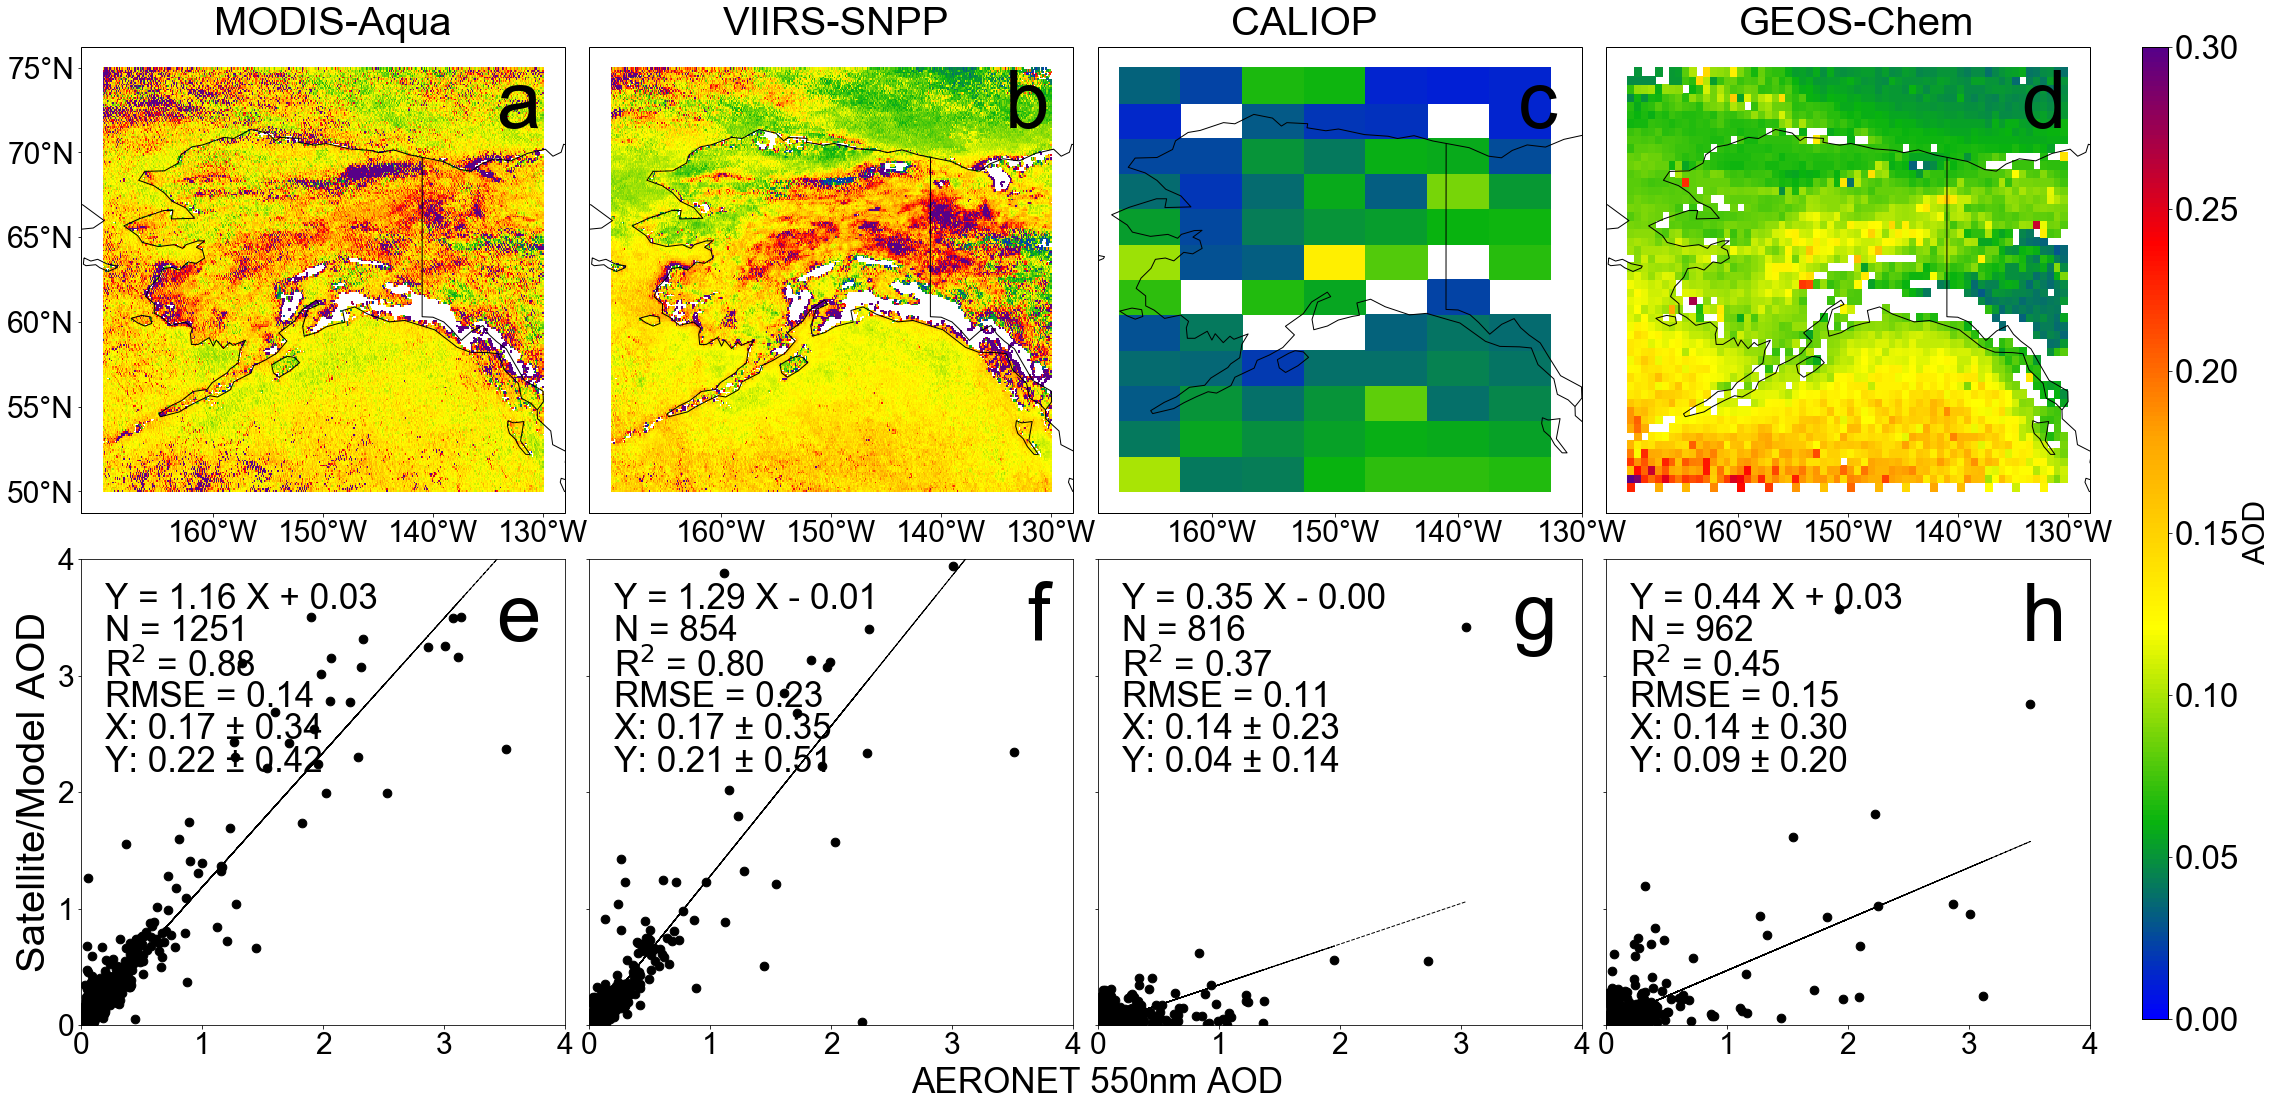

In [343]:
############################################
#           Figure 3
############################################


import matplotlib.gridspec as gridspec
import matplotlib.ticker
from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant


from matplotlib.colors import LinearSegmentedColormap
# Define the colormap
# Define the colormap
colors = [(0.0, '#330066'),   # Dark violet
          (0.02, '#1a1a8c'),   # Indigo
          (0.04, '#0033b3'),   # Deep blue
          (0.06, '#0066cc'),   # Blue
          (0.08, '#0099ff'),   # Light blue
          (0.1, '#00ccff'),  # Cyan
          (0.15, '#00FFFF'),   # Aqua/Cyan
          (0.2, '#00ffcc'),  # Turquoise
          (0.25, '#00cc99'),   # Teal
          (0.3, '#00cc66'),  # Greenish
          (0.35, '#00ff00'),   # Green
          (0.4, '#66ff33'),  # Light green
          (0.5, '#99ff33'),   # Lime green
          (0.6, '#ccff33'),  # Yellow-green
          (0.7, '#ffff00'),   # Yellow
          (0.8, '#ffcc00'),  # Yellow-orange
          (1.0, '#FF0000')]   # Red


cmap_new = LinearSegmentedColormap.from_list('my_colormap', colors)

##############################
# Spatial pattern figure code
# fireyear = np.array([2005, 2009, 2013, 2015, 2017, 2019])
fireyear = np.array([2005,2006,2007,2008, 2009,
                     2010,2011,2012,2013,2014, 2015,
                     2016,2017,2018, 2019])

VIIRS_DB_AOD_550_AVG_AK_monthly_fireyear = sel_yearlist( VIIRS_DB_AOD_550_AVG_AK_monthly, fireyear)
MYD04_L3_AOD_550_AVG_AK_monthly_fireyear = sel_yearlist( MYD04_L3_AOD_550_AVG_AK_monthly, fireyear)
AOD_GC_05to19_noon_daily_monthly_fireyear = sel_yearlist( AOD_GC_05to19_noon_daily_monthly, fireyear)
CALIPSO_AOD_532_AK_2x5_fireyear = sel_yearlist( CALIPSO_AOD_532_AK_2x5, fireyear)

MYD04_L3_AOD_550_AVG_AK_monthly_2x5_fireyear = sel_yearlist( MYD04_L3_AOD_550_AVG_AK_monthly_2x5, fireyear)
##############################

# Your custom functions and data loading here
fontnum = 35

# Create a new figure with size (36, 10)
fig = plt.figure(figsize=(36, 18))

# Create a 2x4 GridSpec for the merged figure
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], hspace=0.1, wspace=0.05)

##############################################################################################
#               Pattern  plot   
##############################################################################################
mask_MYD04_L3_AOD_550_AVG_AK_monthly = ~np.isnan(MYD04_L3_AOD_550_AVG_AK_monthly)*1
# mask_VIIRS_DB_AOD_550_AVG_AK_monthly = ~np.isnan(VIIRS_DB_AOD_550_AVG_AK_monthly)*1
mask_SAT = mask_MYD04_L3_AOD_550_AVG_AK_monthly
mask_SAT = mask_SAT.where(mask_SAT==1)

mask_MYD04_L3_AOD_550_AVG_AK_monthly_050625 = ~np.isnan(MYD04_L3_AOD_550_AVG_AK_monthly_050625)*1
# mask_VIIRS_DB_AOD_550_AVG_AK_monthly_050625 = ~np.isnan(mask_VIIRS_DB_AOD_550_AVG_AK_monthly_050625)*1
mask_SAT_050625 = mask_MYD04_L3_AOD_550_AVG_AK_monthly_050625
mask_SAT_050625 = mask_SAT_050625.where(mask_SAT_050625==1)

mask_MYD04_L3_AOD_550_AVG_AK_monthly_2x5 = ~np.isnan(MYD04_L3_AOD_550_AVG_AK_monthly_2x5)*1
# mask_VIIRS_DB_AOD_550_AVG_AK_monthly_2x5 = ~np.isnan(mask_VIIRS_DB_AOD_550_AVG_AK_monthly_2x5)*1
mask_SAT_2x25 = mask_MYD04_L3_AOD_550_AVG_AK_monthly_2x5
mask_SAT_2x25 = mask_SAT_2x25.where(mask_SAT_2x25==1)





varlist = [
#     AOD_GC_05to19_noon_daily_monthly * (1/0.695),
#     MYD04_L3_AOD_550_AVG_AK_monthly * (1/1.268),
#     VIIRS_DB_AOD_550_AVG_AK_monthly * (1/1.393),
#     CALIPSO_AOD_532_AK * (1/0.152)
    MYD04_L3_AOD_550_AVG_AK_monthly * mask_SAT,
    VIIRS_DB_AOD_550_AVG_AK_monthly * mask_SAT,
    CALIPSO_AOD_532_AK_2x5 * mask_SAT_2x25,
    AOD_GC_05to19_noon_daily_monthly * mask_SAT_050625
]

tmp_x, tmp_y = xr.align(VIIRS_DB_AOD_550_AVG_AK_monthly, CALIPSO_AOD_532_AK_2x5)
tmp_x2, tmp_y2 = xr.align(AOD_GC_05to19_noon_daily_monthly, tmp_y)

for ipanel in range(4):
    tmp = varlist[ipanel].loc[tmp_x2.time].mean(dim='time')
    ax = fig.add_subplot(gs[0, ipanel], projection=ccrs.PlateCarree(), aspect='auto')
    im = ax.pcolormesh(tmp.lon, tmp.lat, tmp, vmin=0, vmax=0.3, cmap=cmaps.BlGrYeOrReVi200)
    
#     # add AERONET points and AOD
#     if ipanel==0:
#         im_pa = ax.scatter(AERONET_latlon_list[:,1], AERONET_latlon_list[:,0],
# #                 c=PurpleAir_data_AK_19_A_available_corrected_df.resample('M').mean().values[2, :].tolist(),
#                 c='k',
#                 marker='x', lw=4, s=400, edgecolors='k', vmin=0, vmax=0.3)  # [2,:] means July avg 
    
    # Add lat lon labels
    if ipanel in [0,1,2,3]:
        ax.set_xticks([-160, -150, -140, -130], crs=ccrs.PlateCarree())
    if ipanel in [0]:
        ax.set_yticks([50, 55, 60, 65, 70, 75], crs=ccrs.PlateCarree())
    ax.set_xticklabels([-160, -150, -140, -130], fontsize=30)
    ax.set_yticklabels([50, 55, 60, 65, 70, 75], fontsize=30)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)

    # Add colorbar
    cbformat = matplotlib.ticker.ScalarFormatter()
    cbformat.set_powerlimits((0, 0.3))
    position = fig.add_axes([0.92, 0.13, 0.01, 0.75])
    cb = fig.colorbar(im, cax=position, orientation='vertical', format=cbformat)
    cb.set_label("AOD", fontsize=30)
    cb.ax.tick_params(labelsize=33)
    
    # Specify the custom tick locations for the colorbar
    ticks = np.arange(0,0.35,0.05)
    # Format the tick labels with the desired number of significant figures
    tick_labels = ['{:.2f}'.format(tick) for tick in ticks]
    cb.set_ticks( ticks )
    cb.set_ticklabels( tick_labels )
    
    # Add panel letters
    ax.text(0.95, 0.95, f"{chr(ord('a') + ipanel)}", transform=ax.transAxes, fontsize=80, fontweight='bold', verticalalignment='top', horizontalalignment='right')









# Scatterplot figure code

# for i, (x_data, y_data, title, ylabel) in enumerate(zip(
#     [AERONET_Bonanza_Creek_HiR_AOD550nm_hourly, AERONET_Bonanza_Creek_HiR_AOD550nm_noon_daily, AERONET_Bonanza_Creek_HiR_AOD550nm_noon_daily, sel_land( MYD04_L3_AOD_550_AVG_AK_monthly_2x5[5:]).values.flatten()* (1/1.268) ],\
#     [AOD_GC_05to19_BonanzaCreek, MYD04_L3_AOD_550_AVG_AK_daily_BonanzaCreek, VIIRS_DB_AOD_550_AVG_AK_daily_BonanzaCreek, sel_land( CALIPSO_AOD_532_AK_2x5).values.flatten()],\
for i, (x_data, y_data, title, ylabel) in enumerate(zip(
    [AERONET_allsites_HiR_AOD550nm_noon_daily_list,\
     AERONET_allsites_HiR_AOD550nm_noon_daily_list,\
     sel_land( MYD04_L3_AOD_550_AVG_AK_monthly_2x5[5:]).values.flatten()* (1/1.151)  ,\
     AERONET_allsites_HiR_AOD550nm_hourly_list],\
    
    [MYD04_L3_AOD_550_AVG_AK_daily_allsites_list,\
     VIIRS_DB_AOD_550_AVG_AK_daily_allsites_list,\
     sel_land( CALIPSO_AOD_532_AK_2x5).values.flatten() ,\
     AOD_GC_allsites_HiR_AOD550nm_list],\
    
    ["MODIS-Aqua", "VIIRS-SNPP", "CALIOP", "GEOS-Chem"],\
    ["", "", "", ""]
)):
    # Align the data and resample if necessary
    if type(x_data) == xr.DataArray and type(y_data) == xr.DataArray:
        tmp_x, tmp_y = xr.align(x_data, y_data)
    elif(i in [0,1]):
        tmp_x, tmp_y = align_and_concat_timeseries(x_data, y_data)
        tmp_x = tmp_x.flatten()
        tmp_y = tmp_y.flatten()
    elif(i in [3]):
        tmp_x, tmp_y = align_and_concat_timeseries(x_data, y_data, 'GChourly')
        tmp_x = tmp_x.flatten()
        tmp_y = tmp_y.flatten()
    else:
        tmp_x = x_data
        tmp_y = y_data

#     if i == 0:
#         tmp_x = tmp_x.resample(time='1D').mean(dim='time')
#         tmp_y = tmp_y.resample(time='1D').mean(dim='time')

    # Create a subplot
    ax = plt.subplot(gs[i+4])

    # Plot the scatter data
    ax.scatter(tmp_x, tmp_y, marker='.', color='k', s=300)
    ax.set_xticks(np.arange(0, 5, 1))
    if i != 0:
        ax.set_yticklabels([])
    
    # Plot the 1:1 line
#     ax.plot(tmp_x, tmp_x, linewidth=0.5)

    # Set the limits
#     ax.set_xlim([0, 4 if i != 3 else 0.5])
#     ax.set_ylim([0, 4 if i != 3 else 0.5])
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 4])
    
    if i == 0:
        ax.set_ylabel("Satellite/Model AOD", fontsize=40)
        ax.xaxis.set_label_coords(0.5, -0.15)


    # Set the labels and titles
#     ax.set_title(title, fontsize=40, fontweight='bold', location=(1,0.5))
    ax.text(1.1, 8.5, title, fontsize=40, fontweight='bold')
    ax.set_xlabel(ylabel, fontsize=33)
    
    # Convert xarray DataArrays to NumPy arrays and remove NaN values
    if type(tmp_x) == xr.DataArray and type(tmp_y) == xr.DataArray:
        tmp_x_np = tmp_x.values
        tmp_y_np = tmp_y.values
    else:
        tmp_x_np = tmp_x
        tmp_y_np = tmp_y
        
    mask = ~np.isnan(tmp_x_np) & ~np.isnan(tmp_y_np)
    tmp_x_np = tmp_x_np[mask]
    tmp_y_np = tmp_y_np[mask]

    # Calculate SMA regression and statistics
    X = add_constant(tmp_x_np)
    model = OLS(tmp_y_np, X).fit()
    k, b = model.params[1], model.params[0]
    r_squared = model.rsquared
    rmse = np.sqrt(np.mean((tmp_y_np - (k * tmp_x_np + b))**2))
    n_points = len(tmp_x_np)
    
    xmean = np.mean(tmp_x_np)
    xstd = np.std(tmp_x_np)
    ymean = np.mean(tmp_y_np)
    ystd = np.std(tmp_y_np)
    
    # plot SMA regression line
    ax.plot(tmp_x, tmp_x * k + b, linewidth=1, color='k', linestyle='--')
    

    # Add text to the top left corner of each panel
    if b>=0:
        ax.text(0.05, 0.95, f"Y = {k:.2f} X + {b:.2f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')
    else:
        ax.text(0.05, 0.95, f"Y = {k:.2f} X - {-b:.2f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')        
    ax.text(0.05, 0.88, f"N = {n_points}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')
    ax.text(0.05, 0.81, f"R$^2$ = {r_squared:.2f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')
    ax.text(0.05, 0.74, f"RMSE = {rmse:.2f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')
    ax.text(0.05, 0.67, f"X: {xmean:.2f} ± {xstd:.2f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')
    ax.text(0.05, 0.60, f"Y: {ymean:.2f} ± {ystd:.2f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')

    if i == 2:
        ax.text(0.0, -0.5, 'AERONET 550nm AOD', ha='center', va='center', fontsize=35)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=30)
    
    # Add panel letters
    ax.text(0.95, 0.95, f"{chr(ord('e') + i)}", transform=ax.transAxes, fontsize=80, fontweight='bold', verticalalignment='top', horizontalalignment='right')


    
    
    



# Adjust layout
fig.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=-0.5)



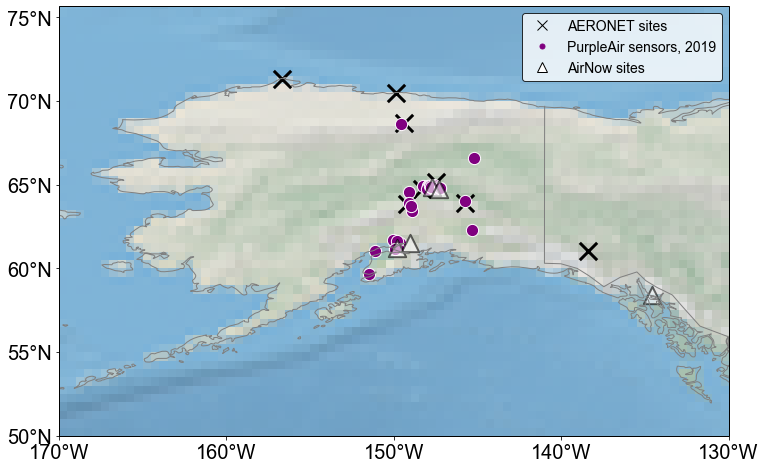

In [344]:
############################################
#              Figure 1
############################################


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
# Put a background image on for nice sea rendering.
ax.stock_img()
ax.set_extent([-170, -130, 50, 75, ])


# add AERONET points and AOD


ax.set_xticks([-170, -160, -150, -140, -130], crs=ccrs.PlateCarree())
ax.set_yticks([50, 55, 60, 65, 70, 75], crs=ccrs.PlateCarree())
ax.set_xticklabels([-170, -160, -150, -140, -130], fontsize=20)
ax.set_yticklabels([50, 55, 60, 65, 70, 75], fontsize=20)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.add_feature(cfeature.BORDERS, edgecolor='gray',)        
land_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                        edgecolor='gray',
                                        facecolor='none')
ax.add_feature(land_50m)

# -------------------------------------------------------------------------------------

im_aeronet = ax.scatter(AERONET_latlon_list[:,1], AERONET_latlon_list[:,0],
        c='k',
        marker='x', lw=3, s=300, edgecolors='k', vmin=0, vmax=0.3)  # [2,:] means July avg 

im_pa = ax.scatter(PA_IDs_AK_avail_19["longitude"].tolist(), PA_IDs_AK_avail_19["latitude"].tolist(),
        marker='.', lw=1,  facecolors= 'purple', s=600, edgecolors='white', vmin=0, vmax=100)  # [2,:] means July avg



DEC_latlon_list = [
    [64.846, -147.727],\
    [61.206, -149.824],\
    [61.534163,-149.031655],\
    [58.388497,-134.567237],\
    [64.762641,-147.310279],\
]

# im_dec = ax.scatter(np.array(DEC_latlon_list)[:,1].tolist(), np.array(DEC_latlon_list)[:,0].tolist(),
#                 marker='^', lw=2, c=['red','green','cyan','orange','gray'],alpha=0.6, s=300, edgecolors='k', vmin=0, vmax=100)  # [2,:] means July avg
im_dec = ax.scatter(np.array(DEC_latlon_list)[:,1].tolist(), np.array(DEC_latlon_list)[:,0].tolist(),
                    marker='^', lw=2  ,alpha=0.6, s=300, vmin=0, vmax=100,\
                    facecolors= 'white', edgecolors='k')  # [2,:] means July avg




import matplotlib.lines as mlines

# Create custom legend handles for each scatter plot
aeronet_legend = mlines.Line2D([], [], color='k', marker='x', lw=0, markersize=10, label='AERONET sites')
pa_legend = mlines.Line2D([], [], color='purple', marker='.', lw=0, markersize=10, label='PurpleAir sensors, 2019')
dec_legend = mlines.Line2D([], [], marker='^', lw=0, markersize=10, label='AirNow sites', color='white', markeredgecolor='k')

# Add the legend to the plot
ax.legend(handles=[aeronet_legend, pa_legend, dec_legend], loc='upper right', fontsize=14)

# Adjust the legend's appearance if needed
legend = ax.legend(handles=[aeronet_legend, pa_legend, dec_legend], loc='upper right', fontsize=14)
legend.get_frame().set_facecolor('white')  # Set legend background color
legend.get_frame().set_edgecolor('black')  # Set legend border color




In [348]:
factor_AOD_GC =  (1/0.44)
factor_AOD_MYD04 =  (1/1.155)
factor_AOD_VIIRS =  (1/1.307)
factor_AOD_CALIPSO = (1/0.349)
# factor_PM25_PurpleAir = (1/1.909)
factor_PM25_PurpleAir = (1.0/0.85)

In [349]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant




fontnum = 22

def add_text(ax, x, y, color=None):
    # Remove NaN values
    valid_data = ~np.isnan(x) & ~np.isnan(y)
    x_clean, y_clean = x[valid_data], y[valid_data]
    
    # Perform OLS regression
    X = add_constant(x_clean)
    model = OLS(y_clean, X).fit()
    slope_ols, intercept_ols = model.params[1], model.params[0]
    r_squared = model.rsquared
    r = np.sqrt(r_squared)
    rmse = np.sqrt(np.mean((y_clean - (slope_ols * x_clean + intercept_ols))**2))

    ols_equation = f"Y = {slope_ols:.2f}X + {intercept_ols:.2f}"
    n_points = f"N = {len(x_clean)}"
    r_squared_text = f"R^2 = {r_squared:.2f}"
    rmse_text = f"RMSE = {rmse:.2f}"
    
    # Add text to the top left corner of each panel
    if intercept_ols>=0:
        ax.text(0.05, 0.95, f"Y = {slope_ols:.3f} X + {intercept_ols:.3f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')
    else:
        ax.text(0.05, 0.95, f"Y = {slope_ols:.3f} X - {-intercept_ols:.3f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')        
    ax.text(0.05, 0.88, f"{n_points}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')
#     ax.text(0.05, 0.81, f"R$^2$ = {r_squared:.3f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')
    ax.text(0.05, 0.81, f"R = {r:.3f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')
    ax.text(0.05, 0.73, f"RMSE = {rmse:.3f}", transform=ax.transAxes, fontsize=fontnum, verticalalignment='top', family='Arial')


    # Plot OLS regression line
    line_color = color if color is not None else 'k'
    ax.plot(x_clean, slope_ols * x_clean + intercept_ols, linewidth=1, color=line_color, linestyle='-')



# Align data
x1, y1 = xr.align(DEC_NCORE_88101_PM25_da_daily, PM25_surf_GC_05to19_daily_NCORE)
x2, y2 = xr.align(DEC_Garden_88101_PM25_da_daily, PM25_surf_GC_05to19_daily_Garden)
x3, y3 = xr.align(DEC_NCORE_88101_PM25_da_daily, PurpleAir_data_AK_A_NCORE_da[PurpleAir_data_AK_A_NCORE_da.time.dt.year==2019])
x4, y4 = xr.align(DEC_Garden_88101_PM25_da_daily, PurpleAir_data_AK_A_Garden_da[PurpleAir_data_AK_A_Garden_da.time.dt.year==2019])

# Combine data for the regression and text values calculation
x_gc, y_gc = np.concatenate((x1, x2)), np.concatenate((y1, y2))
x_pa, y_pa = np.concatenate((x3, x4)), np.concatenate((y3, y4))

In [1]:
# Create a figure with a 2x2 grid
fig = plt.figure(figsize=(22, 6))
# Create a 2x2 grid
gs = gridspec.GridSpec(2, 2, width_ratios=[0.5, 0.5,], height_ratios=[1,1], hspace=0.1, wspace=0.1)
# gs = gridspec.GridSpec(1, 3, width_ratios=[0.5,0.5,1.15], height_ratios=[1], hspace=0.0)

# Add the 1x2 scatterplot to the first row
ax1 = plt.subplot(gs[0], aspect=1)
ax2 = plt.subplot(gs[1], aspect=1)
ax3 = plt.subplot(gs[2], aspect=1)

# Align data

aod1, x1, y1 = xr.align(AOD_GC_05to19_noon_daily_NCORE * factor_AOD_GC,     DEC_NCORE_88101_PM25_da_daily, PM25_surf_GC_05to19_daily_NCORE)
aod2, x2, y2 = xr.align(AOD_GC_05to19_noon_daily_Garden * factor_AOD_GC,     DEC_Garden_88101_PM25_da_daily, PM25_surf_GC_05to19_daily_Garden)
aod3, x3, y3 = xr.align(AOD_GC_05to19_noon_daily_Butte * factor_AOD_GC,     DEC_Butte_88101_PM25_da_daily, PM25_surf_GC_05to19_daily_Butte)
aod4, x4, y4 = xr.align(AOD_GC_05to19_noon_daily_FloydDrydenMiddleSchool * factor_AOD_GC,     DEC_FloydDrydenMiddleSchool_88101_PM25_da_daily, PM25_surf_GC_05to19_daily_FloydDrydenMiddleSchool)
aod5, x5, y5 = xr.align(AOD_GC_05to19_noon_daily_HurstRoad * factor_AOD_GC,     DEC_HurstRoad_88501_PM25_da_daily, PM25_surf_GC_05to19_daily_HurstRoad)

fire_aod = 0.5
nofire_aod = 0.1
x1_F, y1_F,  x1_NF, y1_NF = x1[aod1>fire_aod], y1[aod1>fire_aod],   x1[aod1<nofire_aod], y1[aod1<nofire_aod]
x2_F, y2_F,  x2_NF, y2_NF = x2[aod2>fire_aod], y2[aod2>fire_aod],   x2[aod2<nofire_aod], y2[aod2<nofire_aod]
x3_F, y3_F,  x3_NF, y3_NF = x3[aod3>fire_aod], y3[aod3>fire_aod],   x3[aod3<nofire_aod], y3[aod3<nofire_aod]
x4_F, y4_F,  x4_NF, y4_NF = x4[aod4>fire_aod], y4[aod4>fire_aod],   x4[aod4<nofire_aod], y4[aod4<nofire_aod]
x5_F, y5_F,  x5_NF, y5_NF = x5[aod5>fire_aod], y5[aod5>fire_aod],   x5[aod5<nofire_aod], y5[aod5<nofire_aod]


x6, y6 = xr.align(DEC_NCORE_88101_PM25_da_daily, PurpleAir_data_AK_A_NCORE_da)
x7, y7 = xr.align(DEC_Garden_88101_PM25_da_daily, PurpleAir_data_AK_A_Garden_da)
x8, y8 = xr.align(DEC_Butte_88101_PM25_da_daily, PurpleAir_data_AK_A_Butte_da)
x9, y9 = xr.align(DEC_FloydDrydenMiddleSchool_88101_PM25_da_daily, PurpleAir_data_AK_A_FloydDrydenMiddleSchool_da)
x10, y10 = xr.align(DEC_HurstRoad_88501_PM25_da_daily, PurpleAir_data_AK_A_HurstRoad_da)



# Combine data for the regression and text values calculation
x_gc, y_gc = np.concatenate((x1, x2, x3, x4, x5)), np.concatenate((y1, y2, y3, y4, y5))
x_pa, y_pa = np.concatenate((x6, x7, x8, x9, x10)), np.concatenate((y6, y7, y8, y9, y10))
# Combine data for the regression and text values calculation
x_gc_F, y_gc_F = np.concatenate((x1_F, x2_F, x3_F, x4_F, x5_F)), np.concatenate((y1_F, y2_F, y3_F, y4_F, y5_F))
x_gc_NF, y_gc_NF = np.concatenate((x1_NF, x2_NF, x3_NF, x4_NF, x5_NF)), np.concatenate((y1_NF, y2_NF, y3_NF, y4_NF, y5_NF))




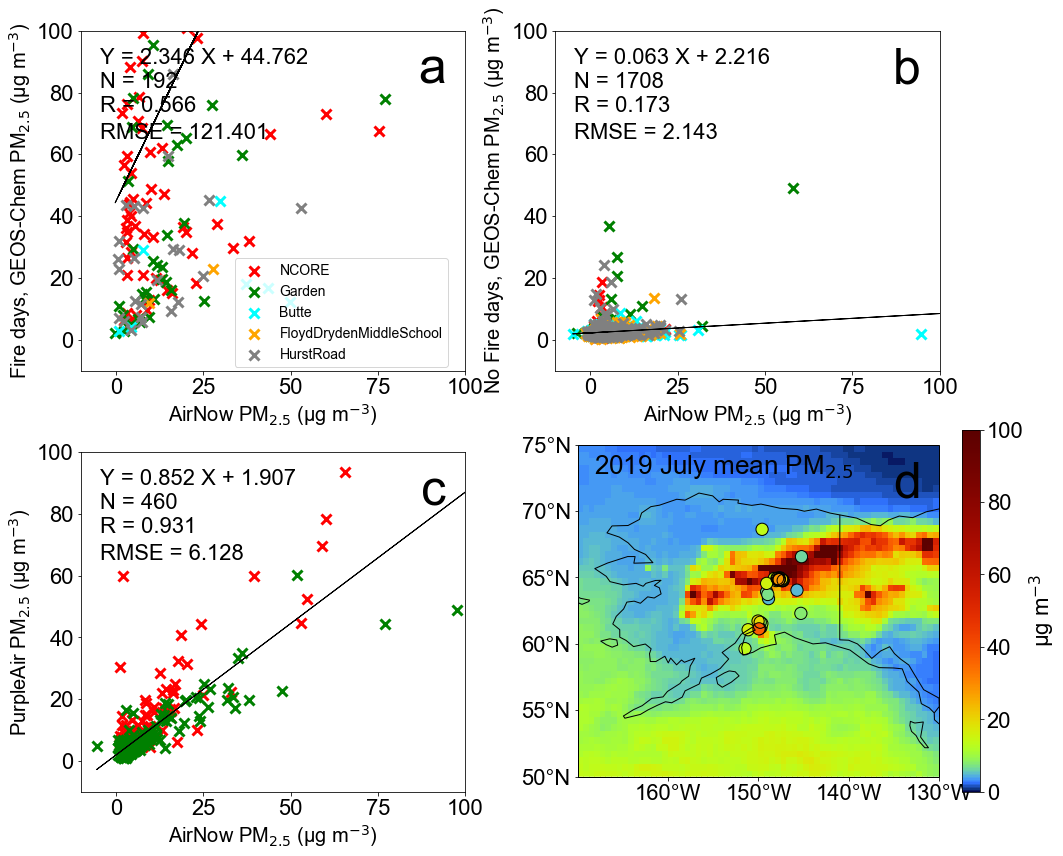

In [359]:
############################################
#              Figure 4
############################################


import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define your function add_text() and other necessary functions/data here

# Create a figure with a 2x2 grid using plt.subplots and gridspec_kw for better control
fig, axs = plt.subplots(2, 3, figsize=(17, 14), gridspec_kw={'width_ratios': [1, 1, 0], 'height_ratios': [1, 1], 'hspace': 0.24, 'wspace': 0.35})
# Hide the panel box of the third column
axs[0, 2].axis('off')
axs[1, 2].axis('off')


# Define your axes
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
ax_cb = axs[1,2]

# Align data
# (Your data alignment code here...)

# Scatterplot for GEOS-Chem under strong wildfire conditions
ax1.scatter(x1_F, y1_F, marker='x', s=100, lw=3, alpha=1, color='red', label='NCORE')
ax1.scatter(x2_F, y2_F, marker='x', s=100, lw=3, alpha=1, color='green', label='Garden')
ax1.scatter(x3_F, y3_F, marker='x', s=100, lw=3, alpha=1, color='cyan', label='Butte')
ax1.scatter(x4_F, y4_F, marker='x', s=100, lw=3, alpha=1, color='orange', label='FloydDrydenMiddleSchool')
ax1.scatter(x5_F, y5_F, marker='x', s=100, lw=3, alpha=1, color='gray', label='HurstRoad')
ax1.legend(loc=(1.37,0.01), fontsize=14)
ax1.legend(loc=(0.4,0.01), fontsize=14)
ax1.set_zorder(100)
add_text(ax1, x_gc_F, y_gc_F)

# Scatterplot for GEOS-Chem under non-fire conditions
ax2.scatter(x1_NF, y1_NF, marker='x', s=100, lw=3, alpha=1, color='red', label='NCORE')
ax2.scatter(x2_NF, y2_NF, marker='x', s=100, lw=3, alpha=1, color='green', label='Garden')
ax2.scatter(x3_NF, y3_NF, marker='x', s=100, lw=3, alpha=1, color='cyan', label='Butte')
ax2.scatter(x4_NF, y4_NF, marker='x', s=100, lw=3, alpha=1, color='orange', label='FloydDrydenMiddleSchool')
ax2.scatter(x5_NF, y5_NF, marker='x', s=100, lw=3, alpha=1, color='gray', label='HurstRoad')
add_text(ax2, x_gc_NF, y_gc_NF)

# Scatterplot for PurpleAir data
ax3.scatter(x6, y6, marker='x', s=100, lw=3, alpha=1, color='red', label='NCORE')
ax3.scatter(x7, y7, marker='x', s=100, lw=3, alpha=1, color='green', label='Garden')
ax3.scatter(x8, y8, marker='x', s=100, lw=3, alpha=1, color='cyan', label='Butte')
ax3.scatter(x9, y9, marker='x', s=100, lw=3, alpha=1, color='orange', label='FloydDrydenMiddleSchool')
ax3.scatter(x10, y10, marker='x', s=100, lw=3, alpha=1, color='gray', label='HurstRoad')
add_text(ax3, x_pa, y_pa)

# Setting labels and limits
ax1.set_ylabel("Fire days, GEOS-Chem PM${_{2.5}}$ (µg m${^{-3} }$)", fontsize=20)
ax1.set_xlabel("AirNow PM${_{2.5}}$ (µg m${^{-3} }$)", fontsize=20)
ax1.set_xlim(-10, 100)
ax1.set_ylim(-10, 100)

ax2.set_ylabel("No Fire days, GEOS-Chem PM${_{2.5}}$ (µg m${^{-3} }$)", fontsize=20)
ax2.set_xlabel("AirNow PM${_{2.5}}$ (µg m${^{-3} }$)", fontsize=20)
ax2.set_xlim(-10, 100)
ax2.set_ylim(-10, 100)

ax3.set_ylabel("PurpleAir PM${_{2.5}}$ (µg m${^{-3} }$)", fontsize=20)
ax3.set_xlabel("AirNow PM${_{2.5}}$ (µg m${^{-3} }$)", fontsize=20)
ax3.set_xlim(-10, 100)
ax3.set_ylim(-10, 100)



fig.text(0.65, 0.44, '2019 July mean PM${_{2.5}}$', ha='center', fontsize=26)
# Map plot for 2019 July mean PM2.5
ax4 = plt.subplot(gs[1, 1], aspect=1.47, projection=ccrs.PlateCarree())
tmp = sel_July(PM25_surf_GC_05to19_daily_monthly_median[PM25_surf_GC_05to19_daily_monthly_median.time.dt.year==2019]).mean(dim='time')
im = ax4.pcolormesh(tmp.lon, tmp.lat, tmp, vmin=0, vmax=100, cmap=cmaps.hotres)


# Scatter plot of monthly PurpleAir locations on the map
# im_pa = ax4.scatter(filtered_pa_ids["longitude"].tolist(), filtered_pa_ids["latitude"].tolist(),
#                 c=filtered_pa_data.resample('M').mean().values[2, :].tolist(),
#                 marker='o', lw=2, cmap=cmaps.BlueYellowRed, s=150, edgecolors='k', vmin=0, vmax=100)


# Calculate sizes based on the values
sizes = filtered_pa_data.resample('M').median().values[2, :].tolist()
# Sort the data based on the sizes
sorted_indices = np.argsort(sizes)
# Plot the scatter plot, larger values will be plotted on top
im_pa = ax4.scatter(
    np.array(filtered_pa_ids["longitude"].tolist())[sorted_indices],
    np.array(filtered_pa_ids["latitude"].tolist())[sorted_indices],
    c=np.array(sizes)[sorted_indices],
    marker='o', lw=1, cmap=cmaps.hotres, s=150, edgecolors='k', vmin=0, vmax=100
)




cbar = fig.colorbar(im, ax=ax4, orientation='vertical', shrink=1)
cbar.set_label('µg m${^{-3} }$')



# Add colorbar
# cbformat = matplotlib.ticker.ScalarFormatter()
# cbformat.set_powerlimits((0, 10))
# position = fig.add_axes([0.92, 0.23, 0.01, 0.1])
# cb = fig.colorbar(im, cax=position, orientation='vertical', format=cbformat)
# cb.set_label("µg m${^{-3} }$", fontsize=30)
# cb.ax.tick_params(labelsize=33)
 


# Add lat/lon labels and features
ax4.set_xticks([-160, -150, -140, -130], crs=ccrs.PlateCarree())
ax4.set_yticks([50, 55, 60, 65, 70, 75], crs=ccrs.PlateCarree())
ax4.xaxis.set_major_formatter(LongitudeFormatter())
ax4.yaxis.set_major_formatter(LatitudeFormatter())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS)

# plt.title("2019 July mean PM${_{2.5}}$", fontsize=20)
plt.ylim([50, 75])
plt.xlim([-170, -130])

# Add panel labels
ax1.text(0.95, 0.95, 'a', transform=ax1.transAxes, fontsize=50, va='top', ha='right', weight='bold')
ax2.text(0.95, 0.95, 'b', transform=ax2.transAxes, fontsize=50, va='top', ha='right', weight='bold')
ax3.text(0.95, 0.95, 'c', transform=ax3.transAxes, fontsize=50, va='top', ha='right', weight='bold')
ax4.text(0.95, 0.95, 'd', transform=ax4.transAxes, fontsize=50, va='top', ha='right', weight='bold')

plt.tight_layout()
plt.show()


In [20]:
#########################################################################
#       Calculate GEOS-Chem monthly slope from 2005 to 2019
#########################################################################

daynum_bounds_monthly = "monthly"
slopes_GC_monthly_list = []

for iyear in range(2005,2020):
    tmp_PM25 = PM25_surf_GC_05to19_daily[PM25_surf_GC_05to19_daily.time.dt.year==iyear]
    tmp_AOD = AOD_GC_05to19_noon_daily[AOD_GC_05to19_noon_daily.time.dt.year==iyear]
    tmp_PM25,tmp_AOD = xr.align(tmp_PM25,tmp_AOD, join='inner')
#     tmp_PM25 = tmp_PM25.fillna(0)
#     tmp_AOD = tmp_AOD.fillna(0)
    tmp = slope_GC_periods(tmp_PM25, tmp_AOD, daynum_bounds_monthly)
    print(str(iyear))
    slopes_GC_monthly_list.append(tmp)
slopes_GC_monthly_da = xr.concat(slopes_GC_monthly_list, 'time')

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [21]:
#########################################################################
#       Calculate GEOS-Chem weekly slope from 2005 to 2019
#########################################################################

daynum_bounds_weekly = "weekly"
slopes_GC_weekly_list = []

for iyear in range(2005,2020):
    tmp_PM25 = PM25_surf_GC_05to19_daily[PM25_surf_GC_05to19_daily.time.dt.year==iyear]
    tmp_AOD = AOD_GC_05to19_noon_daily[AOD_GC_05to19_noon_daily.time.dt.year==iyear]
    tmp_PM25,tmp_AOD = xr.align(tmp_PM25,tmp_AOD, join='inner')
#     tmp_PM25 = tmp_PM25.fillna(0)
#     tmp_AOD = tmp_AOD.fillna(0)
    tmp = slope_GC_periods(tmp_PM25, tmp_AOD, daynum_bounds_weekly)
    print(str(iyear))
    slopes_GC_weekly_list.append(tmp)
slopes_GC_weekly_da = xr.concat(slopes_GC_weekly_list, 'time')


2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [33]:
daynum_bounds_weekly = "weekly"
slopes_GC_weekly_WFIH3565_list = []

for iyear in range(2019,2020):
    tmp_PM25 = PM25_surf_GC_19_WFIH3565_daily[PM25_surf_GC_19_WFIH3565_daily.time.dt.year==iyear][:,0,:,:]
    tmp_AOD = AOD_GC_19_WFIH3565_noon_daily[AOD_GC_19_WFIH3565_noon_daily.time.dt.year==iyear]
    tmp_PM25,tmp_AOD = xr.align(tmp_PM25,tmp_AOD, join='inner')
#     tmp_PM25 = tmp_PM25.fillna(0)
#     tmp_AOD = tmp_AOD.fillna(0)
    tmp = slope_GC_periods(tmp_PM25, tmp_AOD, daynum_bounds_weekly)
    print(str(iyear))
    slopes_GC_weekly_WFIH3565_list.append(tmp)
slopes_GC_weekly_WFIH3565_da = xr.concat(slopes_GC_weekly_WFIH3565_list, 'time')

2019


In [32]:
#----------------------------------------------------------------
#             GEOS-Chem inject 35% FT, 65% PBL
#----------------------------------------------------------------

#################################################################
#                         hourly
#################################################################
AOD_GC_19_WFIH3565 = xr.open_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/WF_IH/'+'AOD_19.nc',engine='netcdf4')["__xarray_dataarray_variable__"]
PM25_surf_GC_19_WFIH3565 = xr.open_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/WF_IH/'+'PM25_19.nc',engine='netcdf4')["PM25"]

#################################################################
#                         noon daily
#################################################################
tmp = AOD_GC_19_WFIH3565.loc[(AOD_GC_19_WFIH3565.time.dt.hour>=20) & (AOD_GC_19_WFIH3565.time.dt.hour<=23)]
AOD_GC_19_WFIH3565_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
AOD_GC_19_WFIH3565_noon_daily_monthly = AOD_GC_19_WFIH3565_noon_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
AOD_GC_19_WFIH3565_noon_daily_weekly = AOD_GC_19_WFIH3565_noon_daily.resample(time='1W').mean(dim='time').dropna(dim='time')

AOD_4D_GC_19_WFIH3565 = xr.open_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/WF_IH/'+'AOD_4D_19.nc',engine='netcdf4')["__xarray_dataarray_variable__"]
tmp = AOD_4D_GC_19_WFIH3565.loc[(AOD_4D_GC_19_WFIH3565.time.dt.hour>=20) & (AOD_4D_GC_19_WFIH3565.time.dt.hour<=23)]
AOD_4D_GC_19_WFIH3565_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
Met_BXHEIGHT_19_noon_daily = Met_BXHEIGHT_05to19_noon_daily.loc[(Met_BXHEIGHT_05to19_noon_daily.time.dt.year==2019)]
Met_PBLH_19_noon_daily = Met_PBLH_05to19_noon_daily.loc[(Met_PBLH_05to19_noon_daily.time.dt.year==2019)]
extcoef_19_WFIH3565_noon_daily = AOD_4D_GC_19_WFIH3565_noon_daily / (Met_BXHEIGHT_19_noon_daily * 1e-3)

extcoef_19_WFIH3565_noon_daily_monthly = extcoef_19_WFIH3565_noon_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
extcoef_19_WFIH3565_noon_daily_weekly = extcoef_19_WFIH3565_noon_daily.resample(time='1W').mean(dim='time').dropna(dim='time')


PM25_surf_GC_19_WFIH3565_daily = PM25_surf_GC_19_WFIH3565.resample(time='1D').mean(dim='time').dropna(dim='time')
PM25_surf_GC_19_WFIH3565_daily_monthly = PM25_surf_GC_19_WFIH3565_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
PM25_surf_GC_19_WFIH3565_daily_weekly = PM25_surf_GC_19_WFIH3565_daily.resample(time='1W').mean(dim='time').dropna(dim='time')


#----------------------------------------------------------------
#             GEOS-Chem inject 100% at PBLH
#----------------------------------------------------------------

#################################################################
#                         hourly
#################################################################
AOD_GC_19_WFIHPBLH = xr.open_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/WF_IH_PBLH/'+'AOD_19.nc',engine='netcdf4')["__xarray_dataarray_variable__"]
PM25_surf_GC_19_WFIHPBLH = xr.open_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/WF_IH/'+'PM25_19.nc',engine='netcdf4')["PM25"]

#################################################################
#                         noon daily
#################################################################
tmp = AOD_GC_19_WFIHPBLH.loc[(AOD_GC_19_WFIHPBLH.time.dt.hour>=20) & (AOD_GC_19_WFIHPBLH.time.dt.hour<=23)]
AOD_GC_19_WFIHPBLH_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
AOD_GC_19_WFIHPBLH_noon_daily_monthly = AOD_GC_19_WFIHPBLH_noon_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
AOD_GC_19_WFIHPBLH_noon_daily_weekly = AOD_GC_19_WFIHPBLH_noon_daily.resample(time='1W').mean(dim='time').dropna(dim='time')

AOD_4D_GC_19_WFIHPBLH = xr.open_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/WF_IH/'+'AOD_4D_19.nc',engine='netcdf4')["__xarray_dataarray_variable__"]
tmp = AOD_4D_GC_19_WFIHPBLH.loc[(AOD_4D_GC_19_WFIHPBLH.time.dt.hour>=20) & (AOD_4D_GC_19_WFIHPBLH.time.dt.hour<=23)]
AOD_4D_GC_19_WFIHPBLH_noon_daily = tmp.resample(time='1D').mean(dim='time').dropna(dim='time')
extcoef_19_WFIHPBLH_noon_daily = AOD_4D_GC_19_WFIHPBLH_noon_daily / (Met_BXHEIGHT_19_noon_daily * 1e-3)

extcoef_19_WFIHPBLH_noon_daily_monthly = extcoef_19_WFIHPBLH_noon_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
extcoef_19_WFIHPBLH_noon_daily_weekly = extcoef_19_WFIHPBLH_noon_daily.resample(time='1W').mean(dim='time').dropna(dim='time')


PM25_surf_GC_19_WFIHPBLH_daily = PM25_surf_GC_19_WFIHPBLH.resample(time='1D').mean(dim='time').dropna(dim='time')
PM25_surf_GC_19_WFIHPBLH_daily_monthly = PM25_surf_GC_19_WFIHPBLH_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
PM25_surf_GC_19_WFIHPBLH_daily_weekly = PM25_surf_GC_19_WFIHPBLH_daily.resample(time='1W').mean(dim='time').dropna(dim='time')



#----------------------------------------------------------------
#             GEOS-Chem inject 100% at surface
#----------------------------------------------------------------

#################################################################
#                         hourly and noon daily
#################################################################
AOD_GC_19_WFIHsurf = AOD_GC_05to19.loc[(AOD_GC_05to19.time.dt.year==2019)]
AOD_GC_19_WFIHsurf_noon_daily = AOD_GC_05to19_noon_daily.loc[(AOD_GC_05to19_noon_daily.time.dt.year==2019)]
AOD_GC_19_WFIHsurf_noon_daily_monthly = AOD_GC_05to19_noon_daily_monthly.loc[(AOD_GC_05to19_noon_daily_monthly.time.dt.year==2019)]
AOD_GC_19_WFIHsurf_noon_daily_weekly = AOD_GC_05to19_noon_daily_weekly.loc[(AOD_GC_05to19_noon_daily_weekly.time.dt.year==2019)]

extcoef_19_WFIHsurf_noon_daily = extcoef_05to19_noon_daily.loc[(extcoef_05to19_noon_daily.time.dt.year==2019)]
extcoef_19_WFIHsurf_noon_daily_monthly = extcoef_05to19_noon_daily_monthly.loc[(extcoef_05to19_noon_daily_monthly.time.dt.year==2019)]
extcoef_05to19_noon_daily_weekly = extcoef_19_WFIHsurf_noon_daily.resample(time='1W').mean(dim='time').dropna(dim='time')
extcoef_19_WFIHsurf_noon_daily_weekly = extcoef_05to19_noon_daily_weekly.loc[(extcoef_05to19_noon_daily_weekly.time.dt.year==2019)]

PM25_surf_GC_19_WFIHsurf_daily = PM25_surf_GC_05to19_daily.loc[(PM25_surf_GC_05to19_daily.time.dt.year==2019)]
PM25_surf_GC_19_WFIHsurf_monthly = PM25_surf_GC_05to19_daily_monthly.loc[(PM25_surf_GC_05to19_daily_monthly.time.dt.year==2019)]
PM25_surf_GC_05to19_daily_weekly = PM25_surf_GC_05to19_daily.resample(time='1W').mean(dim='time').dropna(dim='time')
PM25_surf_GC_19_WFIHsurf_weekly = PM25_surf_GC_05to19_daily_weekly.loc[(PM25_surf_GC_05to19_daily_weekly.time.dt.year==2019)]

In [245]:
#  CALIOP in initial grid (2x5), all years
#    calculate fPBL


# Calculate sum of CALIPSO_ext_532_AK where alt < Met_PBLH_05to19_noon_daily_monthly
sum_in_PBL = CALIPSO_ext_532_AK_2x5["ext"].where( (CALIPSO_ext_532_AK_2x5["ext"].alt) * 1e3 < Met_PBLH_05to19_noon_daily_monthly_2x5.where(CALIPSO_ext_532_AK_2x5.time), drop=False).sum(dim='alt')
# Calculate sum of CALIPSO_ext_532_AK in all alts
# sum_all_alt = CALIPSO_AOD_532_AK_fireyear/0.06
sum_all_alt = CALIPSO_ext_532_AK_2x5["ext"].sum(dim='alt')

# Avoid division by zero by adding a small number in the denominator
sum_all_alt = sum_all_alt.where( ((sum_all_alt - sum_in_PBL) > 0) & (sum_all_alt > 0 ), np.nan)
sum_in_PBL = sum_in_PBL.where(((sum_all_alt - sum_in_PBL) > 0) & (sum_all_alt > 0 ), np.nan)

# Calculate fraction of sum_in_PBL in sum_all_alt
CALIPSO_fPBLAOD_532_AK_2x5 = sum_in_PBL / sum_all_alt
CALIPSO_AOD_532_AK_2x5_integrated = sum_all_alt * 0.06


tmp = Met_BXHEIGHT_05to19_noon_daily_monthly.cumsum(dim='lev')

# Calculate sum of CALIPSO_ext_532_AK where alt < Met_PBLH_05to19_noon_daily_monthly
ext_in_PBL_GC = extcoef_05to19_noon_daily_monthly.where(tmp < Met_PBLH_05to19_noon_daily_monthly, drop=False)
BXH_in_PBL_GC = Met_BXHEIGHT_05to19_noon_daily_monthly.where(tmp < Met_PBLH_05to19_noon_daily_monthly, drop=False)
sum_in_PBL_GC = (ext_in_PBL_GC * BXH_in_PBL_GC).sum(dim='lev')
# Calculate sum of CALIPSO_ext_532_AK in all alts
sum_all_alt_GC = (extcoef_05to19_noon_daily_monthly*Met_BXHEIGHT_05to19_noon_daily_monthly).sum(dim='lev')

# Avoid division by zero by adding a small number in the denominator
sum_all_alt_GC = sum_all_alt_GC.where(sum_all_alt_GC > 0, np.nan)
# Calculate fraction of sum_in_PBL in sum_all_alt
fPBLAOD_05to19_noon_daily_monthly = sum_in_PBL_GC / sum_all_alt_GC








tmp = Met_BXHEIGHT_05to19_noon_daily_monthly.cumsum(dim='lev')

# Calculate sum of CALIPSO_ext_532_AK where alt < Met_PBLH_05to19_noon_daily_monthly
Met_PBLH_19_noon_daily_monthly = Met_PBLH_19_noon_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
ext_in_PBL_GC_WFIHsurf = extcoef_19_WFIHsurf_noon_daily_monthly.where(tmp < Met_PBLH_19_noon_daily_monthly, drop=False)

Met_BXHEIGHT_19_noon_daily_monthly = Met_BXHEIGHT_19_noon_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
BXH_in_PBL_GC_WFIHsurf = Met_BXHEIGHT_19_noon_daily.where(tmp < Met_PBLH_19_noon_daily_monthly, drop=False)
sum_in_PBL_GC_WFIHsurf = (ext_in_PBL_GC_WFIHsurf * BXH_in_PBL_GC_WFIHsurf).sum(dim='lev')
# Calculate sum of CALIPSO_ext_532_AK in all alts
sum_all_alt_GC_WFIHsurf = (extcoef_19_WFIHsurf_noon_daily_monthly * Met_BXHEIGHT_19_noon_daily_monthly).sum(dim='lev')

# Avoid division by zero by adding a small number in the denominator
sum_all_alt_GC_WFIHsurf = sum_all_alt_GC_WFIHsurf.where(sum_all_alt_GC_WFIHsurf > 0, np.nan)
# Calculate fraction of sum_in_PBL in sum_all_alt
fPBLAOD_19_WFIHsurf_noon_daily_monthly = sum_in_PBL_GC_WFIHsurf / sum_all_alt_GC_WFIHsurf









tmp = Met_BXHEIGHT_05to19_noon_daily_monthly.cumsum(dim='lev')

# Calculate sum of CALIPSO_ext_532_AK where alt < Met_PBLH_05to19_noon_daily_monthly
Met_PBLH_19_noon_daily_monthly = Met_PBLH_19_noon_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
ext_in_PBL_GC_WFIH3565 = extcoef_19_WFIH3565_noon_daily_monthly.where(tmp < Met_PBLH_19_noon_daily_monthly, drop=False)

Met_BXHEIGHT_19_noon_daily_monthly = Met_BXHEIGHT_19_noon_daily.resample(time='1MS').mean(dim='time').dropna(dim='time')
BXH_in_PBL_GC_WFIH3565 = Met_BXHEIGHT_19_noon_daily.where(tmp < Met_PBLH_19_noon_daily_monthly, drop=False)
sum_in_PBL_GC_WFIH3565 = (ext_in_PBL_GC_WFIH3565 * BXH_in_PBL_GC_WFIH3565).sum(dim='lev')
# Calculate sum of CALIPSO_ext_532_AK in all alts
sum_all_alt_GC_WFIH3565 = (extcoef_19_WFIH3565_noon_daily_monthly*Met_BXHEIGHT_19_noon_daily_monthly).sum(dim='lev')

# Avoid division by zero by adding a small number in the denominator
sum_all_alt_GC_WFIH3565 = sum_all_alt_GC_WFIH3565.where(sum_all_alt_GC_WFIH3565 > 0, np.nan)
# Calculate fraction of sum_in_PBL in sum_all_alt
fPBLAOD_19_WFIH3565_noon_daily_monthly = sum_in_PBL_GC_WFIH3565 / sum_all_alt_GC_WFIH3565

3
584      0.550598
649      0.509761
713      0.511945
714      0.567157
776      0.493546
           ...   
12695    0.113144
12696    0.140750
12697    0.138638
12698    0.107207
12699    0.107252
Name: f_PBLAOD, Length: 3504, dtype: float32
386      0.594420
515      0.608539
579      0.644329
580      0.589633
581      0.430910
           ...   
11341    0.461391
11537    0.493135
12217    0.471172
12283    0.531804
12284    0.488054
Name: f_PBLAOD, Length: 1072, dtype: float32
4649     0.499379
4650     0.460985
4710     0.368018
4713     0.604962
4714     0.538359
           ...   
9321     0.144402
9322     0.125450
9384     0.086130
11342    0.499114
12282    0.566060
Name: f_PBLAOD, Length: 400, dtype: float32
4711    0.634627
4712    0.646194
5300    0.579413
5568    0.615107
8135    0.421254
          ...   
8967    0.550169
8968    0.606888
8969    0.617514
9030    0.550136
9031    0.571754
Name: f_PBLAOD, Length: 233, dtype: float32
8817    0.558674
8818    0.565389
8966 

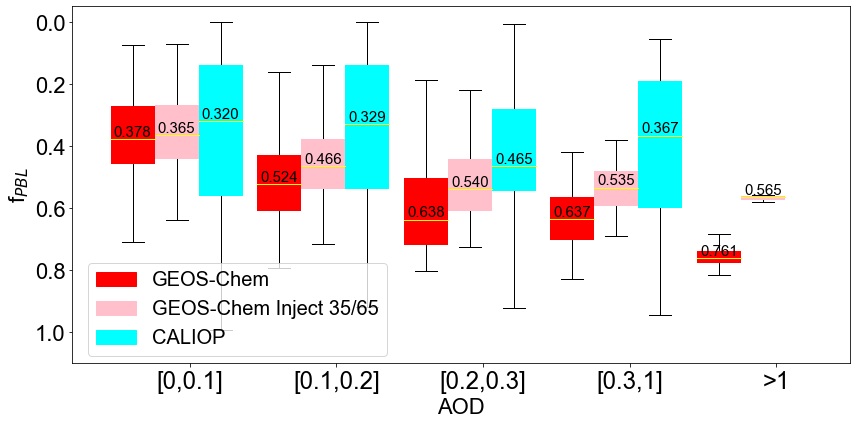

In [248]:
#######################################
#             Figure 6
#######################################



factor_AOD_GC =  (1/0.44)
factor_AOD_MYD04 =  (1/1.155)
factor_AOD_VIIRS =  (1/1.307)
factor_AOD_CALIPSO = (1/0.349)
# factor_PM25_PurpleAir = (1/1.909)
factor_PM25_PurpleAir = (1.0/0.85)



import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

def prepare_data(fPBL, AOD):
    x,y = xr.align(fPBL, AOD, join='inner')
    x=x.where(x>0)
    y=y.where(y>0)
    
    fPBL_list = sel_land(x).values.flatten()
    AOD_list = sel_land(y).values.flatten()
    return fPBL_list,AOD_list

def fPBLAOD_boxplot(f_PBLAODs, AODs, labels, colors, ax):

    
    # Create two DataFrames
    dfs = [pd.DataFrame({'f_PBLAOD': f_PBLAOD, 'AOD': AOD}) for f_PBLAOD, AOD in zip(f_PBLAODs, AODs)]

    # Create bins for AOD
    bins = [0, 0.1, 0.2, 0.3, 1, np.inf]
    bins_label = [0, 0.1, 0.2, 0.3, 0.4, np.inf]
    
    # Apply binning to each DataFrame
    for df in dfs:
        df['AOD_bin'] = pd.cut(df['AOD'], bins=bins)

    # Determine positions for boxplots
    base_positions = bins_label[:-1]  # Remove the last element
    n_dfs = len(dfs)
    print(n_dfs)

    # Create boxplots at the right positions
    for j, df in enumerate(dfs):
        offset = 0.03 * (j - n_dfs / 2 + 0.2)  # To shift boxes of different datasets
        for i, (bin_range, group) in enumerate(df.groupby('AOD_bin')):
            if len(group) > 1:
                position = [base_positions[i] + offset]
                if j==1:
                    print(group['f_PBLAOD'])
                    
                # Create a list to store non-NaN values for plotting
                non_nan_values = group['f_PBLAOD'].dropna().tolist()


                ax.boxplot(non_nan_values, positions=position, widths=0.03, 
                           patch_artist=True, boxprops=dict(facecolor=colors[j], color='none'),
                           medianprops=dict(color='yellow'),
                           manage_ticks=False, showfliers=False)
                

                # Print median value
                median = group['f_PBLAOD'].median()
                median_str = f"{median:.3f}"
                ax.text(position[0], median, f"{median_str}", ha='center', va='bottom', color='black', fontsize=15)

    # Set labels
    ax.set_xlabel('AOD')
    ax.set_ylabel('f$_{PBL}$',fontsize=22)
    ax.set_xlim(-0.08, 0.45)
    ax.set_ylim([1.1, -0.05])

    # Add legend
    for i in range(n_dfs):
        ax.plot([], color=colors[i], label=labels[i])
#     ax.legend(fontsize=18, bbox_to_anchor=(1.005,1), loc="upper left")
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4], ['[0,0.1]', '[0.1,0.2]', '[0.2,0.3]', '[0.3,1]','>1'], rotation=0, fontsize=24)

# Prepare the data
fPBLAOD_05to19_noon_daily_monthly_list, AOD_GC_05to19_noon_daily_monthly_list = prepare_data(fPBLAOD_05to19_noon_daily_monthly, AOD_GC_05to19_noon_daily_monthly * factor_AOD_GC)
fPBLAOD_19_WFIH3565_noon_daily_monthly_list_WFIH3565, AOD_GC_19_WFIH3565_noon_daily_monthly_list_WFIH3565 = prepare_data(fPBLAOD_19_WFIH3565_noon_daily_monthly, AOD_GC_19_WFIH3565_noon_daily_monthly * factor_AOD_GC)
fPBLAOD_19_WFIH3565_noon_daily_monthly_list_WFIHsurf, AOD_GC_19_WFIH3565_noon_daily_monthly_list_WFIHsurf = prepare_data(fPBLAOD_19_WFIHsurf_noon_daily_monthly, AOD_GC_19_WFIHsurf_noon_daily_monthly * factor_AOD_GC)

CALIPSO_fPBLAOD_532_AK_list, CALIPSO_AOD_532_AK_list = prepare_data(CALIPSO_fPBLAOD_532_AK_2x5, CALIPSO_AOD_532_AK_2x5_integrated * factor_AOD_CALIPSO)

# Lists of lists of slopes and avg_aods
fpblaod_list = [ fPBLAOD_19_WFIH3565_noon_daily_monthly_list_WFIHsurf, fPBLAOD_19_WFIH3565_noon_daily_monthly_list_WFIH3565, CALIPSO_fPBLAOD_532_AK_list ]
avg_aods_list = [ AOD_GC_19_WFIH3565_noon_daily_monthly_list_WFIHsurf, AOD_GC_19_WFIH3565_noon_daily_monthly_list_WFIH3565, CALIPSO_AOD_532_AK_list ]
labels = ['GEOS-Chem','GEOS-Chem Inject 35/65', 'CALIOP']
colors = ['red', 'pink' ,'cyan']

# Call the function
fig, ax = plt.subplots(figsize=(12, 6))
fPBLAOD_boxplot(fpblaod_list, avg_aods_list, labels, colors, ax)


# final_colors = adjust_colors(colors)
patch_list = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
ax.legend(handles=patch_list, loc=(0.02,0.02), fontsize=20)
# ax.legend(handles=patch_list, loc=, fontsize=20)
    
plt.tight_layout()
plt.show()

In [26]:
#################################################################################
#      extract MODIS AOD at PurpleAir sites
MYD04_L3_AOD_550_AVG_AK_daily_PurpleAir = []
VIIRS_BD_AOD_550_AVG_AK_daily_PurpleAir = []
AOD_GC_05to19_noon_daily_PurpleAir = []
PM25_surf_GC_05to19_daily_PurpleAir = []
PA_namelist = []

for isitename in PA_IDs_AK_avail["column_name"]:
    try:
        thissite_info = PA_IDs_AK_avail[PA_IDs_AK_avail.column_name==isitename].drop_duplicates('sensor_index')
        sensor_index = str(thissite_info['sensor_index'].values[0])
        isite_lat = thissite_info["latitude"].values[0]
        isite_lon = thissite_info["longitude"].values[0]
        
        isite_PA = PurpleAir_data_AK_19_A_available_corrected_df[sensor_index]
    except:
        continue
        
#     isite = PA_IDs_AK_avail[PA_IDs_AK_avail["column_name"]==isitename]
#     isite_lat = isite["latitude"].values[0]
#     isite_lon = isite["longitude"].values[0]

    mask_site_MYD04 = rum.utilities.calcircle( isite_lat , isite_lon , 27.5 , MYD04_L3_AOD_550_AVG_AK_daily.lat , MYD04_L3_AOD_550_AVG_AK_daily.lon )
    isite_MODIS_data = rum.utilities.selcircle(MYD04_L3_AOD_550_AVG_AK_daily, mask_site_MYD04)
    mask_site_VIIRS = rum.utilities.calcircle( isite_lat , isite_lon , 27.5 , VIIRS_DB_AOD_550_AVG_AK_daily.lat , VIIRS_DB_AOD_550_AVG_AK_daily.lon )
    isite_VIIRS_data = rum.utilities.selcircle(VIIRS_DB_AOD_550_AVG_AK_daily, mask_site_VIIRS)    
    
    mask_site_GC = rum.utilities.calcircle( isite_lat , isite_lon , 27.5 , AOD_GC_05to19_noon_daily.lat , AOD_GC_05to19_noon_daily.lon )
    isite_GC_data = rum.utilities.selcircle( AOD_GC_05to19_noon_daily, mask_site_GC)
    isite_GC_PM25_data = rum.utilities.selcircle( PM25_surf_GC_05to19_daily, mask_site_GC)


    MYD04_L3_AOD_550_AVG_AK_daily_PurpleAir.append(isite_MODIS_data)
    VIIRS_BD_AOD_550_AVG_AK_daily_PurpleAir.append(isite_VIIRS_data)
    AOD_GC_05to19_noon_daily_PurpleAir.append(isite_GC_data)
    PM25_surf_GC_05to19_daily_PurpleAir.append(isite_GC_PM25_data)
#     CALIPSO_fPBLAOD_532_AK_2x5_PurpleAir.append(isite_CALI_fPBL_data)

    PA_namelist.append(isitename)
    print(isitename)

ScuppersBane
FairbanksBallaineLynx
USFWS_PM2_510_ANC_1
USFWS_ANC_02
NCore4
HainesSt_
NorthernAlaskaEnvironmentalCenter
AbrahamRd1640Ft
hazen
AllenAdaleRd
CapricornSt_
LineDr_
MushersRoadEastofCrossmanFairbanksAlaska
RockyTop
OpportunityWay
Birchlane
MooseMtn1600
Centeroftheuniverse
TMMAK
1051DakotaSt_NorthPoleAK
HurstRd_
ToolikFieldStation
HerningRoad
TyonekTribalCenter
DeltaCommunityLibrary
WillowCommunity
QuesadaLn
HealyTransferStation
GakonaVillage
FortYukonCATG
TananaValleyClinic
ReedCircle
InclinationDr_
KBNERR
HoustonCityHall
CantwellTransferStation
DenaliNP
CampbellLakeAlaska
FoxCreek
SnowhookTrail
PiperSt_
2190CrippleCreekRd
TotemParkSubdivisionFairbanksAlaska
MinersCourtObservatory
NorthPolePlackNelson
FairbanksBallaineamp;Lynx
CTCbuilding
TotemPark
NorthPolePlackamp;Nelson


In [249]:
PAlist = np.array([])
MODISAODlist = np.array([])
VIIRSAODlist = np.array([])
GCAODlist = np.array([])
GCPM25list = np.array([])


PAlist_da = []
MODISAODlist_da = []
VIIRSAODlist_da = []
GCAODlist_da = []
GCPM25list_da = []


ii=0
for isitename in PA_namelist:
    thissite_info = PA_IDs_AK_avail[PA_IDs_AK_avail.column_name==isitename].drop_duplicates('sensor_index')
    sensor_index = str(thissite_info['sensor_index'].values[0])
    # PurpleAir site timeseries
    isite_PA = PurpleAir_data_AK_19_A_available_corrected_df[sensor_index]
    # satellite site timeseries
    isite_MODIS_data = MYD04_L3_AOD_550_AVG_AK_daily_PurpleAir[ ii ]
    isite_VIIRS_data = VIIRS_BD_AOD_550_AVG_AK_daily_PurpleAir[ ii ]
    isite_GC_data    = AOD_GC_05to19_noon_daily_PurpleAir[ ii ]
    isite_GC_PM25_data  = PM25_surf_GC_05to19_daily_PurpleAir[ ii ]

    # append
    PAlist = np.append(PAlist, isite_PA.values)
    MODISAODlist = np.append(MODISAODlist, isite_MODIS_data.loc[isite_PA.index].values)
    VIIRSAODlist = np.append(VIIRSAODlist, isite_VIIRS_data.loc[isite_PA.index].values)
    GCAODlist = np.append(GCAODlist, isite_GC_data.loc[isite_PA.index].values)
    GCPM25list = np.append(GCPM25list, isite_GC_PM25_data.loc[isite_PA.index].values)
    
    PAlist_da.append( isite_PA.to_xarray())
    MODISAODlist_da.append( isite_MODIS_data.loc[isite_PA.index])
    VIIRSAODlist_da.append( isite_VIIRS_data.loc[isite_PA.index])
    GCAODlist_da.append( isite_GC_data.loc[isite_PA.index])
    GCPM25list_da.append( isite_GC_PM25_data.loc[isite_PA.index])
    
    ii+=1


In [250]:
def multiply_dataarrays(x, factor_AOD_VIIRS):
    """
    Multiply all the data arrays in the list 'x' by 'factor_AOD_VIIRS'.
    """
    # Create a new list to store the modified data arrays
    modified_x = []

    # Iterate over each data array in the list 'x'
    for data_array in x:
        # Multiply the data array by factor_AOD_VIIRS
        modified_data_array = data_array * factor_AOD_VIIRS
        modified_x.append(modified_data_array)

    return modified_x


slopes_list_GC = []
avg_aods_list_GC = []

# factor_AOD_GC =  (1/0.695)
# factor_AOD_MYD04 =  (1/1.268)
# factor_AOD_VIIRS =  (1/1.393)
# factor_AOD_CALIPSO = (1/0.385)
# factor_PM25_PurpleAir = (1/1.722)

# factor_AOD_GC =  (1/0.6)
# factor_AOD_MYD04 =  (1/1.153)
# factor_AOD_VIIRS =  (1/1.307)
# factor_AOD_CALIPSO = (1/0.349)
# factor_PM25_PurpleAir = (1/1.722)

factor_AOD_GC =  (1/0.44)
factor_AOD_MYD04 =  (1/1.161)
factor_AOD_VIIRS =  (1/1.29)
factor_AOD_CALIPSO = (1/0.349)
factor_PM25_PurpleAir = (1/0.85)

# factor_AOD_GC =  (1)
# factor_AOD_MYD04 =  (1)
# factor_AOD_VIIRS =  (1)
# factor_AOD_CALIPSO = (1)
# # factor_PM25_PurpleAir = (1/1.909)
# factor_PM25_PurpleAir = (1)

period = 'D'



aod_list = [AOD_GC_05to19_noon_daily_NCORE, AOD_GC_05to19_noon_daily_Garden,\
           AOD_GC_05to19_noon_daily_Butte,\
            AOD_GC_05to19_noon_daily_FloydDrydenMiddleSchool,\
           AOD_GC_05to19_noon_daily_HurstRoad]

pm25_list = [PM25_surf_GC_05to19_daily_NCORE, PM25_surf_GC_05to19_daily_Garden,\
            PM25_surf_GC_05to19_daily_Butte,\
             PM25_surf_GC_05to19_daily_FloydDrydenMiddleSchool,\
             PM25_surf_GC_05to19_daily_HurstRoad
            ]

for iaod, ipm25 in zip(aod_list,pm25_list):
    tmp_avg_aods, tmp_slopes = calculate_sma_regression( iaod, ipm25, period)
    avg_aods_list_GC.append( multiply_dataarrays(tmp_avg_aods, factor_AOD_GC)  )
#     avg_aods_list_GC.append( multiply_dataarrays(tmp_avg_aods, 1.0)  )
    slopes_list_GC.append(tmp_slopes)


    
slopes_list_GC_PurpleAir = []
avg_aods_list_GC_PurpleAir = []
aod_list = multiply_dataarrays(GCAODlist_da, 1.0)
pm25_list = multiply_dataarrays(GCPM25list_da, 1.0)

for iaod, ipm25 in zip(aod_list,pm25_list):   
    tmp_avg_aods, tmp_slopes = calculate_sma_regression( iaod, ipm25, period)
    slopes_list_GC_PurpleAir.append(tmp_slopes)
    avg_aods_list_GC_PurpleAir.append( multiply_dataarrays(tmp_avg_aods, factor_AOD_GC)  )
#     avg_aods_list_GC_PurpleAir.append( multiply_dataarrays(tmp_avg_aods, 1.0 )  )

slopes_list_GC_PurpleAir = list(np.array(slopes_list_GC_PurpleAir).flatten() )
avg_aods_list_GC_PurpleAir = list(np.array(avg_aods_list_GC_PurpleAir).flatten() )

slopes_list_GC.append(slopes_list_GC_PurpleAir)
avg_aods_list_GC.append(avg_aods_list_GC_PurpleAir)





# tmp = sel_land(slopes_GC_monthly_da)
# slopes_GC_monthly_da_list = tmp.values[~np.isnan(tmp.values)]
# tmp = sel_land(AOD_GC_05to19_noon_daily_monthly)
# AOD_GC_05to19_noon_daily_monthly_list = tmp.values[~np.isnan(tmp.values)] * factor_AOD_GC

# avg_aods_list_GC.append(  AOD_GC_05to19_noon_daily_monthly_list  )
# slopes_list_GC.append( slopes_GC_monthly_da_list )

tmp = sel_land(slopes_GC_weekly_da)
slopes_GC_weekly_da_list = tmp.values[~np.isnan(tmp.values)]
tmp = sel_land(AOD_GC_05to19_noon_daily_weekly)
tmp = tmp.loc[slopes_GC_weekly_da.time]

# AOD_GC_05to19_noon_daily_weekly_list = tmp.values[~np.isnan(tmp.values)] * 1.0
AOD_GC_05to19_noon_daily_weekly_list = tmp.values[~np.isnan(tmp.values)] * factor_AOD_GC

avg_aods_list_GC.append(  AOD_GC_05to19_noon_daily_weekly_list  )
slopes_list_GC.append( slopes_GC_weekly_da_list )


    
# ------------------

slopes_list_MYD04 = []
avg_aods_list_MYD04 = []

aod_list = [MYD04_L3_AOD_550_AVG_AK_daily_NCORE * factor_AOD_MYD04,\
            MYD04_L3_AOD_550_AVG_AK_daily_Garden * factor_AOD_MYD04,\
            MYD04_L3_AOD_550_AVG_AK_daily_Butte * factor_AOD_MYD04,\
            MYD04_L3_AOD_550_AVG_AK_daily_FloydDrydenMiddleSchool * factor_AOD_MYD04,\
            MYD04_L3_AOD_550_AVG_AK_daily_HurstRoad * factor_AOD_MYD04
           ]
pm25_list = [DEC_NCORE_88101_PM25_da_daily, DEC_Garden_88101_PM25_da_daily,\
            DEC_Butte_88101_PM25_da_daily,\
            DEC_FloydDrydenMiddleSchool_88101_PM25_da_daily,\
            DEC_HurstRoad_88501_PM25_da_daily]

for iaod, ipm25 in zip(aod_list,pm25_list):   
    tmp_avg_aods, tmp_slopes = calculate_sma_regression( iaod, ipm25, period)
    slopes_list_MYD04.append(tmp_slopes)
    avg_aods_list_MYD04.append(tmp_avg_aods)


slopes_list_MYD04_PurpleAir = []
avg_aods_list_MYD04_PurpleAir = []
aod_list = multiply_dataarrays(MODISAODlist_da, factor_AOD_MYD04)
pm25_list = multiply_dataarrays(PAlist_da, factor_PM25_PurpleAir)

for iaod, ipm25 in zip(aod_list,pm25_list):   
    tmp_avg_aods, tmp_slopes = calculate_sma_regression( iaod, ipm25, period)
    slopes_list_MYD04_PurpleAir.append(tmp_slopes)
    avg_aods_list_MYD04_PurpleAir.append(tmp_avg_aods)
    
slopes_list_MYD04_PurpleAir = list(np.array(slopes_list_MYD04_PurpleAir).flatten() )
avg_aods_list_MYD04_PurpleAir = list(np.array(avg_aods_list_MYD04_PurpleAir).flatten() )

slopes_list_MYD04.append(slopes_list_MYD04_PurpleAir)
avg_aods_list_MYD04.append(avg_aods_list_MYD04_PurpleAir)

# ------------------

slopes_list_VIIRS = []
avg_aods_list_VIIRS = []

aod_list = [VIIRS_DB_AOD_550_AVG_AK_daily_NCORE * factor_AOD_VIIRS,\
            VIIRS_DB_AOD_550_AVG_AK_daily_Garden * factor_AOD_VIIRS,\
            VIIRS_DB_AOD_550_AVG_AK_daily_Butte * factor_AOD_VIIRS,\
            VIIRS_DB_AOD_550_AVG_AK_daily_FloydDrydenMiddleSchool * factor_AOD_VIIRS,\
            VIIRS_DB_AOD_550_AVG_AK_daily_HurstRoad * factor_AOD_VIIRS
           ]
pm25_list = [DEC_NCORE_88101_PM25_da_daily, DEC_Garden_88101_PM25_da_daily,\
            DEC_Butte_88101_PM25_da_daily, \
            DEC_FloydDrydenMiddleSchool_88101_PM25_da_daily,\
            DEC_HurstRoad_88501_PM25_da_daily]

for iaod, ipm25 in zip(aod_list,pm25_list):   
    tmp_avg_aods, tmp_slopes = calculate_sma_regression( iaod, ipm25, period)
    slopes_list_VIIRS.append(tmp_slopes)
    avg_aods_list_VIIRS.append( tmp_avg_aods)
    
    
slopes_list_VIIRS_PurpleAir = []
avg_aods_list_VIIRS_PurpleAir = []
aod_list = multiply_dataarrays(VIIRSAODlist_da, factor_AOD_VIIRS)
pm25_list = multiply_dataarrays(PAlist_da, factor_PM25_PurpleAir)

for iaod, ipm25 in zip(aod_list,pm25_list):   
    tmp_avg_aods, tmp_slopes = calculate_sma_regression( iaod, ipm25, period)
    slopes_list_VIIRS_PurpleAir.append(tmp_slopes)
    avg_aods_list_VIIRS_PurpleAir.append(tmp_avg_aods)

slopes_list_VIIRS_PurpleAir = list(np.array(slopes_list_VIIRS_PurpleAir).flatten() )
avg_aods_list_VIIRS_PurpleAir = list(np.array(avg_aods_list_VIIRS_PurpleAir).flatten() )

slopes_list_VIIRS.append(slopes_list_VIIRS_PurpleAir)
avg_aods_list_VIIRS.append(avg_aods_list_VIIRS_PurpleAir)


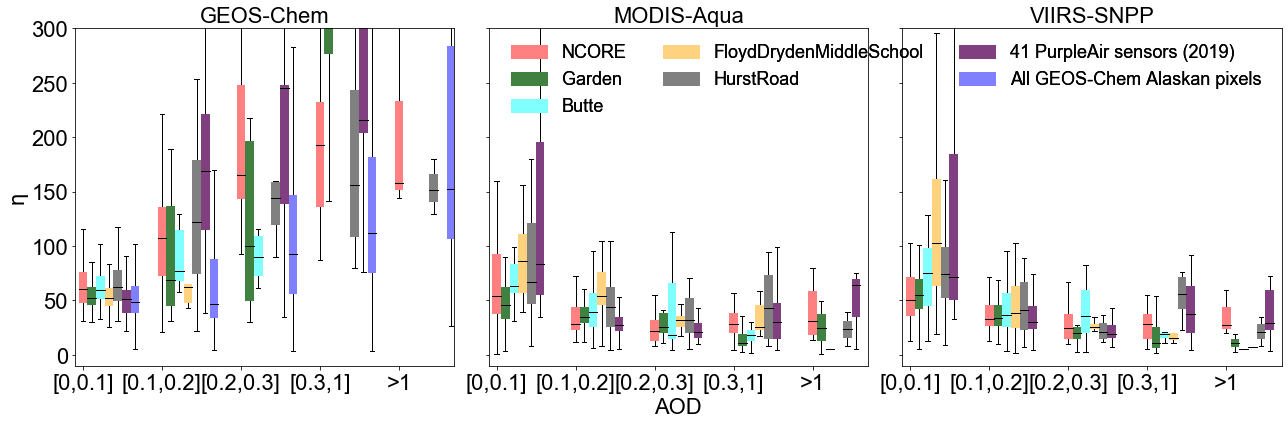

In [251]:
##########################################
#       Figure 5
##########################################


import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

def adjust_colors(colors):
    """
    Adjust the saturation of a list of colors by decreasing it by 50%.

    Args:
        colors (list): List of colors in any valid Matplotlib format.

    Returns:
        list: List of adjusted colors in RGB format.
    """
    # Convert colors to RGB
    rgb_colors = [mcolors.to_rgb(color) for color in colors]

    # Convert RGB colors to HSV
    hsv_colors = [mcolors.rgb_to_hsv(rgb) for rgb in rgb_colors]

    # Decrease the saturation by 50%
    adjusted_colors = hsv_colors.copy()
    for color in adjusted_colors:
        color[1] *= 0.5

    # Convert back to RGB for plotting
    final_colors = [mcolors.hsv_to_rgb(color) for color in adjusted_colors]

    return final_colors

def plot_boxplot(slopes_list, avg_aods_list, labels, ax, colors):
    # Define bins for avg_aod and initialize colors
    bins = [0, 0.1, 0.2, 0.3, 1, np.inf]
    bins_label = [0, 0.1, 0.2, 0.3, 0.4, np.inf]
    
    # Convert colors to RGB
    rgb_colors = [mcolors.to_rgb(color) for color in colors]

    # Convert RGB colors to HSV
    hsv_colors = [mcolors.rgb_to_hsv(rgb) for rgb in rgb_colors]

    # Decrease the saturation by 50%
    adjusted_colors = hsv_colors.copy()
    for color in adjusted_colors:
        color[1] *= 0.5

    # Convert back to RGB for plotting
    final_colors = [mcolors.hsv_to_rgb(color) for color in adjusted_colors]

    medians = []
    for idx, (slopes, avg_aods, color) in enumerate(zip(slopes_list, avg_aods_list, final_colors)):
        slopes = np.array(slopes)
        avg_aods = np.array(avg_aods)
        valid_mask = ~np.isnan(slopes) & ~np.isnan(avg_aods)
        slopes = slopes[valid_mask]
        avg_aods = avg_aods[valid_mask]

        df = pd.DataFrame({
            'slope': slopes,
            'avg_aod': avg_aods
        })

        df['avg_aod_range'] = pd.cut(df['avg_aod'], bins=bins)
        df['avg_aod_bin'] = pd.cut(df['avg_aod'], bins=bins)

        positions = bins_label[0:-1]
        adjusted_positions = [pos + 0.011 * idx for pos in positions]  # adjust position to prevent overlap
        

        for i, (bin_range, group) in enumerate(df.groupby('avg_aod_bin')):
            if len(group) >= 1:
                ax.boxplot(group['slope'], positions=[adjusted_positions[i]], widths=0.011, 
                           patch_artist=True, boxprops=dict(facecolor=color, color='none'),
                           medianprops=dict(color='k'),
                           manage_ticks=False, showfliers=False)
                
                median = group['slope'].median()
                medians.append(median)

    ax.set_ylabel('η')
    ax.set_xlim(-0.01, 0.47)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4])  # Set tick locations
    ax.set_ylim([-10, 300])
    

    return medians, final_colors  # Also return the final_colors


slopes_list = [ slopes_list_GC, slopes_list_MYD04, slopes_list_VIIRS ]
avg_aods_list = [ avg_aods_list_GC, avg_aods_list_MYD04, avg_aods_list_VIIRS ]
titles = ['GEOS-Chem','MODIS-Aqua', 'VIIRS-SNPP']
labels = ["NCORE","Garden","Butte",\
          "FloydDrydenMiddleSchool",\
          "HurstRoad",\
          '41 PurpleAir sensors (2019)','All GEOS-Chem Alaskan pixels']
medians_list = []
colors_GC = ['red', 'green','cyan','orange','gray', 'purple', 'blue']
colors_obs = ['red', 'green','cyan','orange','gray', 'purple']
# colors_list = []  # List to store the final_colors

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    slopes, avg_aods = slopes_list[i], avg_aods_list[i]
    if i==0:
        median, colors = plot_boxplot(slopes, avg_aods, labels, ax[i], colors_GC)  # Call function and unpack return values
    elif i in [1,2]:
        median, colors = plot_boxplot(slopes, avg_aods, labels, ax[i], colors_obs)
    medians_list.append(median)
#     colors_list.append(colors)  # Append colors to colors_list
    if i == 1:
        ax[i].set_xlabel('AOD')
    if i != 0:
        ax[i].set_ylabel('')
        ax[i].set_yticklabels([])
    ax[i].set_title(titles[i],fontsize=22)
    ax[i].set_xticklabels( ['[0,0.1]', '[0.1,0.2]', '[0.2,0.3]', '[0.3,1]','>1'], fontsize=22)
    
    
    
#     # Linear regression
#     slop, intercept = np.polyfit(np.array([0,0.1,0.2,0.3]), medians_list[i][0:4], deg=1)
#     regression_line = slop * np.linspace(0,0.4,10) + intercept
#     ax[i].plot( np.linspace(0,0.4,10), regression_line, color='r')
#     slop, intercept = np.polyfit(np.array([0,0.1,0.2,0.3]), medians_list[i][4:8], deg=1)
#     regression_line = slop * np.linspace(0,0.4,10) + intercept
#     ax[i].plot( np.linspace(0,0.4,10), regression_line, color='b')
#     slop, intercept = np.polyfit(np.array([0,0.1,0.2,0.3]), medians_list[i][-4:], deg=1)
#     regression_line = slop * np.linspace(0,0.4,10) + intercept
#     ax[i].plot( np.linspace(0,0.4,10), regression_line, color='k')

plt.subplots_adjust(wspace=-0.01, hspace=0.01)

# Create a list of patch artists for the legend
colors = colors_GC
final_colors = adjust_colors(colors)
patch_list = [mpatches.Patch(color=color, label=label) for color, label in zip(final_colors, labels)]

# Call the legend function on the third subplot
legend = ax[2].legend(handles=patch_list, loc=(-1.05,0.72), fontsize=18, ncol=3, frameon=False)
plt.gca().add_artist(legend)  # This line ensures the legend is on top of the plot elements
legend.set_alpha(0)


# get median list
[medians_slope_GC, medians_slope_MYD04, medians_slope_VIIRS] = medians_list




plt.tight_layout()
plt.show()

In [ ]:
################################################################################
#        Define function to correct the AOD_PN slope frm GEOS-Chem 
################################################################################
# scale_factor_cali =  np.array(medians_slope_VIIRS[8:12]) / np.array( medians_slope_GC[8:12])
# scale_factor_cali = np.array(medians_slope_VIIRS[-5:]) / np.array(medians_slope_GC[-5:] )
# scale_factor_cali =  np.array([0.28196721, 0.54032258, 0.40724947, 0.35416667, 0.5])    
    
def func_correct_cali(aod):
    
    aodbin_list = [[0,0.1],[0.1,0.2],[0.2,0.3],[0.3,1],[1,np.inf]]
    
    if (aod>aodbin_list[0][0])&(aod<=aodbin_list[0][1]):
        slope = aod * medians_slope_VIIRS[-5]
    elif (aod>aodbin_list[1][0])&(aod<=aodbin_list[1][1]):
        slope = aod * medians_slope_VIIRS[-4]
    elif (aod>aodbin_list[2][0])&(aod<=aodbin_list[2][1]):
        slope = aod * medians_slope_VIIRS[-3]
    elif (aod>aodbin_list[3][0])&(aod<=aodbin_list[3][1]):
        slope = aod * medians_slope_VIIRS[-2]
    elif (aod>aodbin_list[4][0])&(aod<=aodbin_list[4][1]):
        slope = aod * medians_slope_VIIRS[-1]
    else:
        slope = np.nan

    return slope

def func_correct_eta(aod):
    
    aodbin_list = [[0,0.1],[0.1,0.2],[0.2,0.3],[0.3,1],[1,np.inf]]
    
    if (aod>aodbin_list[0][0])&(aod<=aodbin_list[0][1]):
        slope = medians_slope_VIIRS[-5]
    elif (aod>aodbin_list[1][0])&(aod<=aodbin_list[1][1]):
        slope = medians_slope_VIIRS[-4]
    elif (aod>aodbin_list[2][0])&(aod<=aodbin_list[2][1]):
        slope = medians_slope_VIIRS[-3]
    elif (aod>aodbin_list[3][0])&(aod<=aodbin_list[3][1]):
        slope = medians_slope_VIIRS[-2]
    elif (aod>aodbin_list[4][0])&(aod<=aodbin_list[4][1]):
        slope = medians_slope_VIIRS[-1]
    else:
        slope = np.nan

    return slope

def correct_GCslope_da_cali(GCAODmonthly):
    return xr.apply_ufunc(func_correct_cali, GCAODmonthly, vectorize = True)

def correct_GCslope_da_eta(GCAODmonthly):
    return xr.apply_ufunc(func_correct_eta, GCAODmonthly, vectorize = True)

################################################################################
#        Correct GEOS-Chem AOD-PM slope 
################################################################################
VIIRS_DB_PM25_550_AVG_AK_daily_viirseta = correct_GCslope_da_cali( VIIRS_DB_AOD_550_AVG_AK_daily * factor_AOD_VIIRS)
MYD04_L3_PM25_550_AVG_AK_daily_viirseta = correct_GCslope_da_cali( MYD04_L3_AOD_550_AVG_AK_daily * factor_AOD_MYD04)

slope_VIIRS_DB_daily_viirseta = correct_GCslope_da_eta( VIIRS_DB_AOD_550_AVG_AK_daily * factor_AOD_VIIRS)
# slope_MYD04_L3_daily_viirseta = correct_GCslope_da_eta( MYD04_L3_AOD_550_AVG_AK_daily * factor_AOD_MYD04)

In [ ]:
VIIRS_DB_PM25_550_AVG_AK_daily_viirseta_21 = correct_GCslope_da_cali( VIIRS_DB_AOD_550_AVG_AK_daily_21 * factor_AOD_VIIRS)
VIIRS_DB_PM25_550_AVG_AK_daily_viirseta_22 = correct_GCslope_da_cali( VIIRS_DB_AOD_550_AVG_AK_daily_22 * factor_AOD_VIIRS)
# MYD04_L3_PM25_550_AVG_AK_daily_viirseta = correct_GCslope_da_cali( MYD04_L3_AOD_550_AVG_AK_daily * factor_AOD_MYD04)

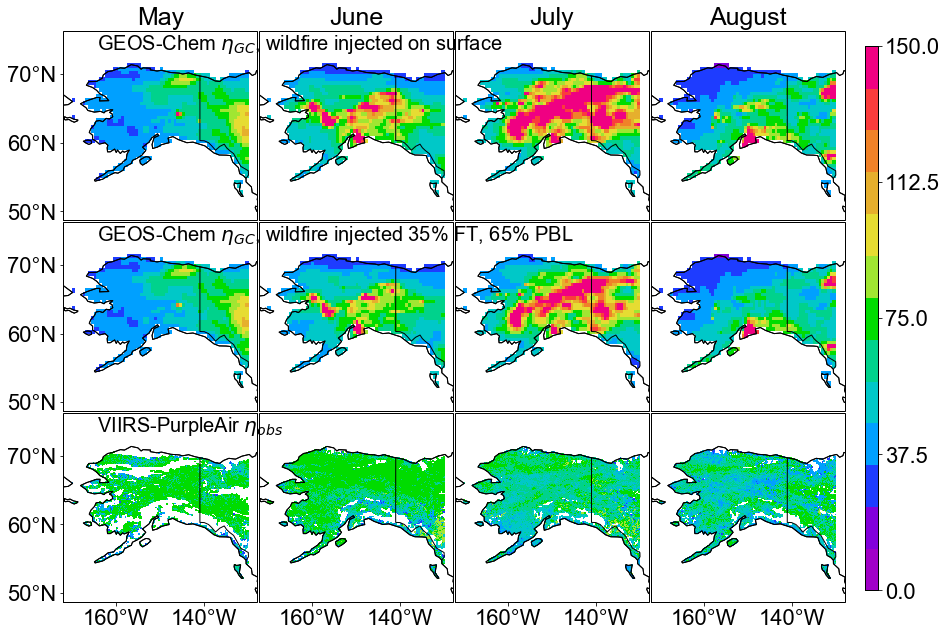

In [34]:
##########################################
#      Figure 7
##########################################



################################################################################
#         Plot Slope spatial pattern      (  original and Corrected  )
################################################################################

# yearlist = [2009,2015,2017,2019]
yearlist = [2019]
# yearlist = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

var = [
    sel_land(   sel_yearlist( slopes_GC_weekly_da, yearlist ).resample(time='1MS').mean(dim='time')   ) ,\
    sel_land(   slopes_GC_weekly_WFIH3565_da.resample(time='1MS').mean(dim='time')    )  ,\
    sel_land(   sel_yearlist( slope_VIIRS_DB_daily_viirseta, yearlist ).resample(time='1MS').mean(dim='time')[0:-1]   ) ,\

      ]

tmp_title = [
    
    "    GEOS-Chem $η_{GC}$, wildfire injected on surface",\
    "    GEOS-Chem $η_{GC}$, wildfire injected 35% FT, 65% PBL",\
    "    VIIRS-PurpleAir $η_{obs}$",\

            ]
vminmax = [[0,150],[0,150],[0,150],[0,100],[0,100],[0,100]]
unitname= ["","","","molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$",\
          "molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$","molec/$\mathregular{cm^2}$"]
cmapname = [ cmaps.grads_rainbow,  cmaps.grads_rainbow, cmaps.grads_rainbow,cmaps.grads_rainbow]
cbposition = [0.92, 0.14, 0.013, 0.72]   # 2 panels
plotID = "1MS"
proplot_mjja(var,tmp_title,vminmax,unitname,cmapname,cbposition, plotID)

# plt.savefig('figs/Figure2.png',dpi=300,bbox_inches='tight')

In [38]:
#################################################################################
#      Purple Air   vs   MODIS PM2.5     

MYD04_L3_PM25_550_AVG_AK_daily_PurpleAir_viirseta = []
VIIRS_BD_PM25_550_AVG_AK_daily_PurpleAir_viirseta = []

for isitename in PA_IDs_AK_avail["column_name"]:
    try:
        thissite_info = PA_IDs_AK_avail[PA_IDs_AK_avail.column_name==isitename].drop_duplicates('sensor_index')
        sensor_index = str(thissite_info['sensor_index'].values[0])
        isite_PA = PurpleAir_data_AK_A_available_corrected_df[sensor_index]
    except:
        continue
        
    isite = PA_IDs_AK_avail[PA_IDs_AK_avail["column_name"]==isitename]
    isite_lat = isite["latitude"].values[0]
    isite_lon = isite["longitude"].values[0]

    mask_site = rum.utilities.calcircle( isite_lat , isite_lon , 27.5 , MYD04_L3_AOD_550_AVG_AK_daily.lat , MYD04_L3_AOD_550_AVG_AK_daily.lon )
    isite_MODIS_data = rum.utilities.selcircle(MYD04_L3_PM25_550_AVG_AK_daily_viirseta, mask_site)
    mask_site = rum.utilities.calcircle( isite_lat , isite_lon , 27.5 , VIIRS_DB_AOD_550_AVG_AK_daily.lat , VIIRS_DB_AOD_550_AVG_AK_daily.lon )
    isite_VIIRS_data = rum.utilities.selcircle(VIIRS_DB_PM25_550_AVG_AK_daily_viirseta, mask_site)

    MYD04_L3_PM25_550_AVG_AK_daily_PurpleAir_viirseta.append(isite_MODIS_data)
    VIIRS_BD_PM25_550_AVG_AK_daily_PurpleAir_viirseta.append(isite_VIIRS_data)
    print(isitename)

ScuppersBane
FairbanksBallaineLynx
USFWS_PM2_510_ANC_1
USFWS_ANC_02
NCore4
HainesSt_
NorthernAlaskaEnvironmentalCenter
AbrahamRd1640Ft
hazen
AllenAdaleRd
CapricornSt_
LineDr_
MushersRoadEastofCrossmanFairbanksAlaska
RockyTop
OpportunityWay
Birchlane
MooseMtn1600
Centeroftheuniverse
TMMAK
1051DakotaSt_NorthPoleAK
EastInternationalSeward
HurstRd_
FairbanksLemonLn
LigniteAve
ToolikFieldStation
HerningRoad
TyonekTribalCenter
DeltaCommunityLibrary
WillowCommunity
QuesadaLn
HealyTransferStation
GakonaVillage
FortYukonCATG
TananaValleyClinic
ReedCircle
InclinationDr_
1231SundanceFairbanks
UniversityParkTower
KBNERR
HoustonCityHall
CantwellTransferStation
DenaliNP
CampbellLakeAlaska
FoxCreek
SnowhookTrail
PiperSt_
APUCCHOutdoor
2190CrippleCreekRd
TotemParkSubdivisionFairbanksAlaska
FairbanksRedpollAlaska
MinersCourtObservatory
CorbinCreekFarm
NorthPolePlackNelson
BallaineFairway
LACLHQ
NCORE#4
PenningtonPark
FireStation5
CStbetwixt9th10th
TetlinNWRHQ
L64
960WoodWay
EllisStreet
HainesSkyline
De

In [39]:
PAlist_PM = np.array([])
MODISPMlist = np.array([])
VIIRSPMlist = np.array([])

ii=0
for isitename in PA_IDs_AK_avail["column_name"]:
    try:
        # PurpleAir site timeseries
        thissite_info = PA_IDs_AK_avail[PA_IDs_AK_avail.column_name==isitename].drop_duplicates('sensor_index')
        sensor_index = str(thissite_info['sensor_index'].values[0])
        isite_PA = PurpleAir_data_AK_19_A_available_corrected_df[sensor_index]
    
        
        # satellite site timeseries 
        isite_MODIS_data = MYD04_L3_PM25_550_AVG_AK_daily_PurpleAir_viirseta[ ii ]
        isite_VIIRS_data = VIIRS_BD_PM25_550_AVG_AK_daily_PurpleAir_viirseta[ ii ]
                
        # append
        PAlist_PM = np.append(PAlist_PM, isite_PA.values)
        MODISPMlist = np.append(MODISPMlist, isite_MODIS_data.loc[isite_PA.index].values)
        VIIRSPMlist = np.append(VIIRSPMlist, isite_VIIRS_data.loc[isite_PA.index].values)
        ii+=1

    except:
        continue

In [54]:
################################################################################
#        Correct GEOS-Chem AOD-PM slope 
################################################################################
VIIRS_DB_PM25_550_AVG_AK_daily_22_viirseta = VIIRS_DB_AOD_550_AVG_AK_daily_22 * factor_AOD_VIIRS * slope_VIIRS_DB_daily_viirseta[slope_VIIRS_DB_daily_viirseta.time.dt.year==2022]
VIIRS_DB_PM25_550_AVG_AK_daily_21_viirseta = VIIRS_DB_AOD_550_AVG_AK_daily_21 * factor_AOD_VIIRS * slope_VIIRS_DB_daily_viirseta[slope_VIIRS_DB_daily_viirseta.time.dt.year==2021]
VIIRS_DB_PM25_550_AVG_AK_daily_21_22_viirseta = xr.concat([VIIRS_DB_PM25_550_AVG_AK_daily_21_viirseta,VIIRS_DB_PM25_550_AVG_AK_daily_22_viirseta], dim='time')

In [55]:
VIIRS_DB_PM25_550_AVG_AK_daily_19_viirseta = VIIRS_DB_AOD_550_AVG_AK_daily_19 * factor_AOD_VIIRS * slope_VIIRS_DB_daily_viirseta[slope_VIIRS_DB_daily_viirseta.time.dt.year==2019]


In [77]:
#################################################################################
#      Purple Air   vs   MODIS PM2.5    

#  2023 Oct 31:   here the 19_22 means 2021-2022
#################################################################################################################

# MYD04_L3_PM25_550_AVG_AK_daily_22_PurpleAir_viirseta = []
# VIIRS_BD_PM25_550_AVG_AK_daily_19_PurpleAir_viirseta = []
# VIIRS_BD_PM25_550_AVG_AK_daily_21_22_PurpleAir_viirseta = []
VIIRS_BD_PM25_550_AVG_AK_daily_21_PurpleAir_viirseta = []
VIIRS_BD_PM25_550_AVG_AK_daily_22_PurpleAir_viirseta = []

for isitename in PA_IDs_AK_avail["column_name"]:
    try:
        thissite_info = PA_IDs_AK_avail[PA_IDs_AK_avail.column_name==isitename].drop_duplicates('sensor_index')
        sensor_index = str(thissite_info['sensor_index'].values[0])

#         isite_PA_19    = PurpleAir_data_AK_A_available_corrected_df[sensor_index].loc['2019-05-01':'2019-08-31']
#         isite_PA_21_22 = PurpleAir_data_AK_A_available_corrected_df[sensor_index].loc['2021-05-01':'2022-08-31']
        isite_PA_21 = PurpleAir_data_AK_A_available_corrected_df[sensor_index].loc['2021-05-01':'2021-08-31']
        isite_PA_22 = PurpleAir_data_AK_A_available_corrected_df[sensor_index].loc['2022-05-01':'2022-08-31']
    except:
        continue
        
    isite = PA_IDs_AK_avail[PA_IDs_AK_avail["column_name"]==isitename]
    isite_lat = isite["latitude"].values[0]
    isite_lon = isite["longitude"].values[0]

#     mask_site = rum.utilities.calcircle( isite_lat , isite_lon , 27.5 , MYD04_L3_AOD_550_AVG_AK_daily.lat , MYD04_L3_AOD_550_AVG_AK_daily.lon )
#     isite_MODIS_data = rum.utilities.selcircle(MYD04_L3_PM25_550_AVG_AK_daily_22_viirseta, mask_site)
    mask_site = rum.utilities.calcircle( isite_lat , isite_lon , 27.5 , VIIRS_DB_AOD_550_AVG_AK_daily.lat , VIIRS_DB_AOD_550_AVG_AK_daily.lon )
#     isite_VIIRS_data_19 = rum.utilities.selcircle(VIIRS_DB_PM25_550_AVG_AK_daily_19_viirseta, mask_site)
#     isite_VIIRS_data_21_22 = rum.utilities.selcircle(VIIRS_DB_PM25_550_AVG_AK_daily_21_22_viirseta, mask_site)
    isite_VIIRS_data_21 = rum.utilities.selcircle(VIIRS_DB_PM25_550_AVG_AK_daily_21_viirseta, mask_site)
    isite_VIIRS_data_22 = rum.utilities.selcircle(VIIRS_DB_PM25_550_AVG_AK_daily_22_viirseta, mask_site)

    
    
#     MYD04_L3_PM25_550_AVG_AK_daily_22_PurpleAir_viirseta.append(isite_MODIS_data)
#     VIIRS_BD_PM25_550_AVG_AK_daily_19_PurpleAir_viirseta.append(isite_VIIRS_data_19)
#     VIIRS_BD_PM25_550_AVG_AK_daily_21_22_PurpleAir_viirseta.append(isite_VIIRS_data_21_22)
    VIIRS_BD_PM25_550_AVG_AK_daily_21_PurpleAir_viirseta.append(isite_VIIRS_data_21)
    VIIRS_BD_PM25_550_AVG_AK_daily_22_PurpleAir_viirseta.append(isite_VIIRS_data_22)
    
    print(isitename)

ScuppersBane
FairbanksBallaineLynx
USFWS_PM2_510_ANC_1
USFWS_ANC_02
NCore4
HainesSt_
NorthernAlaskaEnvironmentalCenter
AbrahamRd1640Ft
hazen
AllenAdaleRd
CapricornSt_
LineDr_
MushersRoadEastofCrossmanFairbanksAlaska
RockyTop
OpportunityWay
Birchlane
MooseMtn1600
Centeroftheuniverse
TMMAK
1051DakotaSt_NorthPoleAK
EastInternationalSeward
HurstRd_
FairbanksLemonLn
LigniteAve
ToolikFieldStation
HerningRoad
TyonekTribalCenter
DeltaCommunityLibrary
WillowCommunity
QuesadaLn
HealyTransferStation
GakonaVillage
FortYukonCATG
TananaValleyClinic
ReedCircle
InclinationDr_
1231SundanceFairbanks
UniversityParkTower
KBNERR
HoustonCityHall
CantwellTransferStation
DenaliNP
CampbellLakeAlaska
FoxCreek
SnowhookTrail
PiperSt_
APUCCHOutdoor
2190CrippleCreekRd
TotemParkSubdivisionFairbanksAlaska
FairbanksRedpollAlaska
MinersCourtObservatory
CorbinCreekFarm
NorthPolePlackNelson
BallaineFairway
LACLHQ
NCORE#4
PenningtonPark
FireStation5
CStbetwixt9th10th
TetlinNWRHQ
L64
960WoodWay
EllisStreet
HainesSkyline
De

In [78]:
PAlist_PM_19 = np.array([])
VIIRSPMlist_19 = np.array([])

PAlist_PM_21_22 = np.array([])
VIIRSPMlist_21_22 = np.array([])

PAlist_PM_21 = np.array([])
VIIRSPMlist_21 = np.array([])

PAlist_PM_22 = np.array([])
VIIRSPMlist_22 = np.array([])

ii = 0
for isitename in PA_IDs_AK_avail["column_name"]:
    try:
        # PurpleAir site timeseries
        thissite_info = PA_IDs_AK_avail[PA_IDs_AK_avail.column_name==isitename].drop_duplicates('sensor_index')
        sensor_index = str(thissite_info['sensor_index'].values[0])
        isite_PA_19    = PurpleAir_data_AK_A_available_corrected_df[sensor_index].loc['2019-05-01':'2019-08-31']
        isite_PA_21_22 = PurpleAir_data_AK_A_available_corrected_df[sensor_index].loc['2021-05-01':'2022-08-31']
        isite_PA_21 = PurpleAir_data_AK_A_available_corrected_df[sensor_index].loc['2021-05-01':'2021-08-31']
        isite_PA_22 = PurpleAir_data_AK_A_available_corrected_df[sensor_index].loc['2022-05-01':'2022-08-31']
        
        # satellite site timeseries
        isite_VIIRS_data_19    = VIIRS_BD_PM25_550_AVG_AK_daily_19_PurpleAir_viirseta[ii]
        isite_VIIRS_data_21_22 = VIIRS_BD_PM25_550_AVG_AK_daily_21_22_PurpleAir_viirseta[ii]
        isite_VIIRS_data_21 = VIIRS_BD_PM25_550_AVG_AK_daily_21_PurpleAir_viirseta[ii]
        isite_VIIRS_data_22 = VIIRS_BD_PM25_550_AVG_AK_daily_22_PurpleAir_viirseta[ii]

        # Check if the time coordinate exists in isite_VIIRS_data
        if 'time' not in isite_VIIRS_data_19.coords:
            raise KeyError("The 'time' coordinate is missing in isite_VIIRS_data")
        if 'time' not in isite_VIIRS_data_21_22.coords:
            raise KeyError("The 'time' coordinate is missing in isite_VIIRS_data")
        if 'time' not in isite_VIIRS_data_22.coords:
            raise KeyError("The 'time' coordinate is missing in isite_VIIRS_data")
        if 'time' not in isite_VIIRS_data_21.coords:
            raise KeyError("The 'time' coordinate is missing in isite_VIIRS_data")

        # Ensure that time indices match between PA and VIIRS data
        common_time_indices_19 = isite_PA_19.index.intersection(isite_VIIRS_data_19.coords['time'].values)
        common_time_indices_21_22 = isite_PA_21_22.index.intersection(isite_VIIRS_data_21_22.coords['time'].values)
        common_time_indices_21 = isite_PA_21.index.intersection(isite_VIIRS_data_21.coords['time'].values)
        common_time_indices_22 = isite_PA_22.index.intersection(isite_VIIRS_data_22.coords['time'].values)
        
        # Append data for common time indices
        PAlist_PM_19 = np.append(PAlist_PM_19, isite_PA_19[common_time_indices_19].values)
        VIIRSPMlist_19 = np.append(VIIRSPMlist_19, isite_VIIRS_data_19.sel(time=common_time_indices_19).values)
        
        PAlist_PM_21_22 = np.append(PAlist_PM_21_22, isite_PA_21_22[common_time_indices_21_22].values)
        VIIRSPMlist_21_22 = np.append(VIIRSPMlist_21_22, isite_VIIRS_data_21_22.sel(time=common_time_indices_21_22).values)
        
        PAlist_PM_21 = np.append(PAlist_PM_21, isite_PA_21[common_time_indices_21].values)
        VIIRSPMlist_21 = np.append(VIIRSPMlist_21, isite_VIIRS_data_21.sel(time=common_time_indices_21).values)
        
        PAlist_PM_22 = np.append(PAlist_PM_22, isite_PA_22[common_time_indices_22].values)
        VIIRSPMlist_22 = np.append(VIIRSPMlist_22, isite_VIIRS_data_22.sel(time=common_time_indices_22).values)
        
        ii += 1

    except:
        continue


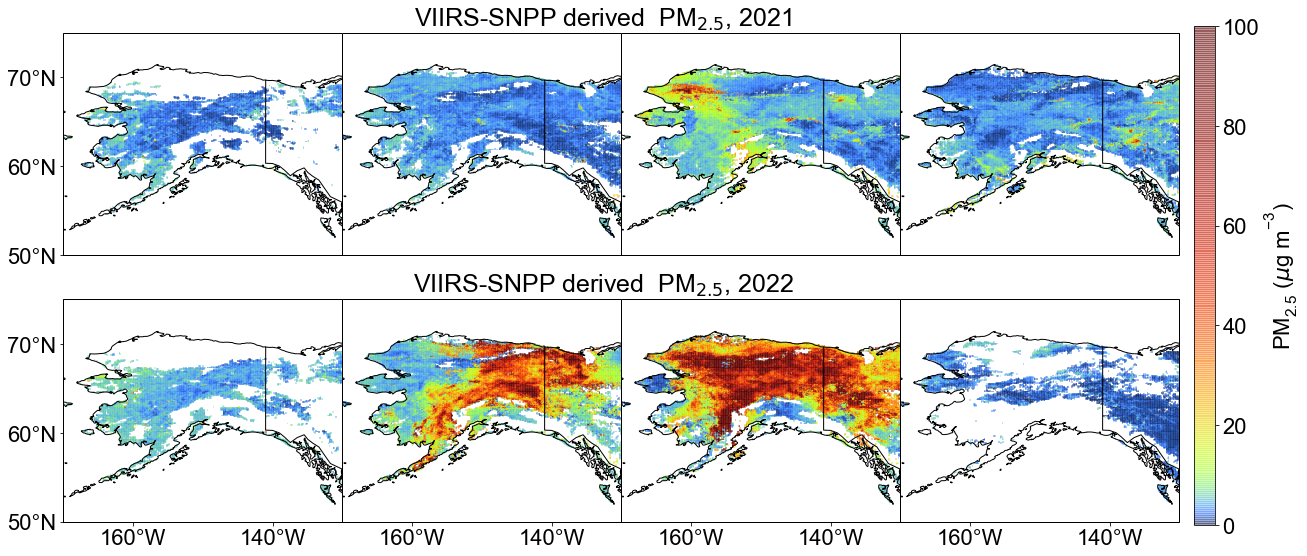

In [72]:
#############################################################
#                       Figure 
#                MODIS PM2.5 spatial pattern
#############################################################

nrow = 2
ncol = 4


fig_len = 5
fig_width = 9

unitname = "$\mathregular{PM_{2.5}}$ ($\mu$g $\mathregular{m^{-3}}$)"
extent = [-170, -130, 50, 75]
str_ipanelindex = ["a","b","c","d","e","f","g","h"]
titles = ["May","June","July","August","May","June","July","August"]
cmap = cmaps.hotres

varlist = [
    VIIRS_DB_PM25_550_AVG_AK_daily_21_viirseta.resample(time='1MS').mean(dim='time'),\
    VIIRS_DB_PM25_550_AVG_AK_daily_22_viirseta.resample(time='1MS').mean(dim='time'),\

]

plt.figure(figsize=(fig_len*ncol,fig_width))
ipanel = 1
iyear=2021
fig=plt.gcf()

for tmp in varlist:

    # for iyear in range(2018,2020):        
    for imon in range(5,9):
        var = tmp[(tmp.time.dt.year==iyear)&(tmp.time.dt.month==imon)].mean(dim='time')
        ax = fig.add_subplot(nrow,ncol,ipanel, projection=ccrs.PlateCarree(), aspect='auto')
        ax.set_extent(extent,ccrs.PlateCarree())
        im = ax.pcolormesh(var.lon, var.lat,\
                           sel_land(var),transform=ccrs.PlateCarree(),vmin=0,vmax=100,cmap=cmap, alpha=0.40)
        ax = plt.gca()

    #     if ipanel == 3:
    #         # add sites
    #         # NCORE
    #         ax.plot(-147.728,64.846,  transform = ccrs.PlateCarree(),marker='o', color='red', markersize=7, linestyle='')
    #         # BonanzaCreek
    #         ax.plot(-148.316,64.743,  transform = ccrs.PlateCarree(),marker='o', color='red', markersize=7, linestyle='')
    #         # ANCHO
    #         ax.plot(-149.824,61.206,  transform = ccrs.PlateCarree(),marker='o', color='red', markersize=7, linestyle='')

        # add text
#         if ipanel<=4:
#             ax.annotate( titles[ipanel-1], xy=(0.4, 1.03), xycoords="axes fraction", fontweight='bold', fontsize = 25 )
    
        # add accessory features
        if ipanel in [5,6,7,8]:
            ax.set_xticks([-160, -140], crs=ccrs.PlateCarree())
            ax.set_xticklabels([-160, -140],fontsize=22)
        if ipanel in [1,5]:
            ax.set_yticks([50,60,70], crs=ccrs.PlateCarree())
            ax.set_yticklabels([50,60,70],fontsize=22)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        ax.add_feature(cfeature.BORDERS)        
        land_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                                edgecolor='k',
                                                facecolor='none')
        ax.add_feature(land_50m)
        ipanel+=1
    iyear+=1
    
import matplotlib.ticker                         # here's where the formatter is
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((0,150))                 # set the limits for sci. not.
position=fig.add_axes([0.91, 0.12, 0.015, 0.77])  # original good scale
cb = fig.colorbar(im,cax=position,orientation='vertical',format=cbformat)
cb.set_label(unitname, fontsize=22)
# Adjust the fontsize of the colorbar tick labels
cb.ax.tick_params(labelsize=22)

fig.text(0.5, 0.90, 'VIIRS-SNPP derived  PM${_{2.5}}$, 2021', ha='center', va='center', fontsize=25)
fig.text(0.5, 0.49, 'VIIRS-SNPP derived  PM${_{2.5}}$, 2022', ha='center', va='center', fontsize=25)

fig.tight_layout()#调整整体空白
plt.subplots_adjust(wspace =0.00, hspace =0.2)#调整子图间距

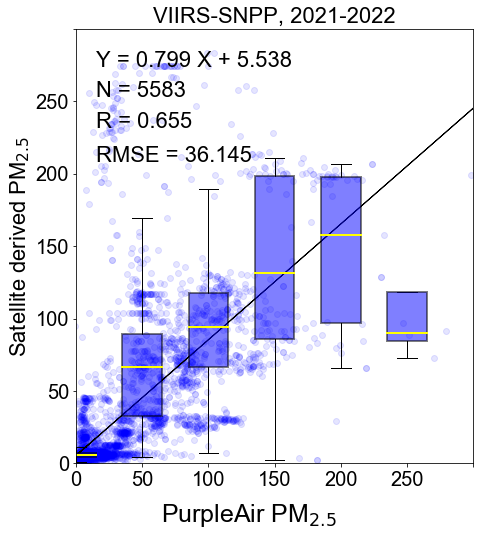

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# Create xarray DataArrays
x_array = PAlist_PM_21_22 * (1.0)
y_array = VIIRSPMlist_21_22

xlims = [0, 300]
ylims = [0, 300]
title = "VIIRS-SNPP, 2021-2022"

# Create the figure and single subplot
fig, ax = plt.subplots(figsize=(7, 7))

# Scatter plot with error bars
ax.scatter(x_array, y_array, color='blue', alpha=0.1, label='Scatter')

# Binned values and uncertainties
bins = np.arange(0, 350, 50)
data = binscatter(x_array, y_array, bins)
x_binned, y_binned = data["X"]["mean"].values, data["Y"]["mean"].values
x_err, y_err = data["X"]["std"].values, data["Y"]["std"].values

# Scatter plot with error bars for binned data
# ax.errorbar(x_binned, y_binned, xerr=x_err, yerr=y_err, fmt='o', color='black', label='Binned', lw=2, capsize=3)

medians = []

valid_mask = ~np.isnan(x_array) & ~np.isnan(y_array)
x_array = x_array[valid_mask]
y_array = y_array[valid_mask]

df = pd.DataFrame({
    'x': x_array,
    'y': y_array
})

df['x_bin'] = pd.cut(df['x'], bins=bins)

positions = bins[:-1]

for ii, (bin_range, group) in enumerate(df.groupby('x_bin')):
    if len(group) >= 1:
        ax.boxplot(group['y'], positions=[positions[ii]], widths=30, 
                   patch_artist=True, boxprops=dict(facecolor='blue', color='black', alpha=0.5, linewidth=2),
                   medianprops=dict(color='yellow', linewidth=2),
                   manage_ticks=False, showfliers=False)
        median = group['y'].median()
        medians.append(median)

# Set subplot title and labels
ax.set_title(title, fontsize=22)
ax.set_ylabel('Satellite derived PM${_{2.5}}$', fontsize=22)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

add_text(ax, x_array, y_array)

# Add texts
ax.set_xticklabels(np.arange(0, 300, 50), rotation=0, fontsize=20)
ax.set_yticklabels(np.arange(0, 300, 50), rotation=0, fontsize=20)

fig.text(0.5, -0.03, 'PurpleAir PM${_{2.5}}$', ha='center', va='center', fontsize=25)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.3)
# Show the figure
plt.show()


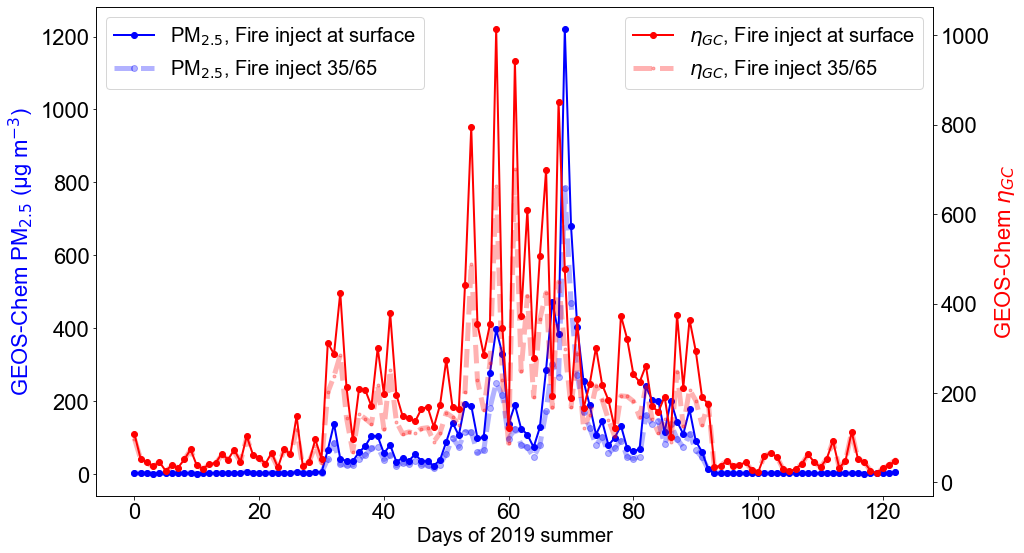

In [224]:
# NCORE
mask_NCORE = rum.utilities.calcircle( 64.846, -147.727, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AOD_GC_19_WFIH3565_noon_daily_NCORE = rum.utilities.selcircle( AOD_GC_19_WFIH3565_noon_daily, mask_NCORE)
PM25_surf_GC_19_WFIH3565_daily_NCORE = rum.utilities.selcircle( PM25_surf_GC_19_WFIH3565_daily[:,0,:,:], mask_NCORE)





# Define the years of interest
years_of_interest = [2019]
# years_of_interest = [2005,2009,2015,2019]


# Create empty arrays for PM2.5 and PM2.5/AOD
pm25_concat = xr.DataArray(np.array([]), dims=['time'], coords={'time': []})
pm25_concat_WFIH3565 = xr.DataArray(np.array([]), dims=['time'], coords={'time': []})
pm25_aod_concat = xr.DataArray(np.array([]), dims=['time'], coords={'time': []})
pm25_aod_concat_WFIH3565 = xr.DataArray(np.array([]), dims=['time'], coords={'time': []})


# Iterate over each year
for year in years_of_interest:
    # Filter PM2.5 data for the current year
    pm25_data = PM25_surf_GC_05to19_daily_NCORE[PM25_surf_GC_05to19_daily_NCORE.time.dt.year == year]
    # Concatenate PM2.5 data for the current year
    pm25_concat = xr.concat([pm25_concat, pm25_data], dim='time')
        
    # Filter PM2.5/AOD data for the current year
    tmp_data = (PM25_surf_GC_05to19_daily_NCORE / AOD_GC_05to19_noon_daily_NCORE  )
    tmp_data = tmp_data[tmp_data.time.dt.year == year]
    # Concatenate PM2.5/AOD data for the current year
    pm25_aod_concat = xr.concat([pm25_aod_concat, tmp_data], dim='time')
    
    # -------------------------------------------------------
    
    # Filter PM2.5 data for the current year
    pm25_data = PM25_surf_GC_19_WFIH3565_daily_NCORE
    # Concatenate PM2.5 data for the current year
    pm25_concat_WFIH3565 = xr.concat([pm25_concat_WFIH3565, pm25_data], dim='time')

    # Filter PM2.5/AOD data for the current year
    tmp_data = (PM25_surf_GC_19_WFIH3565_daily_NCORE / AOD_GC_19_WFIH3565_noon_daily_NCORE  )
    tmp_data = tmp_data[tmp_data.time.dt.year == year]    
    # Concatenate PM2.5/AOD data for the current year
    pm25_aod_concat_WFIH3565 = xr.concat([pm25_aod_concat_WFIH3565, tmp_data], dim='time')    
    

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(15, 9))

# Plot concatenated PM2.5 data with lines connecting the points
ax1.plot(pm25_concat, color='blue', marker='o', linestyle='-', alpha=1, lw=2)
ax1.plot(pm25_concat_WFIH3565, color='blue', marker='o', linestyle='--', alpha=0.3, lw=5)


# Set the first y-axis label
ax1.set_ylabel('PM2.5', color='blue')

# Create second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot concatenated PM2.5/AOD data with lines connecting the points
ax2.plot(pm25_aod_concat , color='red', marker='o', linestyle='-', alpha=1, lw=2)
ax2.plot(pm25_aod_concat_WFIH3565 , color='red', marker='.', linestyle='--', alpha=0.3, lw=5)

ax1.set_ylabel("GEOS-Chem PM${_{2.5}}$ (µg m${^{-3} }$)", color='blue')
ax2.set_ylabel('GEOS-Chem $\eta_{GC}$', color='red')

ax1.set_xlabel('Days of 2019 summer', fontsize=20)

# Customize legend
ax1.legend(['PM${_{2.5}}$, Fire inject at surface','PM${_{2.5}}$, Fire inject 35/65'], loc='upper left', fontsize=20)
ax2.legend(['$\eta_{GC}$, Fire inject at surface','$\eta_{GC}$, Fire inject 35/65'], loc='upper right', fontsize=20)

# Show plot
plt.show()


In [154]:
# Assuming "time" is your datetime column
# years_to_select = [ 2009, 2015, 2019]
years_to_select = [ 2006,2007,2008,2009,2010,2011,2012,2013,2014, 2015,2016,2017,2018, 2019]
# CALIPSO_AOD_532_AK_NCORE_fireyear = CALIPSO_AOD_532_AK_NCORE[CALIPSO_AOD_532_AK_NCORE['time'].dt.year.isin(years_to_select)]
CALIPSO_AODPBL_532_AK_2x5 = CALIPSO_fPBLAOD_532_AK_2x5 * CALIPSO_AOD_532_AK_2x5_integrated

# NCORE
mask_NCORE = rum.utilities.calcircle( 64.846, -147.727, 120, CALIPSO_AODPBL_532_AK_2x5.lat, CALIPSO_AODPBL_532_AK_2x5.lon )
CALIPSO_AODPBL_532_AK_2x5_NCORE = rum.utilities.selcircle( CALIPSO_AODPBL_532_AK_2x5, mask_NCORE)
CALIPSO_AODPBL_532_AK_2x5_NCORE_fireyear = CALIPSO_AODPBL_532_AK_2x5_NCORE[CALIPSO_AODPBL_532_AK_2x5_NCORE['time'].dt.year.isin(years_to_select)]
CALIPSO_AOD_532_AK_2x5_integrated_NCORE = rum.utilities.selcircle( CALIPSO_AOD_532_AK_2x5_integrated, mask_NCORE)
CALIPSO_AOD_532_AK_2x5_integrated_NCORE_fireyear = CALIPSO_AOD_532_AK_2x5_integrated_NCORE[CALIPSO_AOD_532_AK_2x5_integrated_NCORE['time'].dt.year.isin(years_to_select)]



# calculate the same thing for GEOS-Chem
mask_NCORE = rum.utilities.calcircle( 64.846, -147.727, 50, AOD_GC_05to19_noon_daily.lat, AOD_GC_05to19_noon_daily.lon )
AOD_GC_05to19_noon_daily_NCORE_fireyear =  AOD_GC_05to19_noon_daily_NCORE[AOD_GC_05to19_noon_daily_NCORE['time'].dt.year.isin(years_to_select)]
AOD_GC_05to19_noon_daily_monthly_NCORE = rum.utilities.selcircle( AOD_GC_05to19_noon_daily_monthly, mask_NCORE)
AOD_GC_05to19_noon_daily_monthly_NCORE_fireyear =  AOD_GC_05to19_noon_daily_monthly_NCORE[AOD_GC_05to19_noon_daily_monthly_NCORE['time'].dt.year.isin(years_to_select)]
fPBLAOD_05to19_noon_daily_monthly_NCORE = rum.utilities.selcircle( fPBLAOD_05to19_noon_daily_monthly, mask_NCORE)
fPBLAOD_05to19_noon_daily_monthly_NCORE_fireyear =  fPBLAOD_05to19_noon_daily_monthly_NCORE[fPBLAOD_05to19_noon_daily_monthly_NCORE['time'].dt.year.isin(years_to_select)]

AODPBL_GC_05to19_noon_daily_monthly_NCORE_fireyear = fPBLAOD_05to19_noon_daily_monthly_NCORE_fireyear * AOD_GC_05to19_noon_daily_monthly_NCORE_fireyear

In [155]:
##################################################################
#              regrid MODIS to CALIOP grid (2x5)
##################################################################

CALIgrid = xr.Dataset({'lat': (['lat'], CALIPSO_ext_532_AK_2x5.lat.values),
                     'lon': (['lon'], CALIPSO_ext_532_AK_2x5.lon.values),
                    })
regridder = xe.Regridder(fPBLAOD_05to19_noon_daily_monthly, CALIgrid, 'bilinear')

fPBLAOD_05to19_noon_daily_monthly_2x5 = regridder(fPBLAOD_05to19_noon_daily_monthly)
fPBLAOD_05to19_noon_daily_monthly_2x5 = fPBLAOD_05to19_noon_daily_monthly_2x5.where(fPBLAOD_05to19_noon_daily_monthly_2x5 != 0)
AOD_GC_05to19_noon_daily_monthly_2x5 = regridder(AOD_GC_05to19_noon_daily_monthly)
AOD_GC_05to19_noon_daily_monthly_2x5 = AOD_GC_05to19_noon_daily_monthly_2x5.where(AOD_GC_05to19_noon_daily_monthly_2x5 != 0)



mask_NCORE = rum.utilities.calcircle( 64.846, -147.727, 150, CALIPSO_ext_532_AK_2x5.lat, CALIPSO_ext_532_AK_2x5.lon )
AOD_GC_05to19_noon_daily_monthly_2x5_NCORE = rum.utilities.selcircle( AOD_GC_05to19_noon_daily_monthly_2x5, mask_NCORE)
AOD_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear =  AOD_GC_05to19_noon_daily_monthly_2x5_NCORE[AOD_GC_05to19_noon_daily_monthly_2x5_NCORE['time'].dt.year.isin(years_to_select)]
fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE = rum.utilities.selcircle( fPBLAOD_05to19_noon_daily_monthly_2x5, mask_NCORE)
fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE_fireyear =  fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE[fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE['time'].dt.year.isin(years_to_select)]

AODPBL_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear = fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE_fireyear * AOD_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear

In [385]:
AODHyg550nm_BCPI_05to19 = xr.load_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_BCPI_05to19_2D.nc', engine='netcdf4')
tmp = AODHyg550nm_BCPI_05to19['AODHyg550nm_BCPI']
tmp_noon = tmp[(tmp.time.dt.hour>=20) & (tmp.time.dt.hour<=23)]
AODHyg550nm_BCPI_05to19_noon_daily = tmp_noon.resample(time='1D').mean(dim='time').dropna(dim='time')

AODHyg550nm_BCPI_05to19_noon_daily.to_netcdf('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_BCPI_05to19_noon_daily_new.nc')

In [386]:
AODHyg550nm_OCPI_05to19 = xr.load_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_OCPI_05to19_2D.nc', engine='netcdf4')
tmp = AODHyg550nm_OCPI_05to19['AODHyg550nm_OCPI']
tmp_noon = tmp[(tmp.time.dt.hour>=20) & (tmp.time.dt.hour<=23)]
AODHyg550nm_OCPI_05to19_noon_daily = tmp_noon.resample(time='1D').mean(dim='time').dropna(dim='time')

AODHyg550nm_OCPI_05to19_noon_daily.to_netcdf('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_OCPI_05to19_noon_daily.nc')

In [387]:
AODHyg550nm_SALA_05to19 = xr.load_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_SALA_05to19_2D.nc', engine='netcdf4')
tmp = AODHyg550nm_SALA_05to19['AODHyg550nm_SALA']
tmp_noon = tmp[(tmp.time.dt.hour>=20) & (tmp.time.dt.hour<=23)]
AODHyg550nm_SALA_05to19_noon_daily = tmp_noon.resample(time='1D').mean(dim='time').dropna(dim='time')

AODHyg550nm_SALA_05to19_noon_daily.to_netcdf('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_SALA_05to19_noon_daily.nc')

In [388]:
AODHyg550nm_SALC_05to19 = xr.load_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_SALC_05to19_2D.nc', engine='netcdf4')
tmp = AODHyg550nm_SALC_05to19['AODHyg550nm_SALC']
tmp_noon = tmp[(tmp.time.dt.hour>=20) & (tmp.time.dt.hour<=23)]
AODHyg550nm_SALC_05to19_noon_daily = tmp_noon.resample(time='1D').mean(dim='time').dropna(dim='time')

AODHyg550nm_SALC_05to19_noon_daily.to_netcdf('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_SALC_05to19_noon_daily.nc')

In [389]:
AODHyg550nm_SO4_05to19 = xr.load_dataset('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_SO4_05to19_2D.nc', engine='netcdf4')
tmp = AODHyg550nm_SO4_05to19['AODHyg550nm_SO4']
tmp_noon = tmp[(tmp.time.dt.hour>=20) & (tmp.time.dt.hour<=23)]
AODHyg550nm_SO4_05to19_noon_daily = tmp_noon.resample(time='1D').mean(dim='time').dropna(dim='time')

AODHyg550nm_SO4_05to19_noon_daily.to_netcdf('/import/GREENING/tzhao/jndata/GEOS-Chem/MEGANon_PFTol_WF/AODHyg550nm_SO4_05to19_noon_daily.nc')

In [390]:
AODHyg550nm_sum_05to19_noon_daily = AODHyg550nm_BCPI_05to19_noon_daily + AODHyg550nm_OCPI_05to19_noon_daily +\
AODHyg550nm_SALA_05to19_noon_daily + AODHyg550nm_SALC_05to19_noon_daily +\
AODHyg550nm_SO4_05to19_noon_daily


mask_NCORE = rum.utilities.calcircle( 64.846, -147.727, 27.5, AOD_GC_05to19.lat, AOD_GC_05to19.lon )
AODHyg550nm_sum_05to19_noon_daily_NCORE = rum.utilities.selcircle( AODHyg550nm_sum_05to19_noon_daily, mask_NCORE)
AODHyg550nm_BCPI_05to19_noon_daily_NCORE = rum.utilities.selcircle( AODHyg550nm_BCPI_05to19_noon_daily, mask_NCORE)
AODHyg550nm_OCPI_05to19_noon_daily_NCORE = rum.utilities.selcircle( AODHyg550nm_OCPI_05to19_noon_daily, mask_NCORE)

Text(0, 0.5, 'AOD')

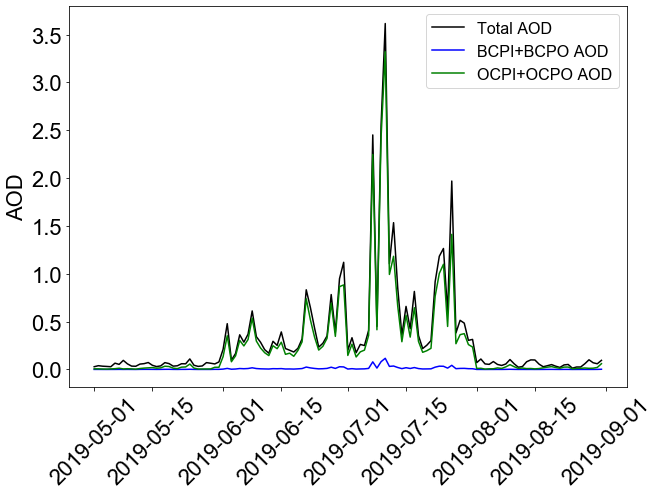

In [392]:
plt.figure(figsize=(10,7))

tmp = AODHyg550nm_sum_05to19_noon_daily_NCORE[AODHyg550nm_sum_05to19_noon_daily_NCORE.time.dt.year==2019]
plt.plot(tmp.time, tmp, color='black')

tmp = AODHyg550nm_BCPI_05to19_noon_daily_NCORE[AODHyg550nm_BCPI_05to19_noon_daily_NCORE.time.dt.year==2019]
plt.plot(tmp.time, tmp, color='blue')

tmp = AODHyg550nm_OCPI_05to19_noon_daily_NCORE[AODHyg550nm_OCPI_05to19_noon_daily_NCORE.time.dt.year==2019]
plt.plot(tmp.time, tmp, color='green')

plt.legend(('Total AOD','BCPI+BCPO AOD','OCPI+OCPO AOD'), fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('AOD')

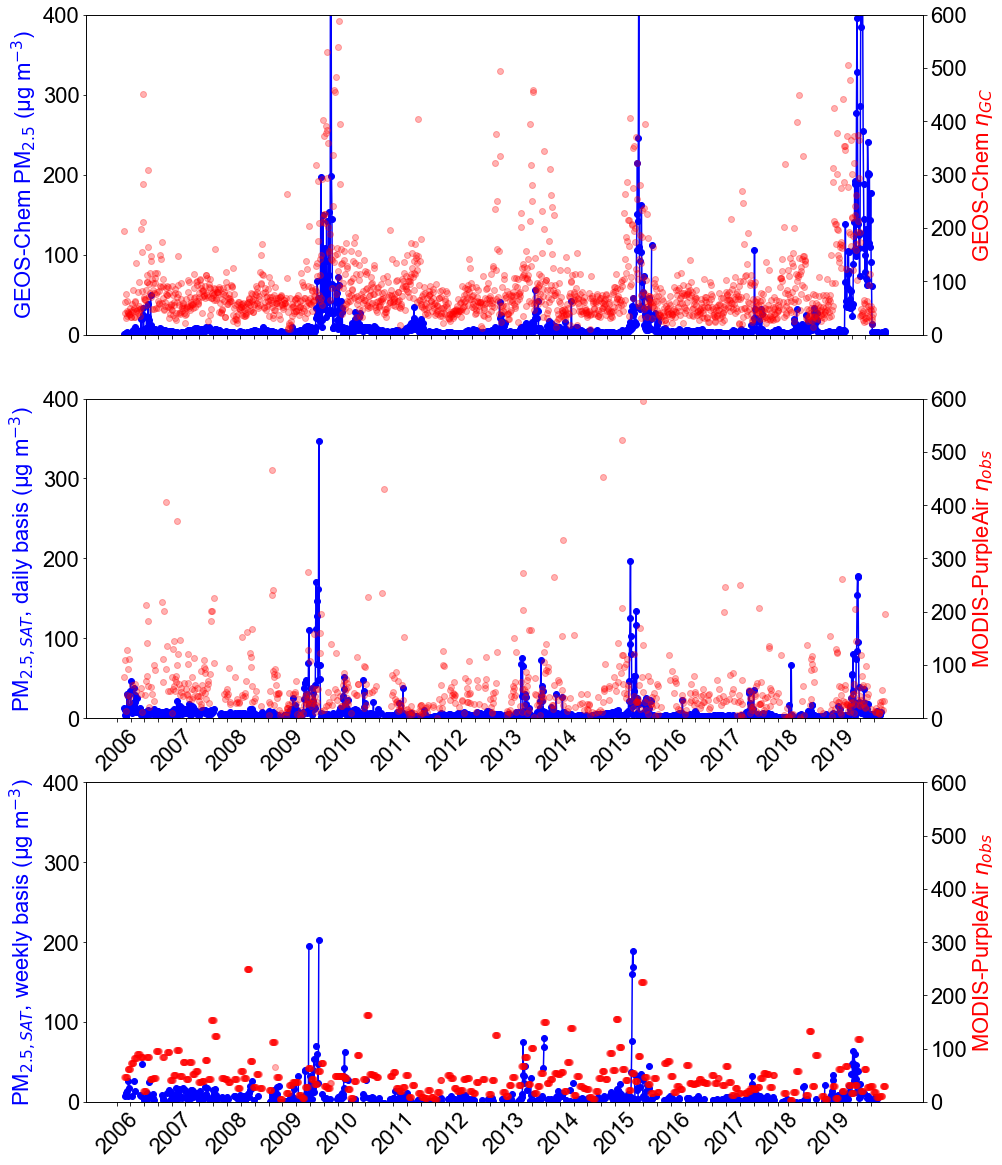

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Define the years of interest
years_of_interest = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

# Create empty arrays for PM2.5 and PM2.5/AOD
pm25_concat_1 = xr.DataArray(np.array([]), dims=['time'], coords={'time': []})
pm25_aod_concat_1 = xr.DataArray(np.array([]), dims=['time'], coords={'time': []})
pm25_concat_2 = xr.DataArray(np.array([]), dims=['time'], coords={'time': []})
pm25_aod_concat_2 = xr.DataArray(np.array([]), dims=['time'], coords={'time': []})
aod_concat_2 = xr.DataArray(np.array([]), dims=['time'], coords={'time': []})



# Iterate over each year for the first subplot
for year in years_of_interest:
    # Filter PM2.5 data for the current year
    pm25_data = PM25_surf_GC_05to19_daily_NCORE[PM25_surf_GC_05to19_daily_NCORE.time.dt.year == year]
    # Concatenate PM2.5 data for the current year
    pm25_concat_1 = xr.concat([pm25_concat_1, pm25_data], dim='time')

    # Filter PM2.5/AOD data for the current year
    tmp_data = (PM25_surf_GC_05to19_daily_NCORE / AOD_GC_05to19_noon_daily_NCORE)
    tmp_data = tmp_data[tmp_data.time.dt.year == year]    
    # Concatenate PM2.5/AOD data for the current year
    pm25_aod_concat_1 = xr.concat([pm25_aod_concat_1, tmp_data], dim='time')

# Iterate over each year for the second subplot
for year in years_of_interest:
    # Filter PM2.5 data for the current year
    pm25_data = DEC_NCORE_88501_PM25_da_daily[DEC_NCORE_88501_PM25_da_daily.time.dt.year == year]
    pm25_data = pm25_data[(pm25_data.time.dt.month >= 5) & (pm25_data.time.dt.month <= 8)]
    # Concatenate PM2.5 data for the current year
    pm25_concat_2 = xr.concat([pm25_concat_2, pm25_data], dim='time')
    
    
    # Filter AOD data for the current year
    aod_data = MYD04_L3_AOD_550_AVG_AK_daily_NCORE[MYD04_L3_AOD_550_AVG_AK_daily_NCORE.time.dt.year == year]
    aod_data = aod_data[(aod_data.time.dt.month >= 5) & (aod_data.time.dt.month <= 8)]
    # Concatenate PM2.5 data for the current year
    aod_concat_2 = xr.concat([aod_concat_2, aod_data], dim='time')
    
    
    # Filter PM2.5/AOD data for the current year
    tmp_data = (DEC_NCORE_88501_PM25_da_daily / MYD04_L3_AOD_550_AVG_AK_daily_NCORE)
    tmp_data = tmp_data[tmp_data.time.dt.year == year]
    # filter bad data
    tmp_data[tmp_data < -100] = np.nan
    # Concatenate PM2.5/AOD data for the current year
    pm25_aod_concat_2 = xr.concat([pm25_aod_concat_2, tmp_data], dim='time')

# Calculate weekly eta (PM2.5/AOD) for the third subplot
weekly_eta = pm25_concat_2.resample(time='1W').mean() / aod_concat_2.resample(time='1W').mean()

# Create a daily time index covering the same period as weekly_eta
daily_time_index = pd.date_range(start=weekly_eta.time.values[0], end=weekly_eta.time.values[-1], freq='D')

# Reindex weekly_eta to daily, filling forward to maintain the same eta within each week
daily_eta = weekly_eta.reindex(time=daily_time_index, method='ffill')

# Use daily eta and daily AOD to calculate daily PM2.5
daily_eta = daily_eta[(daily_eta.time.dt.month>=5) & (daily_eta.time.dt.month<=8)]
daily_pm25_from_eta = ( daily_eta * aod_concat_2 )




# Create figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))

# Plot concatenated PM2.5 data with lines connecting the points for the first subplot
ax1.plot(pm25_concat_1, color='blue', marker='o', linestyle='-')
# Set the first y-axis label for the first subplot
ax1.set_ylabel("GEOS-Chem PM${_{2.5}}$ (µg m${^{-3} }$)", color='blue')
# Create second axis sharing the same x-axis for the first subplot
ax1_2 = ax1.twinx()
# Plot concatenated PM2.5/AOD data with lines connecting the points for the first subplot
ax1_2.plot(pm25_aod_concat_1, color='red', marker='o', linestyle='-', alpha=0.3, linewidth=0)
# Set the second y-axis label for the first subplot
ax1_2.set_ylabel('GEOS-Chem $\eta_{GC}$', color='red')
ax1.set_ylim([0, 400])
ax1_2.set_ylim([0, 600])

# Set x-axis tick positions and labels for the first subplot
ax1_ticks = []
ax1_tick_labels = []
for year in years_of_interest:
    for month in range(5, 9):
        ax1_ticks.append(len(pm25_concat_1.sel(time=(pm25_concat_1.time.dt.year == year) & (pm25_concat_1.time.dt.month == month))))
        ax1_tick_labels.append(f'{year}-{month}')
ax1.set_xticks(np.cumsum(ax1_ticks) - 0.5 * np.array(ax1_ticks))
ax1.set_xticklabels([], rotation=45)

# Plot concatenated PM2.5 data with lines connecting the points for the second subplot
ax2.plot(pm25_concat_2, color='blue', marker='o', linestyle='-')
# Set the first y-axis label for the second subplot
ax2.set_ylabel("PM${_{2.5,SAT}}$, daily basis (µg m${^{-3} }$)", color='blue')
# Create second axis sharing the same x-axis for the second subplot
ax2_2 = ax2.twinx()
# Plot concatenated PM2.5/AOD data with lines connecting the points for the second subplot
ax2_2.plot(pm25_aod_concat_2, color='red', marker='o', linestyle='-', alpha=0.3, linewidth=0)
# Set the second y-axis label for the second subplot
ax2_2.set_ylabel('MODIS-PurpleAir $\eta_{obs}$', color='red')
ax2.set_ylim([0, 400])
ax2_2.set_ylim([0, 600])

# Set x-axis tick positions and labels for the second subplot
ax2_ticks = []
ax2_tick_labels = []
for year in years_of_interest:
    for month in range(5, 9):
        ax2_ticks.append(len(pm25_concat_2.sel(time=(pm25_concat_2.time.dt.year == year) & (pm25_concat_2.time.dt.month == month))))
        if month == 5:
            ax2_tick_labels.append(f'{year}')
        elif month >= 6:
            ax2_tick_labels.append('')
ax2.set_xticks(np.cumsum(ax2_ticks) - 0.5 * np.array(ax2_ticks))
ax2.set_xticklabels(ax2_tick_labels, rotation=45)




# Plot concatenated PM2.5 data with lines connecting the points for the second subplot
ax3.plot(daily_pm25_from_eta, color='blue', marker='o', linestyle='-')
# Set the first y-axis label for the second subplot
ax3.set_ylabel("PM${_{2.5,SAT}}$, weekly basis (µg m${^{-3} }$)", color='blue')
# Create second axis sharing the same x-axis for the second subplot
ax3_2 = ax3.twinx()
# Plot concatenated PM2.5/AOD data with lines connecting the points for the second subplot
ax3_2.plot(daily_eta, color='red', marker='o', linestyle='-', alpha=0.3, linewidth=0)
# Set the second y-axis label for the second subplot
ax3_2.set_ylabel('MODIS-PurpleAir $\eta_{obs}$', color='red')
ax3.set_ylim([0, 400])
ax3_2.set_ylim([0, 600])

# Set x-axis tick positions and labels for the second subplot
ax3_ticks = []
ax3_tick_labels = []
for year in years_of_interest:
    for month in range(5, 9):
        ax3_ticks.append(len(daily_pm25_from_eta.sel(time=(daily_pm25_from_eta.time.dt.year == year) & (daily_pm25_from_eta.time.dt.month == month))))
        if month == 5:
            ax3_tick_labels.append(f'{year}')
        elif month >= 6:
            ax3_tick_labels.append('')
ax3.set_xticks(np.cumsum(ax3_ticks) - 0.5 * np.array(ax3_ticks))
ax3.set_xticklabels(ax3_tick_labels, rotation=45)




# Show plot
plt.show()


In [247]:
# Assuming "time" is your datetime column
# years_to_select = [ 2009, 2015, 2019]
years_to_select = [ 2006,2007,2008,2009,2010,2011,2012,2013,2014, 2015,2016,2017,2018, 2019]
# years_to_select = [ 2009, 2010]

# CALIPSO_AOD_532_AK_NCORE_fireyear = CALIPSO_AOD_532_AK_NCORE[CALIPSO_AOD_532_AK_NCORE['time'].dt.year.isin(years_to_select)]
CALIPSO_AODPBL_532_AK_2x5 = CALIPSO_fPBLAOD_532_AK_2x5 * CALIPSO_AOD_532_AK_2x5_integrated

[target_lat, target_lon] = [64.846, -147.727]

# NCORE
mask_NCORE = rum.utilities.calcircle( target_lat, target_lon, 150, CALIPSO_AODPBL_532_AK_2x5.lat, CALIPSO_AODPBL_532_AK_2x5.lon )
CALIPSO_AODPBL_532_AK_2x5_NCORE = rum.utilities.selcircle( CALIPSO_AODPBL_532_AK_2x5, mask_NCORE)
CALIPSO_AODPBL_532_AK_2x5_NCORE_fireyear = CALIPSO_AODPBL_532_AK_2x5_NCORE[CALIPSO_AODPBL_532_AK_2x5_NCORE['time'].dt.year.isin(years_to_select)]
CALIPSO_AOD_532_AK_2x5_integrated_NCORE = rum.utilities.selcircle( CALIPSO_AOD_532_AK_2x5_integrated, mask_NCORE)
CALIPSO_AOD_532_AK_2x5_integrated_NCORE_fireyear = CALIPSO_AOD_532_AK_2x5_integrated_NCORE[CALIPSO_AOD_532_AK_2x5_integrated_NCORE['time'].dt.year.isin(years_to_select)]



# calculate the same thing for GEOS-Chem
mask_NCORE = rum.utilities.calcircle( target_lat, target_lon, 50, AOD_GC_05to19_noon_daily.lat, AOD_GC_05to19_noon_daily.lon )
AOD_GC_05to19_noon_daily_NCORE_fireyear =  AOD_GC_05to19_noon_daily_NCORE[AOD_GC_05to19_noon_daily_NCORE['time'].dt.year.isin(years_to_select)]
AOD_GC_05to19_noon_daily_monthly_NCORE = rum.utilities.selcircle( AOD_GC_05to19_noon_daily_monthly, mask_NCORE)
AOD_GC_05to19_noon_daily_monthly_NCORE_fireyear =  AOD_GC_05to19_noon_daily_monthly_NCORE[AOD_GC_05to19_noon_daily_monthly_NCORE['time'].dt.year.isin(years_to_select)]
fPBLAOD_05to19_noon_daily_monthly_NCORE = rum.utilities.selcircle( fPBLAOD_05to19_noon_daily_monthly, mask_NCORE)
fPBLAOD_05to19_noon_daily_monthly_NCORE_fireyear =  fPBLAOD_05to19_noon_daily_monthly_NCORE[fPBLAOD_05to19_noon_daily_monthly_NCORE['time'].dt.year.isin(years_to_select)]

AODPBL_GC_05to19_noon_daily_monthly_NCORE_fireyear = fPBLAOD_05to19_noon_daily_monthly_NCORE_fireyear * AOD_GC_05to19_noon_daily_monthly_NCORE_fireyear

In [248]:
##################################################################
#              regrid MODIS to CALIOP grid (2x5)
##################################################################

CALIgrid = xr.Dataset({'lat': (['lat'], CALIPSO_ext_532_AK_2x5.lat.values),
                     'lon': (['lon'], CALIPSO_ext_532_AK_2x5.lon.values),
                    })
regridder = xe.Regridder(fPBLAOD_05to19_noon_daily_monthly, CALIgrid, 'bilinear')

fPBLAOD_05to19_noon_daily_monthly_2x5 = regridder(fPBLAOD_05to19_noon_daily_monthly)
fPBLAOD_05to19_noon_daily_monthly_2x5 = fPBLAOD_05to19_noon_daily_monthly_2x5.where(fPBLAOD_05to19_noon_daily_monthly_2x5 != 0)
AOD_GC_05to19_noon_daily_monthly_2x5 = regridder(AOD_GC_05to19_noon_daily_monthly)
AOD_GC_05to19_noon_daily_monthly_2x5 = AOD_GC_05to19_noon_daily_monthly_2x5.where(AOD_GC_05to19_noon_daily_monthly_2x5 != 0)



mask_NCORE = rum.utilities.calcircle( target_lat, target_lon, 150, CALIPSO_ext_532_AK_2x5.lat, CALIPSO_ext_532_AK_2x5.lon )
AOD_GC_05to19_noon_daily_monthly_2x5_NCORE = rum.utilities.selcircle( AOD_GC_05to19_noon_daily_monthly_2x5, mask_NCORE)
AOD_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear =  AOD_GC_05to19_noon_daily_monthly_2x5_NCORE[AOD_GC_05to19_noon_daily_monthly_2x5_NCORE['time'].dt.year.isin(years_to_select)]
fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE = rum.utilities.selcircle( fPBLAOD_05to19_noon_daily_monthly_2x5, mask_NCORE)
fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE_fireyear =  fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE[fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE['time'].dt.year.isin(years_to_select)]

AODPBL_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear = fPBLAOD_05to19_noon_daily_monthly_2x5_NCORE_fireyear * AOD_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear

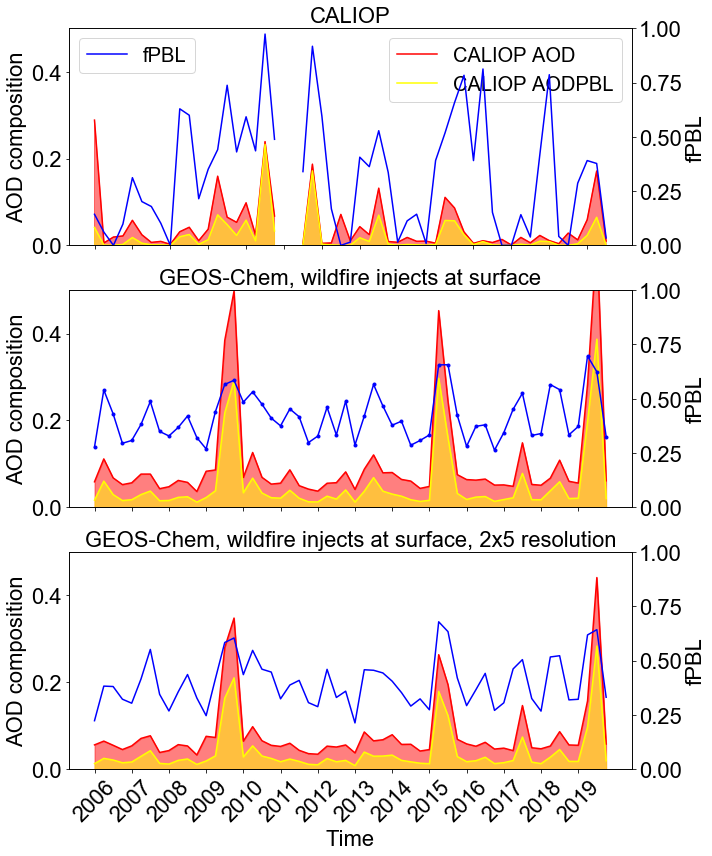

In [249]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot the first set of data on ax1
ax1.plot(CALIPSO_AOD_532_AK_2x5_integrated_NCORE_fireyear, color='red', label='CALIOP AOD')
ax1.plot(CALIPSO_AODPBL_532_AK_2x5_NCORE_fireyear, color='yellow', label='CALIOP AODPBL')
ax1.fill_between(range(len(CALIPSO_AOD_532_AK_2x5_integrated_NCORE_fireyear)), CALIPSO_AOD_532_AK_2x5_integrated_NCORE_fireyear, color='red', alpha=0.5)
ax1.fill_between(range(len(CALIPSO_AODPBL_532_AK_2x5_NCORE_fireyear)), CALIPSO_AODPBL_532_AK_2x5_NCORE_fireyear, color='yellow', alpha=0.5)
ax1.set_ylabel('AOD composition')
ax1.legend(fontsize=20)
ax1.set_ylim([0,0.5])
ax1.set_title('CALIOP')

# Create a secondary y-axis on the right for ax1
ax1_right = ax1.twinx()

# Compute the fraction of AODPBL to AODtotal for ax1
fraction_AODPBL_1 = CALIPSO_AODPBL_532_AK_2x5_NCORE_fireyear / CALIPSO_AOD_532_AK_2x5_integrated_NCORE_fireyear

# Plot the fraction on the secondary y-axis for ax1
ax1_right.plot(fraction_AODPBL_1, color='blue', label='fPBL')
ax1_right.set_ylabel('fPBL')
ax1_right.set_ylim([0, 1])

# Add legend for the secondary y-axis for ax1
lines, labels = ax1_right.get_legend_handles_labels()
ax1_right.legend(lines, labels, loc='upper left', fontsize=20)

# Plot the second set of data on ax2
ax2.plot(AOD_GC_05to19_noon_daily_monthly_NCORE_fireyear, color='red', label='GC AOD')
ax2.plot(AODPBL_GC_05to19_noon_daily_monthly_NCORE_fireyear, color='yellow', label='GC AODPBL')
ax2.fill_between(range(len(AOD_GC_05to19_noon_daily_monthly_NCORE_fireyear)), AOD_GC_05to19_noon_daily_monthly_NCORE_fireyear, color='red', alpha=0.5)
ax2.fill_between(range(len(AODPBL_GC_05to19_noon_daily_monthly_NCORE_fireyear)), AODPBL_GC_05to19_noon_daily_monthly_NCORE_fireyear, color='yellow', alpha=0.5)
ax2.set_ylabel('AOD composition')
ax2.set_ylim([0, 0.5])
ax2.set_title('GEOS-Chem, wildfire injects at surface')

# Create a secondary y-axis on the right for ax2
ax2_right = ax2.twinx()

# Compute the fraction of AODPBL to AODtotal for ax2
fraction_AODPBL_2 = AODPBL_GC_05to19_noon_daily_monthly_NCORE_fireyear / AOD_GC_05to19_noon_daily_monthly_NCORE_fireyear

# Plot the fraction on the secondary y-axis for ax2
ax2_right.plot(fraction_AODPBL_2, marker='.',color='blue', label='Fraction AODPBL / AODtotal')
ax2_right.set_ylabel('fPBL')
ax2_right.set_ylim([0, 1])

# Add legend for the secondary y-axis for ax2
# lines, labels = ax2_right.get_legend_handles_labels()
# ax2_right.legend(lines, labels, loc='upper right', fontsize=20)

# Plot the third set of data on ax3
ax3.plot(AOD_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear, color='red', label='GC AOD')
ax3.plot(AODPBL_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear, color='yellow', label='GC AODPBL')
ax3.fill_between(range(len(AOD_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear)), AOD_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear, color='red', alpha=0.5)
ax3.fill_between(range(len(AODPBL_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear)), AODPBL_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear, color='yellow', alpha=0.5)
ax3.set_xlabel('Time')
ax3.set_ylabel('AOD composition')
ax3.set_ylim([0, 0.5])
ax3.set_title('GEOS-Chem, wildfire injects at surface, 2x5 resolution')

# Create a secondary y-axis on the right for ax3
ax3_right = ax3.twinx()

# Compute the fraction of AODPBL to AODtotal for ax3
fraction_AODPBL_3 = AODPBL_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear / AOD_GC_05to19_noon_daily_monthly_2x5_NCORE_fireyear

# Plot the fraction on the secondary y-axis for ax3
ax3_right.plot(fraction_AODPBL_3, color='blue', label='Fraction AODPBL / AODtotal')
ax3_right.set_ylabel('fPBL')
ax3_right.set_ylim([0, 1])

# Add legend for the secondary y-axis for ax3
# lines, labels = ax3_right.get_legend_handles_labels()
# ax3_right.legend(lines, labels, loc='upper right', fontsize=20)

# Set x-axis tick labels
years = years_to_select
# months = ['05', '06', '07', '08']
ticks = [i for i in range(0, len(years_to_select)*4, 4)]
ax1.set_xticks(ticks)
ax1.set_xticklabels([])
ax2.set_xticks(ticks)
ax2.set_xticklabels([])
ax3.set_xticks(ticks)
# ax3.set_xticklabels([f'{year}/{month}' for year in years for month in months], rotation=45)
ax3.set_xticklabels([f'{year}' for year in years], rotation=45)

plt.tight_layout()
plt.show()


In [233]:
bins_fPBL = np.arange( 0, 1 , 0.1 )
# tmp_slope_viirs_2x5, tmp_fpbl_cali_2x5 = xr.align(slope_VIIRS_DB_daily_viirseta_monthly_2x5, CALIPSO_fPBLAOD_532_AK_2x5, join='inner')

# data_VIIRS_fPBL_eta = binscatter( sel_land(tmp_fpbl_cali_2x5).values.flatten(),\
#                                  sel_land(tmp_slope_viirs_2x5).values.flatten(), bins_fPBL)
# data_VIIRS_aod_eta = binscatter( sel_land(tmp_fpbl_cali_2x5).values.flatten(),\
#                                  sel_land(tmp_slope_viirs_2x5).values.flatten(), bins_fPBL)

data_GC_fPBL_eta = binscatter( sel_land(fPBLAOD_05to19_noon_daily_monthly).values.flatten(), sel_land(slopes_GC_monthly_da).values.flatten(), bins_fPBL)
data_GC_fPBL_aod = binscatter( sel_land(fPBLAOD_05to19_noon_daily_monthly).values.flatten(), sel_land(AOD_GC_05to19_noon_daily_monthly).values.flatten(), bins_fPBL)




import math

tmp_avg_aods_NCORE, tmp_slopes_NCORE = calculate_sma_regression( MYD04_L3_AOD_550_AVG_AK_daily_NCORE * factor_AOD_MYD04, DEC_NCORE_88101_PM25_da_daily, 'M')
tmp_avg_aods_Garden, tmp_slopes_Garden = calculate_sma_regression( MYD04_L3_AOD_550_AVG_AK_daily_Garden * factor_AOD_MYD04, DEC_Garden_88101_PM25_da_daily, 'M')

tmp_slopes_NCORE = np.array( [x for x in tmp_slopes_NCORE if not math.isnan(x)] )  # 2012-2021
tmp_avg_aods_NCORE = np.array( [x for x in tmp_avg_aods_NCORE if not math.isnan(x)] )  # 2012-2021
# tmp_slopes_Garden = np.array( [x for x in tmp_slopes_Garden if not math.isnan(x)] )  # 2012-2021

# NCORE
mask_NCORE_CALI = rum.utilities.calcircle( 64.846, -147.727, 100, CALIPSO_fPBLAOD_532_AK_2x5.lat, CALIPSO_fPBLAOD_532_AK_2x5.lon )
CALIPSO_fPBLAOD_532_AK_2x5_NCORE = rum.utilities.selcircle( CALIPSO_fPBLAOD_532_AK_2x5, mask_NCORE_CALI)

# Garden
mask_Garden_CALI = rum.utilities.calcircle( 61.206, -149.824, 100, CALIPSO_fPBLAOD_532_AK_2x5.lat, CALIPSO_fPBLAOD_532_AK_2x5.lon )
CALIPSO_fPBLAOD_532_AK_2x5_Garden = rum.utilities.selcircle( CALIPSO_fPBLAOD_532_AK_2x5, mask_Garden_CALI)
 
data_MYD04_fPBL_eta = binscatter( CALIPSO_fPBLAOD_532_AK_2x5_NCORE.values, tmp_slopes_NCORE[5:] ,bins_fPBL )
data_MYD04_fPBL_aods = binscatter( CALIPSO_fPBLAOD_532_AK_2x5_NCORE.values, tmp_avg_aods_NCORE[5:] ,bins_fPBL )



Text(0, 0.5, 'η (μg/m${^3}$)')

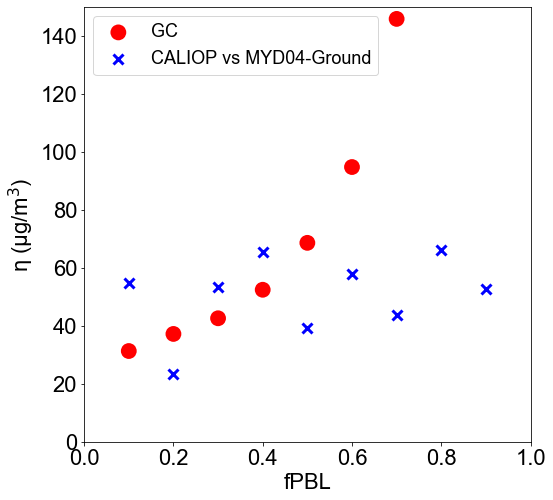

In [234]:
plt.figure(figsize=(8,8))
# plt.scatter( sel_land( fPBLAOD_05to19_noon_daily_monthly).values.flatten(),\
#             sel_land(slopes_GC_monthly_da).values.flatten(),\
#             marker='o', s=2, lw=2, alpha=0.2,\
#            c=sel_land( AOD_GC_05to19_noon_daily_monthly).values.flatten() * factor_AOD_GC  ,\
#             vmin=0,vmax=3,\
#            cmap=cmaps.hotres)

plt.scatter( bins_fPBL[1:], data_GC_fPBL_eta["Y"]['mean'],\
            marker='.', s=1000, lw=3, edgecolor='none',\
#            c=data_GC_fPBL_aod["Y"]['mean'],\
            vmin=0,vmax=0.5,\
#             cmap=cmaps.hotres
           color='red'
           )

plt.scatter( bins_fPBL[1:], data_MYD04_fPBL_eta["Y"]['mean'],\
            marker='x', s=100, lw=3, edgecolor='k',\
#            c=data_MYD04_fPBL_aods["Y"]['mean'],\
            vmin=0,vmax=0.5,\
#             cmap=cmaps.hotres
           color='blue'
           )

# plt.scatter( data_CALI["Y"]['mean'], data_VIIRS["Y"]['mean'],\
#             marker='+', s=100, lw=3,\
#            c=data_VIIRS["X"]['mean'],\
#             vmin=0,vmax=3,\
#            cmap=cmaps.hotres)

plt.ylim([0,150])
plt.xlim([0,1])
# plt.colorbar()

plt.legend(('GC','CALIOP vs MYD04-Ground','CALIOP vs VIIRS-Ground'),fontsize=18)

plt.xlabel('fPBL')
plt.ylabel('η (μg/m${^3}$)')

In [255]:
DEC_NCORE_PM25 =xr.open_dataset(jndir_AOD+"NCORE_combined_88501_PM25.nc", engine="netcdf4")["sample_measurement"]


DEC_NCORE_PM25_da_noon_daily = DEC_NCORE_PM25.copy()
DEC_NCORE_PM25_da_noon_daily = DEC_NCORE_PM25_da_noon_daily[DEC_NCORE_PM25_da_noon_daily.time.dt.hour>=20]
DEC_NCORE_PM25_da_noon_daily = DEC_NCORE_PM25_da_noon_daily.resample(time='1D').mean(dim='time')
DEC_NCORE_PM25_da_noon_daily = DEC_NCORE_PM25_da_noon_daily[(DEC_NCORE_PM25_da_noon_daily.time.dt.month>=5) & (DEC_NCORE_PM25_da_noon_daily.time.dt.month<=8)]

DEC_NCORE_PM25_da_daily = DEC_NCORE_PM25.resample(time='1D').mean(dim='time')
DEC_NCORE_PM25_da_daily = DEC_NCORE_PM25_da_daily[(DEC_NCORE_PM25_da_daily.time.dt.month>=5) & (DEC_NCORE_PM25_da_daily.time.dt.month<=8)]


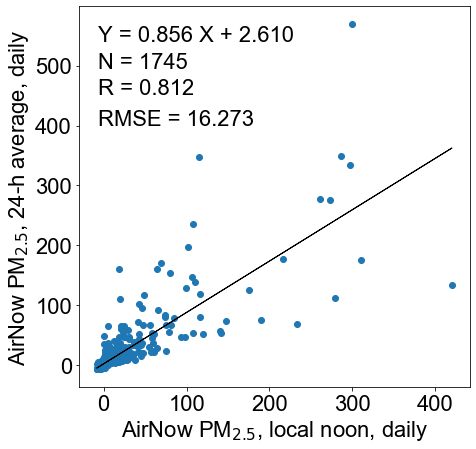

In [270]:

# Create the figure and axis
plt.figure(figsize=(7, 7))
ax1 = plt.subplot(1, 1, 1)

# Scatter plot
ax1.scatter(DEC_NCORE_PM25_da_noon_daily, DEC_NCORE_PM25_da_daily)

# Add text to points
add_text(ax1, DEC_NCORE_PM25_da_noon_daily.values, DEC_NCORE_PM25_da_daily.values)

plt.xlabel('AirNow PM${_{2.5}}$, local noon, daily')
plt.ylabel('AirNow PM${_{2.5}}$, 24-h average, daily')
# Show the plot
plt.show()